# Project: Forecasting Peruvian GDP Using Deep Learning Techniques

*First version*

**Key Highlights**

-  **Data Extraction:** Data was obtained from BCRP, initially containing approximately 5000 monthly variables, and filtered down to 872 after extensive cleaning.

-  **Stationarity Testing:** Multiple unit root tests (e.g., ADF, PP, KPSS) were applied to assess and transform non-stationary series into a stationary dataset.

    
-  **Hyperparameter Search:** Five different RNN architectures were trained using a comprehensive hyperparameter search to optimize model performance.

    
-  **Temporal Cross-Validation:** A rolling forecast cross-validation was implemented to ensure robust and reliable evaluation across multiple time splits.


-  **Forecasting monthly percentage changes in GDP:** Is complex due to the high-dimensional nature of exogenous inputs. Our approach leverages Principal Component Analysis (PCA) to reduce the dimensionality of these inputs by extracting the most informative features into a lower-dimensional space. This process not only minimizes computational load during model training but also acts as an implicit regularizer, mitigating the risk of overfitting by eliminating redundant or noisy features.  

In [180]:
import os
import re
import logging
import warnings
import time
import urllib3
import requests
from io import StringIO
from datetime import datetime
from typing import List, Tuple, Dict, Optional, Union, Callable
from tqdm import tqdm
from unidecode import unidecode
import matplotlib.pyplot as plt

# Web scraping
from bs4 import BeautifulSoup
from pytrends.request import TrendReq

# Data handling
import pandas as pd
import numpy as np

# Machine learning & statistics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, zivot_andrews
from arch.unitroot import PhillipsPerron, KPSS
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterSampler

# Deep learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset

# Parallel processing
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

# Miscellaneous
import inspect
from statsmodels.tsa.seasonal import seasonal_decompose

## Data Extraction Using Web-Scraping Techniques

In [3]:
# Initial configuration
logging.basicConfig(level=logging.INFO)
warnings.simplefilter("ignore", category=FutureWarning)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Configurable constants
BASE_URL = 'https://estadisticas.bcrp.gob.pe/estadisticas/series'

FREQUENCIES = ['diarias', 'mensuales', 'trimestrales']

EXCLUDED_KEYWORDS = ["Total", "totales", "Desestacionalizado", "var%", "variación", "variaciones",
                     "porcentaje", "Tipo de cambio", "coeficiente", "descontinuada", "Tasas de Crecimiento" ]

ABBREVIATED_MONTHS = {
    'Ene': '01', 'Feb': '02', 'Mar': '03', 'Abr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Ago': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dic': '12'
}

DATE_FORMAT = '%d-%m-%Y'
MAX_WORKERS = min(10, os.cpu_count() or 1)
DATA_FILE   = 'bcrp_data.csv'
YEAR_CUTOFF = 2003
END_DATE    = '01-12-2024'

# Precompiled regular expressions
RE_CATEGORIA  = re.compile(r'(.+?)\n\s*-\s*(\d+)\s+series')
RE_MONEDA     = re.compile(r'\((millones\s+S/|millones\s+US\$)\)')
RE_SERIE_BASE = re.compile(r'\s*\(millones.*\)')


class BCRPDataProcessor:
    def __init__(self):
        self.df = pd.DataFrame()
        self.raw_data = []
        self.df_daily = pd.DataFrame()
        self.df_monthly = pd.DataFrame()
        self.df_quarterly = pd.DataFrame()

    def fetch_data(self) -> None:
        """Extracts data for all configured frequencies"""
        for freq in FREQUENCIES:
            logging.info(f"Extracting data for {freq}...")
            self.raw_data.extend(self._extract_variables(freq))

        self.df = pd.DataFrame(self.raw_data).pipe(self._clean_data)
        self._split_by_frequency()  # New method

    def _split_by_frequency(self) -> None:
        """Splits the DataFrame into three by frequency, with error handling"""
        if not hasattr(self, 'df') or self.df.empty:
            logging.error("No data available to split by frequency")
            return

        if 'Frecuencia' not in self.df.columns:
            logging.error("The 'Frecuencia' column does not exist in the DataFrame")
            return

        # Clean the 'Frecuencia' column
        frecuencias = self.df['Frecuencia'].str.strip().str.lower()

        # Robust filtering
        try:
            self.df_daily    = self.df[frecuencias == 'diarias'].reset_index(drop=True)
            self.df_monthly    = self.df[frecuencias == 'mensuales'].reset_index(drop=True)
            self.df_quarterly = self.df[frecuencias == 'trimestrales'].reset_index(drop=True)
        except Exception as e:
            logging.error(f"Error filtering by frequency: {str(e)}")
            return

        # Results verification
        for freq_name, df in [('Diaria', self.df_daily),
                              ('Mensual', self.df_monthly),
                              ('Trimestral', self.df_quarterly)]:
            if df.empty:
                logging.warning(f"No data found for frequency {freq_name}")

    def _extract_variables(self, frequency: str) -> List[Dict]:
        """Extracts variables for a specific frequency"""
        try:
            soup = BeautifulSoup(requests.get(f'{BASE_URL}/{frequency}').text, 'html.parser')
            return [
                self._parse_variable_row(category, frequency, row)
                for category in soup.find_all('div', class_='tcg-elevator')
                for row in category.find('table', class_='series').find_all('tr')[1:]  # Skip header row
            ]
        except Exception as e:
            logging.error(f"Error extracting {frequency}: {str(e)}")
            return []

    @staticmethod
    def _parse_variable_row(category, frequency: str, row) -> Dict:
        """Parses a variable data row"""
        cols = row.find_all('td')
        return {
            'Frecuencia': frequency,
            'Categoria': category.find('h2', class_='categoria_titulo').text.strip(),
            'Codigo': cols[1].text.strip(),
            'Serie': cols[2].text.strip(),
            'Fecha_Inicio': cols[3].text.strip(),
            'Fecha_Fin': cols[4].text.strip(),
            'Ultima_Actualizacion': cols[5].text.strip()
        }

    def _clean_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Main data cleaning and transformation"""
        return (
            df
            .assign(
                Nombre_de_Categoria=lambda x: x.Categoria.str.replace(r'\s+', ' ', regex=True).str.strip(),
                Numero_de_Series=lambda x: x.Categoria.str.extract(r'(\d+)')[0].fillna(0).astype(int)
            )
            .pipe(self._convert_dates)
            .pipe(self._filter_data)
            .pipe(self._remove_duplicates)
            .pipe(self._filter_string_columns)
            .reset_index(drop=True)
        )

    def _convert_dates(self, df: pd.DataFrame) -> pd.DataFrame:
        """Conversion of special date formats"""
        date_columns = ['Fecha_Inicio_Mod', 'Fecha_Fin_Mod']
        return df.assign(**{
            col: df[['Fecha_Inicio', 'Fecha_Fin'][i]].apply(self._convert_date)
            for i, col in enumerate(date_columns)
        }).drop(columns=['Categoria', 'Fecha_Inicio', 'Fecha_Fin'])

    @staticmethod
    def _convert_date(date_str: str) -> str:
        """Converts non-standard date formats"""
        if date_str.startswith('T'):
            trim, year = date_str.split('-')
            month = f"{int(trim[1])*3-2:02d}"
            return datetime(int(year), int(month), 1).strftime(DATE_FORMAT)

        if date_str.split('-')[0] in ABBREVIATED_MONTHS:
            month, year = date_str.split('-')
            return datetime(int(year), int(ABBREVIATED_MONTHS[month]), 1).strftime(DATE_FORMAT)

        try:
            return pd.to_datetime(date_str, dayfirst=True).strftime(DATE_FORMAT)
        except:
            return date_str

    def _filter_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filtering by date range"""
        date_cond = (
            pd.to_datetime(df.Fecha_Inicio_Mod, errors='coerce').dt.year <= YEAR_CUTOFF) & (
            pd.to_datetime(df.Fecha_Fin_Mod, errors='coerce') >= pd.Timestamp(END_DATE)
        )
        return df[date_cond].copy()

    def _remove_duplicates(self, df: pd.DataFrame) -> pd.DataFrame:
        """Removal of duplicates in multiple steps"""
        return (
            df
            .drop_duplicates(subset=['Codigo'])
            .pipe(self._handle_cross_frequency_duplicates)
            .pipe(self._handle_currency_duplicates)
        )

    @staticmethod
    def _handle_cross_frequency_duplicates(df: pd.DataFrame) -> pd.DataFrame:
        """Handles duplicates across different frequencies"""
        duplicates = df.groupby('Nombre_de_Categoria').Frecuencia.nunique()
        dup_categories = duplicates[duplicates > 1].index
        return pd.concat([
            df[~df.Nombre_de_Categoria.isin(dup_categories)],
            df[df.Nombre_de_Categoria.isin(dup_categories) & (df.Frecuencia == 'mensuales')]
        ])

    @staticmethod
    def _handle_currency_duplicates(df: pd.DataFrame) -> pd.DataFrame:
        """Handles currency duplicates"""
        df['Serie_base'] = df.Serie.str.replace(RE_SERIE_BASE, '', regex=True)
        soles_mask = df.Serie.str.contains(r'\(millones S/\)', regex=True)
        return (
            df[~(df.Serie_base.isin(df[soles_mask].Serie_base) & ~soles_mask)]
            .drop(columns=['Serie_base'])
            .reset_index(drop=True)
        )

    def _filter_string_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filtering by content in text columns"""
        for col in ['Nombre_de_Categoria', 'Serie']:
            df = df[~df[col].str.contains('|'.join(EXCLUDED_KEYWORDS), case=False, na=False)]
        return df



In [4]:

class BCRPDataDownloader:
    def __init__(self, metadata: pd.DataFrame, frequency: str = None):
        self.metadata = self._filter_by_frequency(metadata, frequency)
        self.existing_data = self._load_existing_data()

    def _filter_by_frequency(self, df: pd.DataFrame, frequency: str) -> pd.DataFrame:
        """Additional filtering by frequency if specified"""
        if frequency:
            df = df[df['Frecuencia'].str.strip().str.lower() == frequency.lower()]
            if df.empty:
                logging.warning(f"No data for frequency {frequency}")
        return df

    @staticmethod
    def _load_existing_data() -> pd.DataFrame:
        """Loads existing data if available"""
        if os.path.exists(DATA_FILE):
            return pd.read_csv(DATA_FILE, index_col=0, parse_dates=True)
        return pd.DataFrame()

    def download_series(self) -> pd.DataFrame:
        """Downloads time series using multithreading"""
        needed_columns      = set(self._generate_column_names())
        existing_columns    = set(self.existing_data.columns)
        missing_columns     = needed_columns - existing_columns

        if not missing_columns:
            logging.info("All data is already up to date")
            return self.existing_data

        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            
            futures = {
            executor.submit(
            self._download_single_series,
            row.Codigo,
            row.Fecha_Inicio_Mod,
            row.Fecha_Fin_Mod,
            self._generate_column_name(row)
            ): idx for idx, row in self.metadata.iterrows()
            if self._generate_column_name(row) in missing_columns
            }

            


            

            results = {}
            for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Downloading"):
                result = future.result()
                if result:
                    results.update(result)

        return self._save_and_merge_data(results)

    def _generate_column_names(self) -> List[str]:
        """Generates expected column names"""
        return [
            f"{row.Codigo} - {row.Nombre_de_Categoria} - {row.Serie}"
            for _, row in self.metadata.iterrows()
        ]
    
    def _generate_column_name(self, row) -> str:
        """Generates column name for a specific row"""
        return f"{row.Codigo} - {row.Nombre_de_Categoria} - {row.Serie}"

    
    def _download_single_series(self, code: str, start: str, end: str, name: str) -> Optional[Dict]:
        """Downloads a single time series"""
        try:
            url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{code}/csv/"
            url += f"{pd.to_datetime(start, dayfirst=True):%Y-%m}/{pd.to_datetime(end, dayfirst=True):%Y-%m}"

            response = requests.get(url, verify=False, timeout=15)
            response.raise_for_status()

            data = response.text.replace("<br>", "\n").strip()
            # Modify this line (add skiprows=1)
            df = pd.read_csv(StringIO(data), header=None, skiprows=1)

            # Date processing
            df[0] = pd.to_datetime(
                df[0].str[:3].map(ABBREVIATED_MONTHS) + df[0].str[3:],
                format='%m.%Y',
                errors='coerce'
            )

            # Remove rows with invalid dates
            df = df.dropna(subset=[0])

            return {name: df.set_index(0).squeeze().rename(name)}

        except Exception as e:
            logging.error(f"Error in {code} ({name}): {str(e)}")
            return None

    def _save_and_merge_data(self, new_data: Dict) -> pd.DataFrame:
        """Combines and saves only the new data"""
        if new_data:
            new_df = pd.concat([pd.Series(v, name=k) for k, v in new_data.items()], axis=1)

            # Remove rows where the index is NaT
            new_df = new_df[~new_df.index.isna()]

            # Sort by date
            new_df = new_df.sort_index()

            # Save
            new_df.to_csv(DATA_FILE)
            return new_df
        return self.existing_data


In [5]:
# Processing with automatic frequency division
processor = BCRPDataProcessor()
processor.fetch_data()

# Access the filtered data
daily = processor.df_daily
monthly = processor.df_monthly
quarterly = processor.df_quarterly

print("Shape of Daily Data:", daily.shape)
print("Shape of Monthly Data:", monthly.shape)
print("Shape of Quarterly Data:", quarterly.shape)

INFO:root:Extracting data for diarias...
INFO:root:Extracting data for mensuales...
INFO:root:Extracting data for trimestrales...


Shape of Daily Data: (44, 8)
Shape of Monthly Data: (1012, 8)
Shape of Quarterly Data: (195, 8)


/var/folders/fk/v7c5p8wn1knfy26l727g3py40000gn/T/ipykernel_24403/3730208330.py:148: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pd.to_datetime(df.Fecha_Fin_Mod, errors='coerce') >= pd.Timestamp(END_DATE)


In [6]:
monthly.head(3)

,Frecuencia,Codigo,Serie,Ultima_Actualizacion,Nombre_de_Categoria,Numero_de_Series,Fecha_Inicio_Mod,Fecha_Fin_Mod
0,mensuales,PN00001MM,Activos Externos Netos de Corto Plazo (millone...,28-01-2025,Cuentas monetarias de las sociedades creadoras...,16,01-01-1992,01-12-2024
1,mensuales,PN00003MM,Activos Externos Netos de Corto Plazo - Activo...,28-01-2025,Cuentas monetarias de las sociedades creadoras...,16,01-01-1992,01-12-2024
2,mensuales,PN00004MM,Activos Externos Netos de Corto Plazo - Pasivo...,28-01-2025,Cuentas monetarias de las sociedades creadoras...,16,01-01-1992,01-12-2024


In [7]:
# Download only monthly series
downloader_monthly = BCRPDataDownloader(processor.df, frequency='monthly')
monthly_data = downloader_monthly.download_series()

INFO:root:All data is already up to date


In [8]:
final_data_2003 = monthly_data.loc['2003-01-01':'2024-10-01']
final_data_2003.shape

(262, 1011)

In [9]:
final_data_2003.head(3)

,PN00001MM - Cuentas monetarias de las sociedades creadoras de depósito - (16 series) - Activos Externos Netos de Corto Plazo (millones S/),PN00005MM - Cuentas monetarias de las sociedades creadoras de depósito - (16 series) - Activos Externos Netos de Largo Plazo (millones S/),PN00010MM - Cuentas monetarias de las sociedades creadoras de depósito - (16 series) - Activos Internos Netos - Sector Público - ME (millones S/),PN00003MM - Cuentas monetarias de las sociedades creadoras de depósito - (16 series) - Activos Externos Netos de Corto Plazo - Activos (millones US$),PN00008MM - Cuentas monetarias de las sociedades creadoras de depósito - (16 series) - Activos Internos Netos - Sector Público (millones S/),PN00007MM - Cuentas monetarias de las sociedades creadoras de depósito - (16 series) - Activos Internos Netos (millones S/),PN00009MM - Cuentas monetarias de las sociedades creadoras de depósito - (16 series) - Activos Internos Netos - Sector Público - MN (millones S/),PN00004MM - Cuentas monetarias de las sociedades creadoras de depósito - (16 series) - Activos Externos Netos de Corto Plazo - Pasivos (millones US$),PN00181MM - Liquidez de las sociedades creadoras de depósito (fin de periodo) - (10 series) - Dinero (millones S/),PN00184MM - Liquidez de las sociedades creadoras de depósito (fin de periodo) - (10 series) - Cuasidinero MN (millones S/),...,RD13033DM - Producción de productos mineros según departamentos - (92 series) - Zinc - Cajamarca (tm.f),RD13030DM - Producción de productos mineros según departamentos - (92 series) - Zinc - Ancash (tm.f),RD13036DM - Producción de productos mineros según departamentos - (92 series) - Zinc - Huánuco (tm.f),RD13037DM - Producción de productos mineros según departamentos - (92 series) - Zinc - Ica (tm.f),RD13039DM - Producción de productos mineros según departamentos - (92 series) - Zinc - La Libertad (tm.f),RD13038DM - Producción de productos mineros según departamentos - (92 series) - Zinc - Junín (tm.f),RD13040DM - Producción de productos mineros según departamentos - (92 series) - Zinc - Lima (tm.f),RD13035DM - Producción de productos mineros según departamentos - (92 series) - Zinc - Huancavelica (tm.f),RD13042DM - Producción de productos mineros según departamentos - (92 series) - Zinc - Puno (tm.f),RD13041DM - Producción de productos mineros según departamentos - (92 series) - Zinc - Pasco (tm.f)
0,,,,,,,,,,,,,,,,,,,,,
2003-01-01,34911.437162,396.654811,-6882.019401,10653.115211,-10401.294743,6899.006101,-3519.275342,621.093038,7544.833434,6382.880299,...,1158.531649,26931.441554,1731.1730,0.0,1334.631144,12676.052273,20387.080934,309.251662,0.0,38794.687541
2003-02-01,35927.905417,326.954304,-7679.803451,11019.424656,-11222.999556,6502.150749,-3543.196105,695.313904,7666.621104,6418.656100,...,1066.566585,26454.825028,1666.0585,0.0,1333.294152,10907.151623,20707.030441,432.250531,0.0,35721.106661
2003-03-01,36716.638452,131.696975,-8023.141481,11088.140741,-11718.138442,6260.356130,-3694.996961,506.976922,7947.301413,6344.371000,...,0.000000,44246.580444,2113.8651,0.0,1301.197221,12161.366772,21226.390087,571.005827,0.0,35739.341431


In [10]:
def count_missing_values(df, num_rows=20): #Counts the number of missing values in the last `num_rows` rows of a DataFrame.
    missing_counts = {}
    for i in range(1, min(num_rows, len(df)) + 1):  # Avoids errors if num_rows is greater than the size of the DF
        date = df.index[-i]  # Get the date from the index
        missing_counts[date] = df.iloc[-i].isna().sum()
    # Convert the dictionary to a DataFrame
    return pd.DataFrame.from_dict(missing_counts, orient='index', columns=['Missing Values by Date'])

# Example usage with final_data_2003
final_data_2003 = monthly_data.loc['2003-01-01':'2024-11-01']
missing_df = count_missing_values(final_data_2003, num_rows=20)
print(missing_df)
print(final_data_2003.shape)


            Missing Values by Date
2024-11-01                      16
2024-10-01                      15
2024-09-01                      14
2024-08-01                      16
2024-07-01                       9
2024-06-01                       9
2024-05-01                      10
2024-04-01                       7
2024-03-01                      16
2024-02-01                      22
2024-01-01                       9
2023-12-01                       9
2023-11-01                      11
2023-10-01                      12
2023-09-01                      15
2023-08-01                       8
2023-07-01                      18
2023-06-01                      13
2023-05-01                      17
2023-04-01                      19
(263, 1011)


## Feature engenering

In [12]:
class DataCleaner:
    DEFAULT_NULL_THRESHOLD = 0.15
    DEFAULT_ZERO_THRESHOLD = 0.10
    DEFAULT_TARGET_PATTERNS = ["PBI", "Producto Bruto Interno"]
    DEFAULT_TEXT_CLEANING_CONFIG = {
        'remove_accents': True,
        'lowercase': False,
        'replace_spaces': False
    }

    def __init__(
        self,
        data: pd.DataFrame,
        null_threshold: float = DEFAULT_NULL_THRESHOLD,
        zero_threshold: float = DEFAULT_ZERO_THRESHOLD,
        target_patterns: List[str] = DEFAULT_TARGET_PATTERNS,
        text_cleaning_config: dict = DEFAULT_TEXT_CLEANING_CONFIG
    ):
        self.original_data = data.copy()
        self.processed_data = None
        self.null_threshold = null_threshold
        self.zero_threshold = zero_threshold
        self.target_patterns = target_patterns
        self.text_config = text_cleaning_config

    def _clean_column_names(self) -> None:
        """Standardizes column names"""
        def clean_name(col: str) -> str:
            if self.text_config['remove_accents']:
                col = unidecode(col)
            if self.text_config['lowercase']:
                col = col.lower()
            if self.text_config['replace_spaces']:
                col = col.strip().replace(' ', '_')
            return col
            
        self.processed_data.columns = [clean_name(col) for col in self.processed_data.columns]

    def _apply_threshold_filter(self, metric: str, threshold: float) -> int:
        """Removes columns based on the threshold of invalid values"""
        if metric == 'null':
            invalid_values = self.processed_data.isnull().mean()
        elif metric == 'zero':
            invalid_values = (self.processed_data == 0).mean()
        else:
            raise ValueError(f"Invalid metric: {metric}")

        cols_to_drop = invalid_values[invalid_values >= threshold].index
        self.processed_data = self.processed_data.drop(columns=cols_to_drop)
        return len(cols_to_drop)

    def _replace_invalid_values(self) -> None:
        """Replaces remaining zeros and nulls with the column mean"""
        for col in self.processed_data.columns:
            col_series = self.processed_data[col]
            
            # Calculate mean excluding zeros and nulls
            valid_values = col_series[(col_series != 0) & (col_series.notna())]
            if valid_values.empty:
                continue  # Column already validated by thresholds
                
            mean_val = valid_values.mean()
            
            # Replace values
            self.processed_data[col] = col_series\
                .replace(0, mean_val)\
                .fillna(mean_val)

    def _get_target_columns(self) -> pd.DataFrame:
        """Identifies target columns using patterns"""
        return self.processed_data[
            [col for col in self.processed_data.columns 
             if any(p.lower() in col.lower() for p in self.target_patterns)]
        ]

    def _remove_constant_columns(self) -> None:
        """Removes constant columns from the DataFrame"""
        constant_columns = [col for col in self.processed_data.columns if self.processed_data[col].nunique() == 1]
        self.processed_data = self.processed_data.drop(columns=constant_columns)
        print(f"Columns that do not change over time: {len(constant_columns)}")

    def execute_pipeline(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Executes the complete cleaning pipeline"""
        self.processed_data = self.original_data.copy()

        # Remove constant columns
        self._remove_constant_columns()

        # Initial filtering
        null_dropped = self._apply_threshold_filter('null', self.null_threshold)
        print(f"Columns removed due to nulls ({self.null_threshold:.0%}): {null_dropped}")

        zero_dropped = self._apply_threshold_filter('zero', self.zero_threshold)
        print(f"Columns removed due to zeros ({self.zero_threshold:.0%}): {zero_dropped}")

        # Clean column names
        self._clean_column_names()

        # Replace invalid values
        self._replace_invalid_values()

        # Select target columns
        y = self._get_target_columns()

        return self.processed_data, y


In [13]:
cleaner = DataCleaner(final_data_2003)
cleaned_data, target_columns = cleaner.execute_pipeline()


Columns that do not change over time: 10
Columns removed due to nulls (15%): 27
Columns removed due to zeros (10%): 102


## Variables Preprocessing

In [15]:
 
class UnitRootTester:
    """
    A class to perform unit root tests and determine stationarity with transformation recommendations.
    Supported tests: ADF, Zivot-Andrews, Phillips-Perron, and KPSS.
    """

    def __init__(self, data: pd.DataFrame, max_lags: int = None):
        self.data = data
        self.max_lags = max_lags
        self._test_threshold = 0.05  # Significance level for tests

    def _determine_model_type(self, series: pd.Series) -> str:
        """Determine model type (constant/trend) using OLS regression."""
        X = np.arange(1, len(series) + 1)
        X = sm.add_constant(X)
        model = sm.OLS(series, X).fit()

        pvalue_trend = model.pvalues[0]
        pvalue_constant = model.pvalues[1]

        if pvalue_constant <= 0.01 and pvalue_trend >= 0.01:
            return 'c'
        elif (pvalue_constant <= 0.01 and pvalue_trend <= 0.01) or (pvalue_constant >= 0.01 and pvalue_trend <= 0.01):
            return 'ct'
        return 'c'

    def _interpret_tests(self, test_results: dict) -> Tuple[bool, str]:
        """
        Determine stationarity and recommended transformation based on test results.

        Decision Criteria:
        1. ADF, ZA, PP: Reject null (p < 0.05) → Stationary
        2. KPSS: Fail to reject null (p >= 0.05) → Stationary
        3. Transformation logic:
           - If 3+ tests indicate non-stationary → First difference
           - If still non-stationary after 1st diff → Second difference
           - If heteroskedasticity detected → Log transform
        """
        # Count non-stationary indications
        non_stationary_count = 0
        if test_results['adf_p'] >= self._test_threshold: non_stationary_count +=1
        if test_results['za_p'] >= self._test_threshold: non_stationary_count +=1
        if test_results['pp_p'] >= self._test_threshold: non_stationary_count +=1
        if test_results['kpss_p'] < self._test_threshold: non_stationary_count +=1

        # Determine stationarity
        is_stationary = non_stationary_count < 2  # At least 2 tests must agree on non-stationarity

        # Determine transformation
        if non_stationary_count >= 3:
            return (False, 'pct_change')
        elif 2 <= non_stationary_count < 3:
            return (False, 'log_transform') if self._detect_heteroskedasticity(test_results['series']) else (False, 'pct_change')
        return (True, 'none')

    def _detect_heteroskedasticity(self, series: pd.Series) -> bool:
        """Simple variance ratio test for heteroskedasticity."""
        split_point = len(series)//2
        var_ratio = np.var(series[:split_point])/np.var(series[split_point:])
        return var_ratio > 2.5 or var_ratio < 0.4

    def _run_single_test(self, series: pd.Series) -> dict:
        """Execute all unit root tests for a single series."""
        model_type = self._determine_model_type(series)

        # Run all tests
        adf = adfuller(series, regression=model_type, autolag='AIC', maxlag=self.max_lags)
        za = zivot_andrews(series, regression=model_type, autolag='AIC', maxlag=self.max_lags)
        pp = PhillipsPerron(series, trend=model_type, test_type="rho", lags=self.max_lags)
        kpss = KPSS(series, trend=model_type, lags=self.max_lags)

        return {
            'series': series,
            'adf_stat': adf[0], 'adf_p': adf[1],
            'za_stat': za[0], 'za_p': za[1],
            'pp_stat': pp.stat, 'pp_p': pp.pvalue,
            'kpss_stat': kpss.stat, 'kpss_p': kpss.pvalue,
            'lags': adf[2],
            'break_date': series.index[za[4]]
        }

    def analyze_series(self) -> pd.DataFrame:
        """Main analysis method with progress tracking."""
        results = []

        for col in tqdm(self.data.columns, desc="Analyzing series"):
            test_results = self._run_single_test(self.data[col])
            stationarity, transformation = self._interpret_tests(test_results)

            results.append({
                'variable': col,
                'model_type': 'ct' if 'trend' in test_results else 'c',
                'is_stationary': stationarity,
                'transformation': transformation,
                'adf_stat': f"{test_results['adf_stat']:.2f}",
                'kpss_stat': f"{test_results['kpss_stat']:.2f}",
                'non_stationary_indicators': f"{int((test_results['adf_p'] >= 0.05) + (test_results['za_p'] >= 0.05) + (test_results['pp_p'] >= 0.05) + (test_results['kpss_p'] < 0.05))}/4",
                'lags': test_results['lags'],
                'break_date': test_results['break_date']
            })

        return pd.DataFrame(results).set_index('variable')


In [16]:
# Unir Root Analysis
tester = UnitRootTester(cleaned_data , max_lags=12)
unit_root_results = tester.analyze_series()


Analyzing series: 100%|███████████████████████| 872/872 [00:13<00:00, 64.10it/s]


In [17]:
unit_root_results.head(4)

,model_type,is_stationary,transformation,adf_stat,kpss_stat,non_stationary_indicators,lags,break_date
variable,,,,,,,,
PN00001MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Externos Netos de Corto Plazo (millones S/),c,False,pct_change,-3.21,0.09,1/4,8,2016-11-01
PN00005MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Externos Netos de Largo Plazo (millones S/),c,False,pct_change,-0.80,1.81,1/4,1,2016-10-01
PN00010MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Internos Netos - Sector Publico - ME (millones S/),c,False,pct_change,-1.54,0.33,1/4,0,2020-05-01
PN00003MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Externos Netos de Corto Plazo - Activos (millones US$),c,False,pct_change,-2.25,0.39,1/4,8,2011-12-01


In [18]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class StationaryDataTransformer:
    """
    Transforms time series data to stationary based on predefined transformation rules.

    Attributes:
        original_data (pd.DataFrame): Input time series data
        transformation_rules (pd.DataFrame): Rules from UnitRootTester analysis
    """

    def __init__(self, original_data: pd.DataFrame, transformation_rules: pd.DataFrame):
        self.original_data = original_data
        self.transformation_rules = transformation_rules
        self._validate_inputs()

        # Transformation registry
        self.TRANSFORMATION_METHODS = {
            'none': self._identity_transform,  
            'log_transform': self._log_transform,
            'pct_change': self._pct_change,
            'pct_change_second': self._pct_change_second
        }

    def _validate_inputs(self) -> None:
        """Ensure input data compatibility"""
        missing_vars = set(self.transformation_rules.index) - set(self.original_data.columns)
        if missing_vars:
            raise ValueError(f"Missing variables in input data: {missing_vars}")

    def _identity_transform(self, series: pd.Series) -> pd.Series:
        """Return original series without modification"""
        return series

    def _log_transform(self, series: pd.Series) -> pd.Series:
        """Apply log transformation with validation"""
        if (series <= 0).any():
            logger.warning(f"Invalid values for log transform in {series.name}. Using signed log instead.")
            return np.sign(series) * np.log1p(np.abs(series))
        return np.log(series)

    def _pct_change(self, series: pd.Series) -> pd.Series:
        """Calculate percentage change (first difference)"""
        return series.pct_change().dropna()

    def _pct_change_second(self, series: pd.Series) -> pd.Series:
        """Calculate second percentage change"""
        return series.pct_change().pct_change().dropna()

    def _apply_transformation(self, series: pd.Series, method: str) -> pd.Series:
        """Apply single transformation with error handling"""
        try:
            return self.TRANSFORMATION_METHODS[method](series)
        except KeyError:
            raise ValueError(f"Unknown transformation method: {method}")
        except Exception as e:
            logger.error(f"Error transforming {series.name}: {str(e)}")
            return series  # Fallback to original series

    def transform_all(self) -> pd.DataFrame:
        """Apply transformations to all series based on rules"""
        transformed_series_list = []

        for var_name, rules in self.transformation_rules.iterrows():
            original_series = self.original_data[var_name]
            transformation = rules['transformation']

            # Apply transformation
            transformed_series = self._apply_transformation(original_series, transformation)

            # Preserve metadata
            transformed_series.name = f"{var_name} ({transformation})"
            transformed_series_list.append(transformed_series)

            # Log transformation result
            logger.info(f"Transformed {var_name} using {transformation}")

        # Combine all series into a single DataFrame
        transformed_data = pd.concat(transformed_series_list, axis=1)
        return transformed_data.dropna(how='all')


In [19]:
# Execute transformations
transformer     = StationaryDataTransformer(cleaned_data, unit_root_results)
stationary_data = transformer.transform_all().dropna() ## remove first rows with nans. 


INFO:__main__:Transformed PN00001MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Externos Netos de Corto Plazo (millones S/) using pct_change
INFO:__main__:Transformed PN00005MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Externos Netos de Largo Plazo (millones S/) using pct_change
INFO:__main__:Transformed PN00010MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Internos Netos - Sector Publico - ME (millones S/) using pct_change
INFO:__main__:Transformed PN00003MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Externos Netos de Corto Plazo - Activos (millones US$) using pct_change
INFO:__main__:Transformed PN00008MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Internos Netos - Sector Publico (millones S/) using pct_change
INFO:__main__:Transformed PN00007MM - Cuentas monetarias de las socied

In [20]:
stationary_data.head(3)

,PN00001MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Externos Netos de Corto Plazo (millones S/) (pct_change),PN00005MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Externos Netos de Largo Plazo (millones S/) (pct_change),PN00010MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Internos Netos - Sector Publico - ME (millones S/) (pct_change),PN00003MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Externos Netos de Corto Plazo - Activos (millones US$) (pct_change),PN00008MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Internos Netos - Sector Publico (millones S/) (pct_change),PN00007MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Internos Netos (millones S/) (pct_change),PN00009MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Internos Netos - Sector Publico - MN (millones S/) (pct_change),PN00004MM - Cuentas monetarias de las sociedades creadoras de deposito - (16 series) - Activos Externos Netos de Corto Plazo - Pasivos (millones US$) (none),PN00181MM - Liquidez de las sociedades creadoras de deposito (fin de periodo) - (10 series) - Dinero (millones S/) (pct_change),PN00184MM - Liquidez de las sociedades creadoras de deposito (fin de periodo) - (10 series) - Cuasidinero MN (millones S/) (pct_change),...,RD13024DM - Produccion de productos mineros segun departamentos - (92 series) - Plomo - Lima (tm.f) (pct_change),RD13031DM - Produccion de productos mineros segun departamentos - (92 series) - Zinc - Arequipa (tm.f) (pct_change),RD13025DM - Produccion de productos mineros segun departamentos - (92 series) - Plomo - Pasco (tm.f) (log_transform),RD13032DM - Produccion de productos mineros segun departamentos - (92 series) - Zinc - Ayacucho (tm.f) (none),RD13030DM - Produccion de productos mineros segun departamentos - (92 series) - Zinc - Ancash (tm.f) (none),RD13036DM - Produccion de productos mineros segun departamentos - (92 series) - Zinc - Huanuco (tm.f) (log_transform),RD13038DM - Produccion de productos mineros segun departamentos - (92 series) - Zinc - Junin (tm.f) (none),RD13040DM - Produccion de productos mineros segun departamentos - (92 series) - Zinc - Lima (tm.f) (none),RD13035DM - Produccion de productos mineros segun departamentos - (92 series) - Zinc - Huancavelica (tm.f) (none),RD13041DM - Produccion de productos mineros segun departamentos - (92 series) - Zinc - Pasco (tm.f) (none)
0,,,,,,,,,,,,,,,,,,,,,
2003-02-01,0.029116,-0.175721,0.115923,0.034385,0.079000,-0.057524,0.006797,0.018342,0.016142,0.005605,...,0.219532,-0.066459,-2.423342,0.008481,0.043976,-3.269634,0.033178,0.071927,0.026226,0.081637
2003-03-01,0.021953,-0.597201,0.044707,0.006236,0.044118,-0.037187,0.042843,0.013374,0.036611,-0.011573,...,-0.214774,0.264706,-2.376675,0.009435,0.073552,-3.031577,0.036993,0.073731,0.034644,0.081679
2003-04-01,-0.010641,0.652048,-0.021949,-0.000172,0.031371,0.031059,0.147148,0.015495,0.004051,0.003561,...,0.212115,-0.883641,-2.419702,0.007666,0.059121,-3.064533,0.039896,0.075846,0.037349,0.079267


In [21]:
## Check for the existence of non-stationary data:
tester = UnitRootTester(stationary_data, max_lags=12)
unit_root_results_stationary = tester.analyze_series()


Analyzing series: 100%|███████████████████████| 872/872 [00:14<00:00, 58.19it/s]


In [22]:
# Unit Root Test Results
stationary_counts = unit_root_results_stationary.is_stationary.value_counts()
non_stationary_counts = unit_root_results.is_stationary.value_counts()

# Create the DataFrame
df_results = pd.DataFrame({
    'Stationarity Status': ['Stationary', 'Non-Stationary'],
    'Pre-Stationarity Procedure': [non_stationary_counts[True], non_stationary_counts[False]],
    'Post-Stationarity Procedure': [stationary_counts[True], stationary_counts[False]],
})

# Display the table
print(df_results)


  Stationarity Status  Pre-Stationarity Procedure  Post-Stationarity Procedure
0          Stationary                         171                          769
1      Non-Stationary                         701                          103


## Exploratory Data Analisis

In [24]:
patterns_pbi = ["PBI"]
target_pbi = stationary_data[[col for col in stationary_data.columns if any(p.lower() in col.lower() for p in patterns_pbi)]]
 
pbi_column_name =  target_pbi.columns[0]

print(pbi_column_name)

PN01770AM - Producto bruto interno y demanda interna (indice 2007=100) - (22 series) - PBI (pct_change)


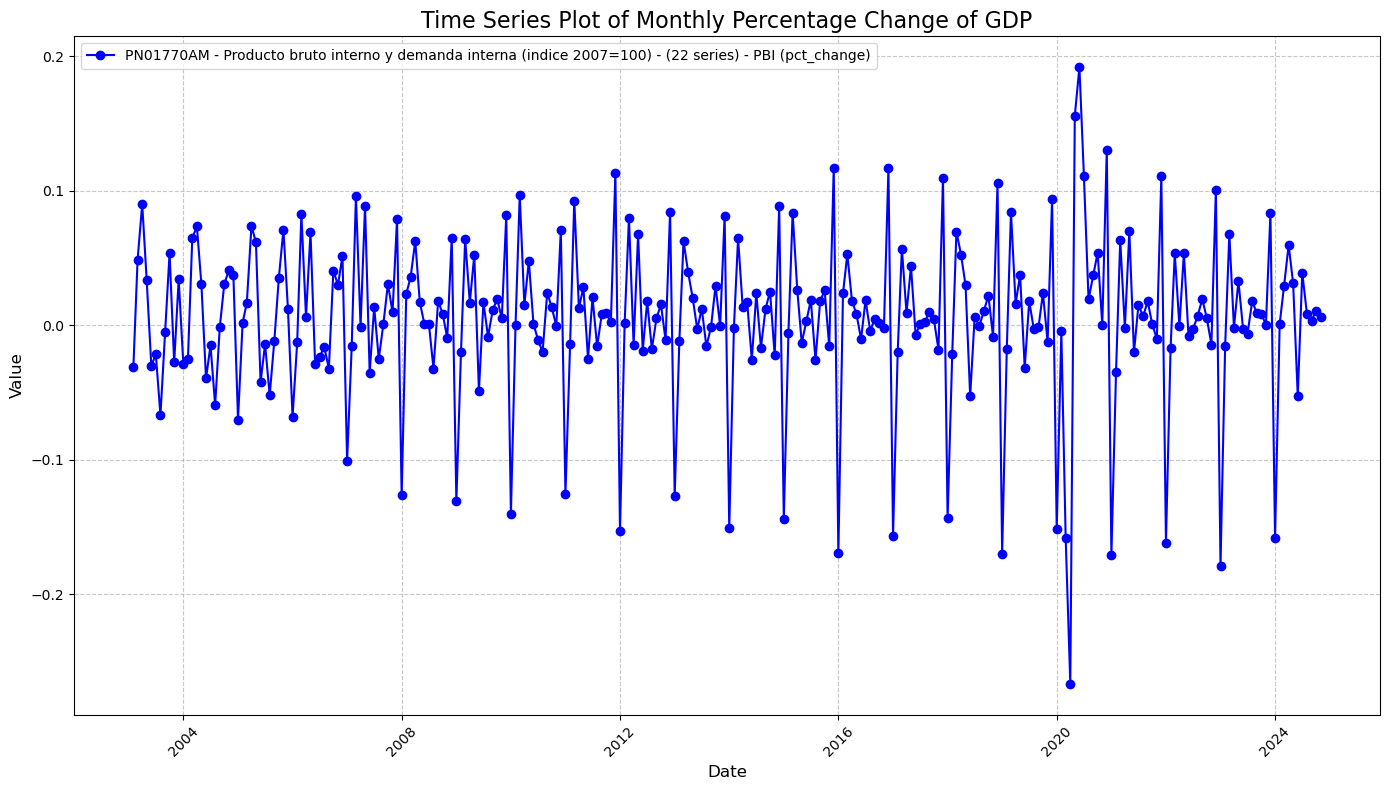

In [25]:
# Plotting the PBI column
plt.figure(figsize=(14, 8))
plt.plot(stationary_data.index, stationary_data[pbi_column_name], label=pbi_column_name, color='blue', linestyle='-', marker='o')

# Adding titles and labels
plt.title("Time Series Plot of Monthly Percentage Change of GDP", fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


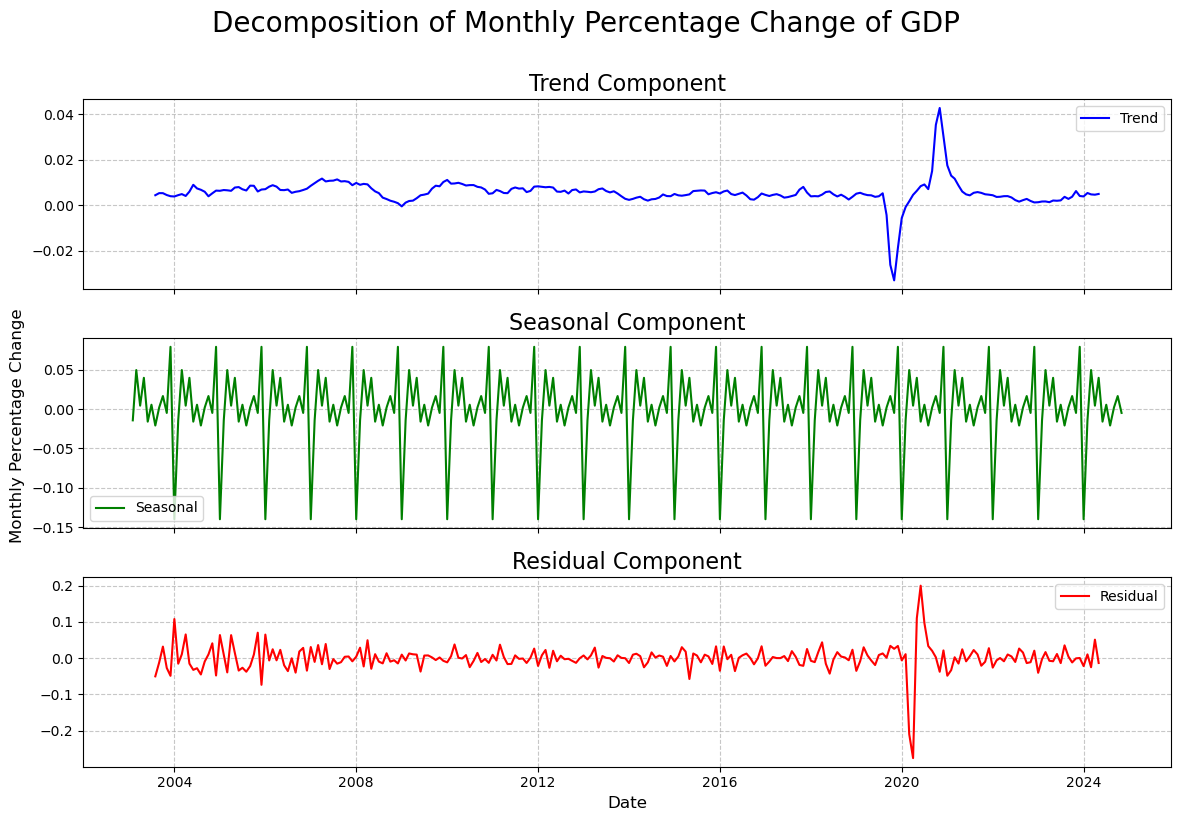

In [26]:
# Decomposing the time series
decomposition = seasonal_decompose(stationary_data[pbi_column_name], model='additive', period=12)
trend, seasonal, residual = decomposition.trend, decomposition.seasonal, decomposition.resid

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
components = [(trend, 'Trend', 'blue'), (seasonal, 'Seasonal', 'green'), (residual, 'Residual', 'red')]
for ax, (data, title, color) in zip(axes, components):
    ax.plot(data, label=title, color=color)
    ax.set_title(f'{title} Component', fontsize=16)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Set common labels
plt.xlabel('Date', fontsize=12)
fig.supylabel('Monthly Percentage Change', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("Decomposition of Monthly Percentage Change of GDP", fontsize=20, y=1.02)

# Save the figure without borders
for fmt in ['png', 'pdf']:
    plt.savefig(f'decomposition_gdp.{fmt}', bbox_inches='tight', pad_inches=0)

plt.show()


- The decomposed trend shows a noticeable dip around 2020, reflecting a significant shock, while the seasonal component displays a regular monthly cycle. RNN can capture these time‐dependent patterns by learning both short‐term fluctuations (including seasonality) and longer‐term shifts in the trend.

In [28]:
# Extract the Category Name from final data
extracted_parts = [col.split(' - ')[1] for col in stationary_data.columns]
df              = pd.DataFrame(extracted_parts, columns=['Category Name of Macroeconomic Variables'])
value_counts    = df['Category Name of Macroeconomic Variables'].value_counts()
cumulative_sums = value_counts.cumsum()
 
pd.set_option('display.max_rows', None)
print(value_counts)

Category Name of Macroeconomic Variables
Ingresos tributarios recaudados por SUNAT                                                                   78
Produccion manufacturera (indice 2007 = 100)                                                                61
Indicadores indirectos de la tasa de utilizacion de la capacidad instalada del sector manufacturero         60
Produccion de productos mineros segun departamentos                                                         59
Credito neto al sector publico de las sociedades creadoras de deposito                                      34
Sistema privado de pensiones                                                                                27
Afiliados activos del Sistema Privado de Pensiones por departamentos (numero)                               27
Ingresos corrientes del gobierno general (millones S/)                                                      23
Ingresos corrientes del gobierno general (millones de soles diciembre 2

/var/folders/fk/v7c5p8wn1knfy26l727g3py40000gn/T/ipykernel_24403/3620249831.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


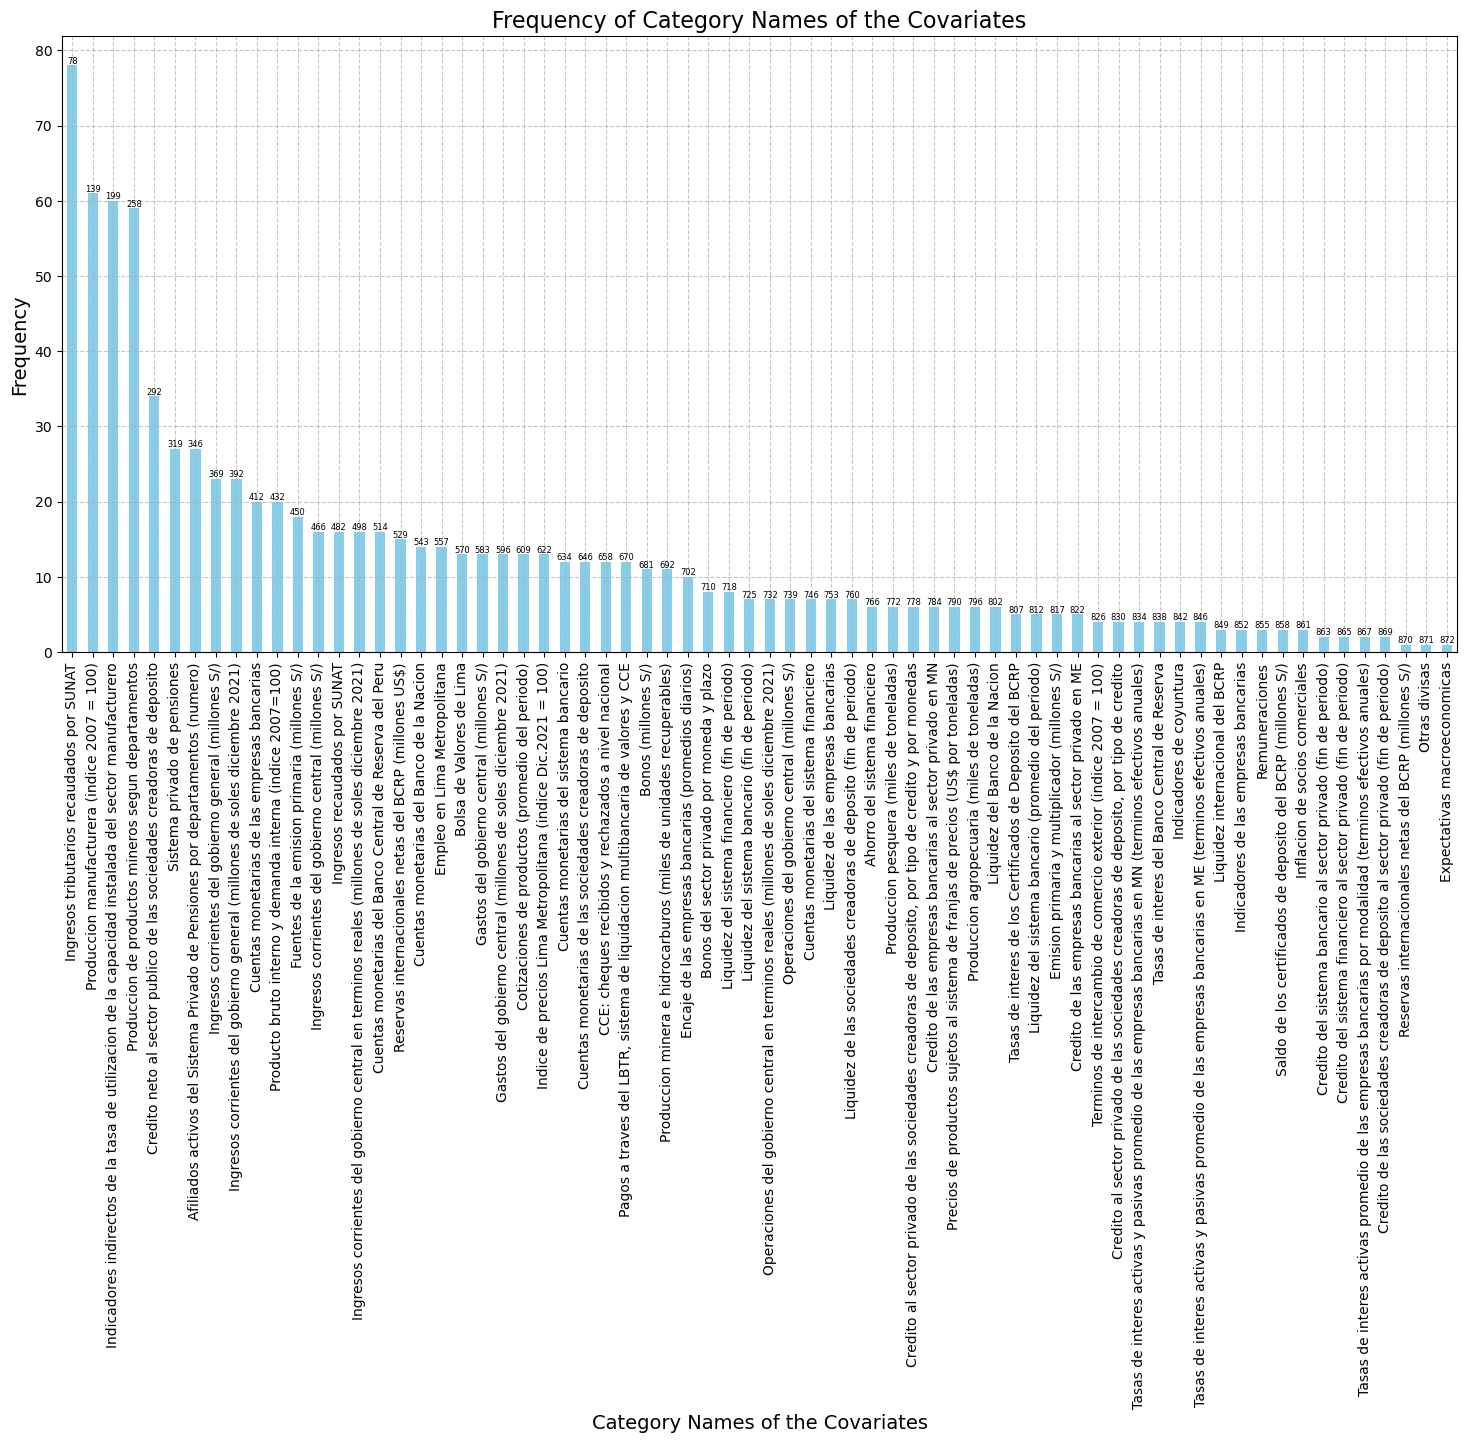

In [29]:

# Plot Category Name  Frequency in final data
plt.figure(figsize=(18, 8))
bars = value_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Category Names of the Covariates', fontsize=16)
plt.xlabel('Category Names of the Covariates', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate bars with cumulative sums
for bar, cumulative_sum in zip(bars.patches, cumulative_sums):
    bars.annotate(f'{cumulative_sum}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha='center', va='bottom', fontsize=6, color='black')

plt.show()


- Missing data on exchange rates as covariates


##  Model evaluation

In [32]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

mps


### Data Sequence Preparation


In [34]:
# =============================================================================
# CONSTANTS AND CONFIGURATION
# =============================================================================
def create_temporal_features(df: pd.DataFrame) -> (pd.DataFrame, int, int):
    df = df.copy()
    dt_index = df.index
    df['month'] = dt_index.month - 1  # Values from 0 to 11
    df['year'] = dt_index.year        # Absolute year
    min_year = df['year'].min()
    max_year = df['year'].max()
    df['year'] = df['year'] - min_year  # Transform to relative years (0,1,2,...)
    return df, min_year, max_year


In [35]:
# =============================================================================
# DATA PREPARATION (complete sequences of temporal features)
# =============================================================================

def create_temporal_features(df: pd.DataFrame) -> (pd.DataFrame, int, int):
    df = df.copy()
    dt_index = df.index
    df['month'] = dt_index.month - 1
    df['year'] = dt_index.year
    min_year = df['year'].min()
    max_year = df['year'].max()
    df['year'] = df['year'] - min_year
    return df, min_year, max_year

def prepare_temporal_data(data: pd.DataFrame, target_col: str, seq_length: int = 12, use_pca: bool = False, split_ratio: float = 0.85) -> tuple:
    """
    Prepares the data for training:
      1. Sorts the data chronologically.
      2. Adds temporal variables.
      3. Splits into training and validation according to split_ratio.
      4. Scales features and target.
      5. (Optional) Applies PCA.
      6. Creates sequences of length seq_length, extracting the complete sequence of 'month' and 'year'.
      7. Also returns the indices (dates) of each sequence.
    """
    
    if not data.index.is_monotonic_increasing:
        data = data.sort_index()
    
    df, min_year, max_year = create_temporal_features(data)
    dates = df.index
    split_idx = int(len(df) * split_ratio)
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
    train_dates = dates[:split_idx][seq_length:]
    test_dates = dates[split_idx:][seq_length:]
    
    feature_scaler = MinMaxScaler(feature_range=(-1, 1))
    target_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X_train_raw = train_df.drop(columns=[target_col])
    X_test_raw = test_df.drop(columns=[target_col])
    
    X_train = feature_scaler.fit_transform(X_train_raw)
    X_test = feature_scaler.transform(X_test_raw)
    
    if use_pca:
        pca = PCA(n_components=0.95, svd_solver='full')
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        print(f'PCA: {pca.n_components_} components | Explained Variance: {np.sum(pca.explained_variance_ratio_):.2%}')
    
    target_train = target_scaler.fit_transform(train_df[target_col].values.reshape(-1, 1)).flatten()
    target_test = target_scaler.transform(test_df[target_col].values.reshape(-1, 1)).flatten()
    
    def create_sequences(X, dates, target):
        sequences = []
        for i in range(seq_length, len(X)):
            X_window = X[i-seq_length:i]
            month_window = dates['month'].iloc[i-seq_length:i].values
            year_window = dates['year'].iloc[i-seq_length:i].values
            target_val = target[i]
            sequences.append((X_window, month_window, year_window, target_val))
        return sequences
    
    train_sequences = create_sequences(X_train, train_df, target_train)
    test_sequences = create_sequences(X_test, test_df, target_test)
    
    def to_tensor(data, dtype=torch.float32):
        return torch.tensor(data, dtype=dtype).to(DEVICE)
    
    X_train_tensor = to_tensor([s[0] for s in train_sequences])
    X_val_tensor = to_tensor([s[0] for s in test_sequences])
    month_train_tensor = to_tensor([s[1] for s in train_sequences], dtype=torch.long)
    month_val_tensor = to_tensor([s[1] for s in test_sequences], dtype=torch.long)
    year_train_tensor = to_tensor([s[2] for s in train_sequences], dtype=torch.long)
    year_val_tensor = to_tensor([s[2] for s in test_sequences], dtype=torch.long)
    target_train_tensor = to_tensor([s[3] for s in train_sequences]).float().unsqueeze(1)
    target_val_tensor = to_tensor([s[3] for s in test_sequences]).float().unsqueeze(1)
    
    return (X_train_tensor, X_val_tensor,
            month_train_tensor, month_val_tensor,
            year_train_tensor, year_val_tensor,
            target_train_tensor, target_val_tensor,
            target_scaler, min_year, max_year,
            train_dates, test_dates)


In [36]:
X_train, X_test, months_train, months_test, years_train, years_test, y_train, y_test, scaler, min_year, max_year, train_dates, test_dates = prepare_temporal_data(
    stationary_data, pbi_column_name, use_pca=False)

df_with_year_months, _, _ = create_temporal_features(stationary_data)

print(f"{'DataFrame Shape':<30}: {stationary_data.shape}")
print(f"{'DataFrame with Year and Month':<30}: {df_with_year_months.shape}\n")

print(f"{'X_train Shape':<30}: {X_train.shape}")
print(f"{'X_test Shape':<30}: {X_test.shape}")
print(f"{'y_train Shape':<30}: {y_train.shape}")
print(f"{'y_test Shape':<30}: {y_test.shape}\n")

print(f"{'Months_train Shape':<30}: {months_train.shape}")
print(f"{'Months_test Shape':<30}: {months_test.shape}")
print(f"{'Years_train Shape':<30}: {years_train.shape}")
print(f"{'Years_test Shape':<30}: {years_test.shape}\n")

print(f"{'Scaler':<30}: {scaler}\n")

print(f"{'Length of Train Dates':<30}: {len(train_dates)}")
print(f"{'Length of Test Dates':<30}: {len(test_dates)}\n")

print(f"{'Start Date of Data':<30}: {stationary_data.index[0]}")
print(f"{'End Date of Data':<30}: {stationary_data.index[-1]}")
print(f"{'Maximum Year':<30}: {max_year}")
print(f"{'Minimum Year':<30}: {min_year}\n")

print(f"{'Train Dates Shape':<30}: {train_dates.shape}")
print(f"{'Test Dates Shape':<30}: {test_dates.shape}\n")


DataFrame Shape               : (262, 872)
DataFrame with Year and Month : (262, 874)

X_train Shape                 : torch.Size([210, 12, 873])
X_test Shape                  : torch.Size([28, 12, 873])
y_train Shape                 : torch.Size([210, 1])
y_test Shape                  : torch.Size([28, 1])

Months_train Shape            : torch.Size([210, 12])
Months_test Shape             : torch.Size([28, 12])
Years_train Shape             : torch.Size([210, 12])
Years_test Shape              : torch.Size([28, 12])

Scaler                        : MinMaxScaler(feature_range=(-1, 1))

Length of Train Dates         : 210
Length of Test Dates          : 28

Start Date of Data            : 2003-02-01 00:00:00
End Date of Data              : 2024-11-01 00:00:00
Maximum Year                  : 2024
Minimum Year                  : 2003

Train Dates Shape             : (210,)
Test Dates Shape              : (28,)



/var/folders/fk/v7c5p8wn1knfy26l727g3py40000gn/T/ipykernel_24403/3045257300.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  return torch.tensor(data, dtype=dtype).to(DEVICE)


### Training and evaluation functions

In [38]:
# =============================================================================
# MODEL EVALUATION FUNCTION
# =============================================================================
def evaluate_model(model: nn.Module, X: torch.Tensor, months: torch.Tensor, 
                   years: torch.Tensor, target: torch.Tensor, scaler) -> dict:
    """
    Evaluates the model by calculating MAE, RMSE, MAPE, and R², reversing the scaling.
    """
    model.eval()
    with torch.no_grad():
        preds = model(X, months, years)
        preds_inv = scaler.inverse_transform(preds.cpu().numpy())
        target_inv = scaler.inverse_transform(target.cpu().numpy())
    
    return {
        'MAE': mean_absolute_error(target_inv, preds_inv),
        'RMSE': np.sqrt(mean_squared_error(target_inv, preds_inv)),
        'MAPE': np.mean(np.abs((target_inv - preds_inv) / target_inv)) * 100,
        'R2': r2_score(target_inv, preds_inv)
    }


# =============================================================================
# METRICS CALCULATION FUNCTION
# =============================================================================
def calculate_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred)/true)) * 100
    r2 = r2_score(true, pred)
    return [mae, rmse, mape, r2]

# =============================================================================
# PREDICTION AND EVALUATION FUNCTION
# =============================================================================
def predict_and_evaluate(model, X_train, X_test, months_train, months_test, years_train, years_test, y_train, y_test, scaler, train_dates, test_dates):
    with torch.no_grad():
        train_preds = scaler.inverse_transform(model(X_train, months_train, years_train).cpu().numpy()) # Predict and then denormalize
        test_preds = scaler.inverse_transform(model(X_test, months_test, years_test).cpu().numpy()) # Predict and then denormalize
    
    train_true = scaler.inverse_transform(y_train.cpu().numpy()) # Denormalize
    test_true  = scaler.inverse_transform(y_test.cpu().numpy()) # Denormalize
     
    metrics = pd.DataFrame({
        'Metric': ['MAE', 'RMSE', 'MAPE', 'R2'],
        'Train': calculate_metrics(train_true, train_preds),
        'Test': calculate_metrics(test_true, test_preds)
    })
    
    train_results = pd.DataFrame({'True': train_true.flatten(), 'Pred': train_preds.flatten()}, index=train_dates)
    test_results = pd.DataFrame({'True': test_true.flatten(), 'Pred': test_preds.flatten()}, index=test_dates)
    
    return metrics, train_results, test_results

# =============================================================================
# TRAINING AND HYPERPARAMETER SEARCH FUNCTION
# =============================================================================
def train_evaluate_all_models(model_class, hyperparams, 
                              X_train, X_val, 
                              month_train, month_val, 
                              year_train, year_val, 
                              target_train, target_val,
                              scaler, model_name, use_pca,
                              min_year, max_year, epochs=500, patience=15):
    try:
        valid_params = {k: v for k, v in hyperparams.items() if k in model_class.__init__.__code__.co_varnames}
        model = model_class(input_size=X_train.shape[2], min_year=min_year, max_year=max_year, **valid_params).to(DEVICE)
        optimizer = optim.AdamW(model.parameters(), lr=hyperparams.get('learning_rate', 0.001))
        criterion = nn.HuberLoss()
        best_loss = float('inf')
        patience_counter = 0
        train_losses = []
        val_losses = []
        best_weights = None
        
        train_dataset = TensorDataset(X_train, month_train, year_train, target_train)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        for epoch in tqdm(range(epochs), desc=f"Training {model_name}"):
            model.train()
            epoch_loss = 0
            for X_batch, month_batch, year_batch, target_batch in train_loader:
                optimizer.zero_grad()
                preds = model(X_batch, month_batch, year_batch)
                loss = criterion(preds, target_batch)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                epoch_loss += loss.item()
            model.eval()
            with torch.no_grad():
                val_preds = model(X_val, month_val, year_val)
                val_loss  = criterion(val_preds, target_val).item()
                
            if val_loss < best_loss:
                best_loss = val_loss
                best_weights = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} for {model_name}")
                break
            train_losses.append(epoch_loss / len(train_loader))
            val_losses.append(val_loss)
        if best_weights is not None:
            model.load_state_dict(best_weights)
        else:
            print(f"No improvements found during training of {model_name}.")
            
        train_metrics = evaluate_model(model, X_train, month_train, year_train, target_train, scaler)
        val_metrics   = evaluate_model(model, X_val, month_val, year_val, target_val, scaler)
        
        print(
            "Training completed for {}:\n"
            "Train: MAPE: {:>6.2f} | RMSE: {:>6.4f} | R²: {:>4.2f}\n"
            "Test:  MAPE: {:>6.2f} | RMSE: {:>6.4f} | R²: {:>4.2f}\n".format(
                model_name,
                train_metrics['MAPE'], train_metrics['RMSE'], train_metrics['R2'],
                val_metrics['MAPE'], val_metrics['RMSE'], val_metrics['R2']
            )
        )
        result_dict = {
            'model': f"{model_name} ({hyperparams})",
            'pca': use_pca,
            'train_MAE': train_metrics['MAE'],
            'test_MAE': val_metrics['MAE'],
            'train_RMSE': train_metrics['RMSE'],
            'test_RMSE': val_metrics['RMSE'],
            'train_MAPE': train_metrics['MAPE'],
            'test_MAPE': val_metrics['MAPE'],
            'train_R2': train_metrics['R2'],
            'test_R2': val_metrics['R2']
        }
        return result_dict
    except Exception as e:
        print(f"Error training {model_name}: {e}")
        return None



def run_hyperparameter_search(data: pd.DataFrame, target_col: str, n_iter: int) -> pd.DataFrame:
    results_all = []
    model_list = [
        ('LSTM_WithEmbeddings', LSTM_WithEmbeddings),
        ('GRU_WithEmbeddings', GRU_WithEmbeddings),
        ('GRU_LSTM_WithEmbeddings', GRU_LSTM_WithEmbeddings),
        ('CNN_RNN', CNN_RNN),
        ('RNN_Attention', RNN_Attention)
    ]
        
    for model_name, model_class in model_list:
        param_grid = HYPERPARAM_GRID[model_name]
        param_combinations = list(ParameterSampler(param_grid, n_iter=n_iter))
        for use_pca in [True, False]:
            print(f"\n{'='*60}\nProcessing {model_name} with PCA={use_pca}\n{'='*60}")
            
            # Start time tracking
            start_time = time.time()
            
            tensors = prepare_temporal_data(data, target_col, use_pca=use_pca)
            (X_train, X_val,
             month_train, month_val,
             year_train, year_val,
             target_train, target_val,
             scaler, min_year, max_year, train_dates, test_dates) = tensors
            
            for i, params in enumerate(param_combinations):
                print(f"\n{model_name} - Iteration {i+1} | Parameters: {params}")
                result = train_evaluate_all_models(
                    model_class, params,
                    X_train, X_val,
                    month_train, month_val,
                    year_train, year_val,
                    target_train, target_val,
                    scaler, model_name, use_pca,
                    min_year, max_year,
                    epochs=500, patience=15
                )
                if result:
                    result['execution_time'] = time.time() - start_time  # Calculate and store execution time
                    results_all.append(result)
            
            # End time tracking
            end_time = time.time()
            total_time = end_time - start_time
            print(f"Total time for {model_name} with PCA={use_pca}: {total_time:.2f} seconds")
    
    return pd.DataFrame(results_all)


### Model Architectures


In [40]:
# =============================================================================
# HELPER FUNCTION: Get Embedding or Empty Tensor
# =============================================================================
def get_embedding(embedding_layer, input_tensor, seq_len):
    """
    If the embedding layer is defined, returns its output (expanding if necessary).
    If not, returns an empty tensor of shape [batch, seq_len, 0].
    """
    if embedding_layer is None:
        return torch.zeros(input_tensor.size(0), seq_len, 0, device=input_tensor.device)
    else:
        # If the tensor already has dimension >1 (is already a sequence), use it directly.
        if input_tensor.dim() > 1:
            return embedding_layer(input_tensor)
        else:
            return embedding_layer(input_tensor).unsqueeze(1).expand(-1, seq_len, -1)

# =============================================================================
# DEFINITION OF RNN MODEL ARCHITECTURES WITH EMBEDDINGS 
# =============================================================================


class LSTM_WithEmbeddings(nn.Module):
    def __init__(self, input_size: int, min_year: int, max_year: int, 
                 lstm_layers: int = 1, lstm_units: int = 128, 
                 month_embedding_dim: int = 8, year_embedding_dim: int = 4, 
                 dropout: float = 0.3):
        super(LSTM_WithEmbeddings, self).__init__()
        
        self.month_embedding = nn.Embedding(12, month_embedding_dim) if month_embedding_dim > 0 else None
        self.year_embedding  = nn.Embedding(max_year - min_year + 1, year_embedding_dim) if year_embedding_dim > 0 else None
        extra_dim = (month_embedding_dim if month_embedding_dim > 0 else 0) + (year_embedding_dim if year_embedding_dim > 0 else 0)
        self.lstm = nn.LSTM(
            input_size + extra_dim,
            lstm_units,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )
        self.linear = nn.Sequential(
            nn.Linear(lstm_units, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x, month, year):
        seq_len = x.size(1)
        month_emb = get_embedding(self.month_embedding, month, seq_len)
        year_emb = get_embedding(self.year_embedding, year, seq_len)
        x = torch.cat([x, month_emb, year_emb], dim=-1)
        lstm_out, _ = self.lstm(x)
        return self.linear(lstm_out[:, -1, :])

class GRU_WithEmbeddings(nn.Module):
    def __init__(self, input_size: int, min_year: int, max_year: int, 
                 gru_layers: int = 1, gru_units: int = 128,
                 month_embedding_dim: int = 8, year_embedding_dim: int = 4, 
                 dropout: float = 0.3):
        super(GRU_WithEmbeddings, self).__init__()
        
        self.month_embedding = nn.Embedding(12, month_embedding_dim) if month_embedding_dim > 0 else None
        self.year_embedding  = nn.Embedding(max_year - min_year + 1, year_embedding_dim) if year_embedding_dim > 0 else None
        extra_dim = (month_embedding_dim if month_embedding_dim > 0 else 0) + (year_embedding_dim if year_embedding_dim > 0 else 0)
        self.gru = nn.GRU(
            input_size + extra_dim,
            gru_units,
            num_layers=gru_layers,
            batch_first=True,
            dropout=dropout if gru_layers > 1 else 0
        )
        self.fc = nn.Sequential(
            nn.Linear(gru_units, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x, month, year):
        seq_len = x.size(1)
        month_emb = get_embedding(self.month_embedding, month, seq_len)
        year_emb = get_embedding(self.year_embedding, year, seq_len)
        x = torch.cat([x, month_emb, year_emb], dim=-1)
        gru_out, _ = self.gru(x)
        return self.fc(gru_out[:, -1, :])

class GRU_LSTM_WithEmbeddings(nn.Module):
    def __init__(self, input_size: int, min_year: int, max_year: int,
                 gru_layers: int = 1, lstm_layers: int = 1,
                 gru_units: int = 128, lstm_units: int = 64, 
                 month_embedding_dim: int = 8, year_embedding_dim: int = 4, 
                 dropout: float = 0.3):
        super(GRU_LSTM_WithEmbeddings, self).__init__()
              
        self.month_embedding = nn.Embedding(12, month_embedding_dim) if month_embedding_dim > 0 else None
        self.year_embedding  = nn.Embedding(max_year - min_year + 1, year_embedding_dim) if year_embedding_dim > 0 else None
        extra_dim = (month_embedding_dim if month_embedding_dim > 0 else 0) + (year_embedding_dim if year_embedding_dim > 0 else 0)
        self.gru = nn.GRU(
            input_size + extra_dim,
            gru_units,
            num_layers=gru_layers,
            batch_first=True,
            dropout=dropout if gru_layers > 1 else 0
        )
        self.lstm = nn.LSTM(
            gru_units,
            lstm_units,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )
        self.fc = nn.Linear(lstm_units, 1)
        
    def forward(self, x, month, year):
        seq_len = x.size(1)
        month_emb = get_embedding(self.month_embedding, month, seq_len)
        year_emb = get_embedding(self.year_embedding, year, seq_len)
        x = torch.cat([x, month_emb, year_emb], dim=-1)
        gru_out, _ = self.gru(x)
        lstm_out, _ = self.lstm(gru_out)
        return self.fc(lstm_out[:, -1, :])

class CNN_RNN(nn.Module):
    def __init__(self, input_size, 
                 cnn_channels: list, 
                 kernel_sizes: list, 
                 cnn_dropout: float,
                 rnn_type: str = 'LSTM', 
                 rnn_units: int = 128, 
                 rnn_layers: int = 1, 
                 rnn_dropout: float = 0.0,
                 month_embedding_dim: int = 0, 
                 year_embedding_dim: int = 0, 
                 min_year: int = 2003, 
                 max_year: int = 2024,
                 fc_units: int = 64):
        
        super(CNN_RNN, self).__init__()
        self.cnn_layers = nn.ModuleList()
        prev_channels = input_size
        for out_channels, k_size in zip(cnn_channels, kernel_sizes):
            self.cnn_layers.append(
                nn.Sequential(
                    nn.Conv1d(in_channels=prev_channels, out_channels=out_channels, kernel_size=k_size, padding=k_size//2),
                    nn.ReLU(),
                    nn.Dropout(cnn_dropout)
                )
            )
            prev_channels = out_channels
        self.rnn_type = rnn_type.upper()
        extra_dim = (month_embedding_dim if month_embedding_dim > 0 else 0) + (year_embedding_dim if year_embedding_dim > 0 else 0)
        rnn_input_dim = prev_channels + extra_dim
        if self.rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=rnn_input_dim,
                               hidden_size=rnn_units,
                               num_layers=rnn_layers,
                               batch_first=True,
                               dropout=rnn_dropout if rnn_layers > 1 else 0)
        elif self.rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=rnn_input_dim,
                              hidden_size=rnn_units,
                              num_layers=rnn_layers,
                              batch_first=True,
                              dropout=rnn_dropout if rnn_layers > 1 else 0)
        else:
            raise ValueError("rnn_type must be 'LSTM' or 'GRU'")
        self.month_embedding = nn.Embedding(12, month_embedding_dim) if month_embedding_dim > 0 else None
        self.year_embedding = nn.Embedding(max_year - min_year + 1, year_embedding_dim) if year_embedding_dim > 0 else None
        self.fc = nn.Sequential(
            nn.Linear(rnn_units, fc_units),
            nn.ReLU(),
            nn.Linear(fc_units, 1)
        )
        
    def forward(self, x, month, year):
        batch_size, seq_len, _ = x.size()
        x = x.transpose(1, 2)  # Para la CNN: (batch, features, seq_len)
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.transpose(1, 2)  # Volver a (batch, seq_len, features)
        # Construir la lista de embeddings activos
        embeddings = []
        if self.month_embedding is not None:
            if month.dim() == 1:
                month_emb = self.month_embedding(month).unsqueeze(1).expand(-1, seq_len, -1)
            else:
                month_emb = self.month_embedding(month)
            embeddings.append(month_emb)
        if self.year_embedding is not None:
            if year.dim() == 1:
                year_emb = self.year_embedding(year).unsqueeze(1).expand(-1, seq_len, -1)
            else:
                year_emb = self.year_embedding(year)
            embeddings.append(year_emb)
        if embeddings:
            emb_concat = torch.cat(embeddings, dim=-1)
            x = torch.cat([x, emb_concat], dim=-1)
        if self.rnn_type == 'LSTM':
            _, (h_n, _) = self.rnn(x)
        else:
            _, h_n = self.rnn(x)
        return self.fc(h_n[-1])

class RNN_Attention(nn.Module):
    def __init__(self, input_size,
                 rnn_type: str = 'LSTM',
                 rnn_units: int = 128,
                 rnn_layers: int = 1,
                 rnn_dropout: float = 0.0,
                 attention_size: int = 64,
                 month_embedding_dim: int = 0,
                 year_embedding_dim: int = 0,
                 min_year: int = 2003,
                 max_year: int = 2024,
                 fc_units: int = 64):
        super(RNN_Attention, self).__init__()
        self.rnn_type = rnn_type.upper()
        extra_dim = (month_embedding_dim if month_embedding_dim > 0 else 0) + (year_embedding_dim if year_embedding_dim > 0 else 0)
        rnn_input_dim = input_size + extra_dim
        if self.rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=rnn_input_dim,
                               hidden_size=rnn_units,
                               num_layers=rnn_layers,
                               batch_first=True,
                               dropout=rnn_dropout if rnn_layers > 1 else 0)
        elif self.rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=rnn_input_dim,
                              hidden_size=rnn_units,
                              num_layers=rnn_layers,
                              batch_first=True,
                              dropout=rnn_dropout if rnn_layers > 1 else 0)
        else:
            raise ValueError("rnn_type must be 'LSTM' or 'GRU'")
        self.attention_layer = nn.Sequential(
            nn.Linear(rnn_units, attention_size),
            nn.Tanh(),
            nn.Linear(attention_size, 1)
        )
        self.month_embedding = nn.Embedding(12, month_embedding_dim) if month_embedding_dim > 0 else None
        self.year_embedding = nn.Embedding(max_year - min_year + 1, year_embedding_dim) if year_embedding_dim > 0 else None
        self.fc = nn.Sequential(
            nn.Linear(rnn_units, fc_units),
            nn.ReLU(),
            nn.Linear(fc_units, 1)
        )
        
    def forward(self, x, month, year):
        seq_len = x.size(1)
        embeddings = []
        if self.month_embedding is not None:
            if month.dim() == 1:
                month_emb = self.month_embedding(month).unsqueeze(1).expand(-1, seq_len, -1)
            else:
                month_emb = self.month_embedding(month)
            embeddings.append(month_emb)
        if self.year_embedding is not None:
            if year.dim() == 1:
                year_emb = self.year_embedding(year).unsqueeze(1).expand(-1, seq_len, -1)
            else:
                year_emb = self.year_embedding(year)
            embeddings.append(year_emb)
        if embeddings:
            emb_concat = torch.cat(embeddings, dim=-1)
            x = torch.cat([x, emb_concat], dim=-1)
        if self.rnn_type == 'LSTM':
            rnn_out, _ = self.rnn(x)
        else:
            rnn_out, _ = self.rnn(x)
        attn_scores = self.attention_layer(rnn_out)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * rnn_out, dim=1)
        return self.fc(context)



### Hyperparameter Search

In [42]:
# =============================================================================
#  HYPERPARAMETER SPACE 
# =============================================================================
HYPERPARAM_GRID = {
    'LSTM_WithEmbeddings': {
        'lstm_layers': [1, 2, 3, 4],
        'lstm_units': [64, 128, 256, 512],
        'month_embedding_dim': [0, 4, 6, 8, 10],
        'year_embedding_dim': [0, 4, 6, 8, 10],
        'dropout': [0.1, 0.2, 0.3, 0.4, 0.5]
    },
    'GRU_WithEmbeddings': {
        'gru_layers': [1, 2, 3, 4],
        'gru_units': [64, 128, 256, 512],
        'month_embedding_dim': [0, 4, 6, 8, 10],
        'year_embedding_dim': [0, 4, 6, 8, 10],
        'dropout': [0.1, 0.2, 0.3, 0.4, 0.5]
    },
    'GRU_LSTM_WithEmbeddings': {
        'gru_layers': [1, 2, 3, 4],
        'lstm_layers': [1, 2, 3, 4],
        'gru_units': [64, 128, 256, 512],
        'lstm_units': [64, 128, 256, 512],
        'month_embedding_dim': [0, 4, 6, 8, 10],
        'year_embedding_dim': [0, 4, 6, 8, 10],
        'dropout': [0.1, 0.2, 0.3, 0.4, 0.5]
    },
    'CNN_RNN': {
        'cnn_channels': [[32, 64], [64, 64], [128, 64], [128, 128], [256, 128]],
        'kernel_sizes': [[3, 3], [5, 3], [3, 5], [5, 5]],
        'cnn_dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
        'rnn_type': ['LSTM', 'GRU'],
        'rnn_units': [64, 128, 256, 512],
        'rnn_layers': [1, 2, 3, 4],
        'rnn_dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
        'month_embedding_dim': [0, 4, 6, 8, 10],
        'year_embedding_dim': [0, 4, 6, 8, 10],
        'fc_units': [32, 64, 128]
    },
    'RNN_Attention': {
        'rnn_type': ['LSTM', 'GRU'],
        'rnn_units': [64, 128, 256, 512],
        'rnn_layers': [1, 2, 3, 4],
        'rnn_dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
        'attention_size': [16, 32, 64, 128],
        'month_embedding_dim': [0, 4, 6, 8, 10],
        'year_embedding_dim': [0, 4, 6, 8, 10],
        'fc_units': [32, 64, 128]
    }
}

In [43]:
SEQ_LENGTH = 12      # For example, 12 months
SPLIT_RATIO = 0.85   # Default value (not used in CV)
BATCH_SIZE = 32
PATIENCE = 15

In [44]:
# =============================================================================
# MAIN EXECUTION BLOCK
# =============================================================================
if __name__ == "__main__":
    def set_seed(seed: int):
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    set_seed(42)
    
    # Execute hyperparameter search  
    results_df = run_hyperparameter_search(stationary_data, pbi_column_name, n_iter=40)
    final_columns = ['model', 'pca', 'train_MAE', 'test_MAE', 'train_RMSE', 'test_RMSE', 'train_MAPE', 'test_MAPE', 'train_R2', 'test_R2', 'execution_time']
    final_results = results_df[final_columns].sort_values(by=['test_RMSE', 'test_MAE'], ascending=[True, True])



Processing LSTM_WithEmbeddings with PCA=True
PCA: 122 components | Explained Variance: 95.08%

LSTM_WithEmbeddings - Iteration 1 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 6, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.5}


Training LSTM_WithEmbeddings:  26%|██▊        | 129/500 [00:09<00:27, 13.50it/s]


Early stopping at epoch 130 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  45.86 | RMSE: 0.0044 | R²: 1.00
Test:  MAPE: 275.06 | RMSE: 0.0339 | R²: 0.64


LSTM_WithEmbeddings - Iteration 2 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 4, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   3%|▎           | 15/500 [00:01<00:41, 11.77it/s]


Early stopping at epoch 16 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 773.80 | RMSE: 0.0734 | R²: -0.36
Test:  MAPE: 996.94 | RMSE: 0.0761 | R²: -0.79


LSTM_WithEmbeddings - Iteration 3 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   9%|█           | 44/500 [00:02<00:24, 18.24it/s]


Early stopping at epoch 45 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 177.49 | RMSE: 0.0148 | R²: 0.95
Test:  MAPE: 497.77 | RMSE: 0.0418 | R²: 0.46


LSTM_WithEmbeddings - Iteration 4 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'lstm_units': 64, 'lstm_layers': 2, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  28%|███        | 139/500 [00:06<00:16, 21.98it/s]


Early stopping at epoch 140 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 116.75 | RMSE: 0.0182 | R²: 0.92
Test:  MAPE: 250.52 | RMSE: 0.0448 | R²: 0.38


LSTM_WithEmbeddings - Iteration 5 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 6, 'lstm_units': 512, 'lstm_layers': 1, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   4%|▌           | 21/500 [00:01<00:37, 12.80it/s]


Early stopping at epoch 22 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  18.32 | RMSE: 0.0014 | R²: 1.00
Test:  MAPE: 784.18 | RMSE: 0.0655 | R²: -0.33


LSTM_WithEmbeddings - Iteration 6 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 1, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   4%|▍           | 18/500 [00:00<00:25, 18.59it/s]


Early stopping at epoch 19 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  31.47 | RMSE: 0.0023 | R²: 1.00
Test:  MAPE: 769.16 | RMSE: 0.0598 | R²: -0.11


LSTM_WithEmbeddings - Iteration 7 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 6, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  17%|██          | 84/500 [00:04<00:21, 19.07it/s]


Early stopping at epoch 85 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 194.25 | RMSE: 0.0217 | R²: 0.88
Test:  MAPE: 286.22 | RMSE: 0.0445 | R²: 0.39


LSTM_WithEmbeddings - Iteration 8 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 4, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.5}


Training LSTM_WithEmbeddings:  22%|██▍        | 110/500 [00:05<00:20, 19.01it/s]


Early stopping at epoch 111 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  47.56 | RMSE: 0.0049 | R²: 0.99
Test:  MAPE: 250.59 | RMSE: 0.0404 | R²: 0.50


LSTM_WithEmbeddings - Iteration 9 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 8, 'lstm_units': 256, 'lstm_layers': 1, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   4%|▍           | 18/500 [00:00<00:25, 19.15it/s]


Early stopping at epoch 19 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  23.49 | RMSE: 0.0020 | R²: 1.00
Test:  MAPE: 1733.43 | RMSE: 0.1140 | R²: -3.01


LSTM_WithEmbeddings - Iteration 10 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 10, 'lstm_units': 64, 'lstm_layers': 2, 'dropout': 0.4}


Training LSTM_WithEmbeddings:  32%|███▍       | 159/500 [00:07<00:16, 20.60it/s]


Early stopping at epoch 160 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  74.53 | RMSE: 0.0078 | R²: 0.98
Test:  MAPE: 318.71 | RMSE: 0.0391 | R²: 0.53


LSTM_WithEmbeddings - Iteration 11 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 4, 'lstm_units': 256, 'lstm_layers': 1, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   3%|▍           | 17/500 [00:00<00:25, 19.22it/s]


Early stopping at epoch 18 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  56.60 | RMSE: 0.0034 | R²: 1.00
Test:  MAPE: 957.25 | RMSE: 0.0811 | R²: -1.03


LSTM_WithEmbeddings - Iteration 12 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'lstm_units': 512, 'lstm_layers': 1, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   4%|▍           | 19/500 [00:01<00:36, 13.24it/s]


Early stopping at epoch 20 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  43.31 | RMSE: 0.0031 | R²: 1.00
Test:  MAPE: 849.64 | RMSE: 0.0687 | R²: -0.46


LSTM_WithEmbeddings - Iteration 13 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 8, 'lstm_units': 64, 'lstm_layers': 4, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  27%|███        | 137/500 [00:09<00:24, 15.10it/s]


Early stopping at epoch 138 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 101.91 | RMSE: 0.0302 | R²: 0.77
Test:  MAPE: 172.21 | RMSE: 0.0411 | R²: 0.48


LSTM_WithEmbeddings - Iteration 14 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'lstm_units': 512, 'lstm_layers': 2, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   4%|▌           | 22/500 [00:02<00:46, 10.19it/s]


Early stopping at epoch 23 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 152.99 | RMSE: 0.0383 | R²: 0.63
Test:  MAPE: 376.42 | RMSE: 0.0548 | R²: 0.07


LSTM_WithEmbeddings - Iteration 15 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 4, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   8%|▉           | 41/500 [00:03<00:36, 12.58it/s]


Early stopping at epoch 42 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 184.31 | RMSE: 0.0634 | R²: -0.01
Test:  MAPE: 303.94 | RMSE: 0.0590 | R²: -0.08


LSTM_WithEmbeddings - Iteration 16 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 3, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   4%|▍           | 20/500 [00:02<01:10,  6.82it/s]


Early stopping at epoch 21 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 344.30 | RMSE: 0.0641 | R²: -0.04
Test:  MAPE: 500.65 | RMSE: 0.0626 | R²: -0.21


LSTM_WithEmbeddings - Iteration 17 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'lstm_units': 128, 'lstm_layers': 4, 'dropout': 0.2}


Training LSTM_WithEmbeddings:  59%|██████▍    | 295/500 [00:24<00:16, 12.10it/s]


Early stopping at epoch 296 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 180.37 | RMSE: 0.0535 | R²: 0.28
Test:  MAPE: 152.87 | RMSE: 0.0536 | R²: 0.11


LSTM_WithEmbeddings - Iteration 18 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   7%|▊           | 34/500 [00:02<00:27, 16.87it/s]


Early stopping at epoch 35 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 368.35 | RMSE: 0.0500 | R²: 0.37
Test:  MAPE: 510.46 | RMSE: 0.0650 | R²: -0.31


LSTM_WithEmbeddings - Iteration 19 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'lstm_units': 128, 'lstm_layers': 1, 'dropout': 0.5}


Training LSTM_WithEmbeddings:   4%|▍           | 18/500 [00:00<00:20, 23.23it/s]


Early stopping at epoch 19 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  11.51 | RMSE: 0.0015 | R²: 1.00
Test:  MAPE: 914.68 | RMSE: 0.0622 | R²: -0.19


LSTM_WithEmbeddings - Iteration 20 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.5}


Training LSTM_WithEmbeddings:   4%|▍           | 20/500 [00:01<00:37, 12.96it/s]


Early stopping at epoch 21 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  93.88 | RMSE: 0.0095 | R²: 0.98
Test:  MAPE: 610.72 | RMSE: 0.0557 | R²: 0.04


LSTM_WithEmbeddings - Iteration 21 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   5%|▋           | 27/500 [00:02<00:40, 11.57it/s]


Early stopping at epoch 28 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 472.72 | RMSE: 0.0587 | R²: 0.13
Test:  MAPE: 378.48 | RMSE: 0.0561 | R²: 0.03


LSTM_WithEmbeddings - Iteration 22 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 6, 'lstm_units': 256, 'lstm_layers': 1, 'dropout': 0.5}


Training LSTM_WithEmbeddings:   5%|▌           | 23/500 [00:01<00:26, 18.31it/s]


Early stopping at epoch 24 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  11.51 | RMSE: 0.0009 | R²: 1.00
Test:  MAPE: 541.71 | RMSE: 0.0631 | R²: -0.23


LSTM_WithEmbeddings - Iteration 23 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 4, 'lstm_units': 512, 'lstm_layers': 4, 'dropout': 0.5}


Training LSTM_WithEmbeddings:  18%|██▏         | 92/500 [00:17<01:16,  5.30it/s]


Early stopping at epoch 93 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  54.53 | RMSE: 0.0037 | R²: 1.00
Test:  MAPE: 472.68 | RMSE: 0.0386 | R²: 0.54


LSTM_WithEmbeddings - Iteration 24 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'lstm_units': 512, 'lstm_layers': 3, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  23%|██▌        | 115/500 [00:15<00:52,  7.31it/s]


Early stopping at epoch 116 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 182.28 | RMSE: 0.0425 | R²: 0.54
Test:  MAPE: 280.40 | RMSE: 0.0484 | R²: 0.28


LSTM_WithEmbeddings - Iteration 25 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 64, 'lstm_layers': 4, 'dropout': 0.5}


Training LSTM_WithEmbeddings:  13%|█▌          | 65/500 [00:04<00:29, 14.78it/s]


Early stopping at epoch 66 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 203.47 | RMSE: 0.0131 | R²: 0.96
Test:  MAPE: 446.76 | RMSE: 0.0357 | R²: 0.61


LSTM_WithEmbeddings - Iteration 26 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 512, 'lstm_layers': 1, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   3%|▍           | 17/500 [00:01<00:34, 13.94it/s]


Early stopping at epoch 18 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  58.35 | RMSE: 0.0032 | R²: 1.00
Test:  MAPE: 1071.33 | RMSE: 0.0735 | R²: -0.67


LSTM_WithEmbeddings - Iteration 27 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 4, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  20%|██▏        | 102/500 [00:18<01:11,  5.57it/s]


Early stopping at epoch 103 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 127.99 | RMSE: 0.0468 | R²: 0.45
Test:  MAPE: 146.86 | RMSE: 0.0526 | R²: 0.15


LSTM_WithEmbeddings - Iteration 28 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 6, 'lstm_units': 256, 'lstm_layers': 2, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  32%|███▍       | 159/500 [00:09<00:21, 16.19it/s]


Early stopping at epoch 160 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  61.69 | RMSE: 0.0118 | R²: 0.96
Test:  MAPE: 314.92 | RMSE: 0.0397 | R²: 0.51


LSTM_WithEmbeddings - Iteration 29 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'lstm_units': 512, 'lstm_layers': 4, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   3%|▎           | 15/500 [00:02<01:34,  5.13it/s]


Early stopping at epoch 16 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 388.87 | RMSE: 0.0640 | R²: -0.03
Test:  MAPE: 384.91 | RMSE: 0.0591 | R²: -0.08


LSTM_WithEmbeddings - Iteration 30 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 1, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   3%|▍           | 17/500 [00:00<00:18, 25.55it/s]


Early stopping at epoch 18 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  14.07 | RMSE: 0.0017 | R²: 1.00
Test:  MAPE: 740.07 | RMSE: 0.0936 | R²: -1.71


LSTM_WithEmbeddings - Iteration 31 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 3, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   6%|▋           | 30/500 [00:01<00:28, 16.73it/s]


Early stopping at epoch 31 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 294.91 | RMSE: 0.0547 | R²: 0.24
Test:  MAPE: 456.76 | RMSE: 0.0582 | R²: -0.05


LSTM_WithEmbeddings - Iteration 32 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  47%|█████▏     | 234/500 [00:12<00:13, 19.49it/s]


Early stopping at epoch 235 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  59.63 | RMSE: 0.0135 | R²: 0.95
Test:  MAPE: 152.04 | RMSE: 0.0374 | R²: 0.57


LSTM_WithEmbeddings - Iteration 33 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 2, 'dropout': 0.2}


Training LSTM_WithEmbeddings:  15%|█▊          | 75/500 [00:04<00:27, 15.38it/s]


Early stopping at epoch 76 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 160.49 | RMSE: 0.0277 | R²: 0.81
Test:  MAPE: 395.43 | RMSE: 0.0477 | R²: 0.30


LSTM_WithEmbeddings - Iteration 34 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'lstm_units': 64, 'lstm_layers': 2, 'dropout': 0.3}


Training LSTM_WithEmbeddings:   3%|▎           | 15/500 [00:00<00:25, 19.38it/s]


Early stopping at epoch 16 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 241.80 | RMSE: 0.0387 | R²: 0.62
Test:  MAPE: 575.23 | RMSE: 0.0686 | R²: -0.45


LSTM_WithEmbeddings - Iteration 35 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'lstm_units': 512, 'lstm_layers': 3, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  11%|█▎          | 55/500 [00:07<01:00,  7.35it/s]


Early stopping at epoch 56 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 192.07 | RMSE: 0.0423 | R²: 0.55
Test:  MAPE: 326.89 | RMSE: 0.0510 | R²: 0.20


LSTM_WithEmbeddings - Iteration 36 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 1, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   4%|▍           | 20/500 [00:00<00:19, 24.33it/s]


Early stopping at epoch 21 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  59.13 | RMSE: 0.0035 | R²: 1.00
Test:  MAPE: 588.31 | RMSE: 0.0576 | R²: -0.02


LSTM_WithEmbeddings - Iteration 37 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'lstm_units': 64, 'lstm_layers': 1, 'dropout': 0.5}


Training LSTM_WithEmbeddings:   3%|▍           | 17/500 [00:00<00:19, 24.20it/s]


Early stopping at epoch 18 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  20.36 | RMSE: 0.0022 | R²: 1.00
Test:  MAPE: 761.78 | RMSE: 0.0772 | R²: -0.84


LSTM_WithEmbeddings - Iteration 38 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 8, 'lstm_units': 512, 'lstm_layers': 1, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   4%|▌           | 21/500 [00:01<00:34, 14.07it/s]


Early stopping at epoch 22 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  31.05 | RMSE: 0.0016 | R²: 1.00
Test:  MAPE: 808.04 | RMSE: 0.0607 | R²: -0.14


LSTM_WithEmbeddings - Iteration 39 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 3, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  17%|█▉          | 83/500 [00:11<00:57,  7.31it/s]


Early stopping at epoch 84 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 193.87 | RMSE: 0.0418 | R²: 0.56
Test:  MAPE: 262.01 | RMSE: 0.0489 | R²: 0.26


LSTM_WithEmbeddings - Iteration 40 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   4%|▍           | 18/500 [00:01<00:32, 14.70it/s]


Early stopping at epoch 19 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 303.46 | RMSE: 0.0625 | R²: 0.01
Test:  MAPE: 540.27 | RMSE: 0.0640 | R²: -0.27

Total time for LSTM_WithEmbeddings with PCA=True: 208.46 seconds

Processing LSTM_WithEmbeddings with PCA=False

LSTM_WithEmbeddings - Iteration 1 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 6, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.5}


Training LSTM_WithEmbeddings:   8%|▉           | 39/500 [00:02<00:33, 13.85it/s]


Early stopping at epoch 40 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 160.30 | RMSE: 0.0159 | R²: 0.94
Test:  MAPE: 538.83 | RMSE: 0.0474 | R²: 0.31


LSTM_WithEmbeddings - Iteration 2 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 4, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   3%|▍           | 16/500 [00:01<00:43, 11.21it/s]


Early stopping at epoch 17 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 165.35 | RMSE: 0.0640 | R²: -0.03
Test:  MAPE: 163.31 | RMSE: 0.0577 | R²: -0.03


LSTM_WithEmbeddings - Iteration 3 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   5%|▌           | 23/500 [00:01<00:29, 15.92it/s]


Early stopping at epoch 24 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 178.75 | RMSE: 0.0196 | R²: 0.90
Test:  MAPE: 688.88 | RMSE: 0.0688 | R²: -0.46


LSTM_WithEmbeddings - Iteration 4 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'lstm_units': 64, 'lstm_layers': 2, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  17%|██          | 84/500 [00:04<00:24, 17.24it/s]


Early stopping at epoch 85 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 100.57 | RMSE: 0.0126 | R²: 0.96
Test:  MAPE: 334.28 | RMSE: 0.0509 | R²: 0.20


LSTM_WithEmbeddings - Iteration 5 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 6, 'lstm_units': 512, 'lstm_layers': 1, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   4%|▍           | 20/500 [00:02<00:52,  9.11it/s]


Early stopping at epoch 21 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 109.10 | RMSE: 0.0093 | R²: 0.98
Test:  MAPE: 988.22 | RMSE: 0.0758 | R²: -0.78


LSTM_WithEmbeddings - Iteration 6 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 1, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   4%|▍           | 19/500 [00:01<00:28, 16.78it/s]


Early stopping at epoch 20 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 150.57 | RMSE: 0.0104 | R²: 0.97
Test:  MAPE: 806.49 | RMSE: 0.0671 | R²: -0.39


LSTM_WithEmbeddings - Iteration 7 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 6, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  10%|█▏          | 50/500 [00:02<00:26, 17.10it/s]


Early stopping at epoch 51 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 198.94 | RMSE: 0.0214 | R²: 0.88
Test:  MAPE: 248.89 | RMSE: 0.0459 | R²: 0.35


LSTM_WithEmbeddings - Iteration 8 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 4, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.5}


Training LSTM_WithEmbeddings:   5%|▋           | 27/500 [00:01<00:27, 17.38it/s]


Early stopping at epoch 28 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 161.63 | RMSE: 0.0156 | R²: 0.94
Test:  MAPE: 887.05 | RMSE: 0.0762 | R²: -0.79


LSTM_WithEmbeddings - Iteration 9 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 8, 'lstm_units': 256, 'lstm_layers': 1, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   4%|▌           | 21/500 [00:01<00:30, 15.88it/s]


Early stopping at epoch 22 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  87.03 | RMSE: 0.0077 | R²: 0.99
Test:  MAPE: 750.55 | RMSE: 0.0672 | R²: -0.39


LSTM_WithEmbeddings - Iteration 10 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 10, 'lstm_units': 64, 'lstm_layers': 2, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   6%|▋           | 29/500 [00:01<00:24, 19.07it/s]


Early stopping at epoch 30 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 120.84 | RMSE: 0.0134 | R²: 0.95
Test:  MAPE: 699.21 | RMSE: 0.0530 | R²: 0.13


LSTM_WithEmbeddings - Iteration 11 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 4, 'lstm_units': 256, 'lstm_layers': 1, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   4%|▍           | 20/500 [00:01<00:27, 17.64it/s]


Early stopping at epoch 21 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 100.92 | RMSE: 0.0087 | R²: 0.98
Test:  MAPE: 1204.75 | RMSE: 0.0769 | R²: -0.83


LSTM_WithEmbeddings - Iteration 12 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'lstm_units': 512, 'lstm_layers': 1, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   4%|▌           | 21/500 [00:01<00:38, 12.47it/s]


Early stopping at epoch 22 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 153.97 | RMSE: 0.0103 | R²: 0.97
Test:  MAPE: 1057.87 | RMSE: 0.0860 | R²: -1.28


LSTM_WithEmbeddings - Iteration 13 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 8, 'lstm_units': 64, 'lstm_layers': 4, 'dropout': 0.3}


Training LSTM_WithEmbeddings:   4%|▌           | 22/500 [00:01<00:37, 12.79it/s]


Early stopping at epoch 23 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 755.38 | RMSE: 0.0741 | R²: -0.38
Test:  MAPE: 1058.43 | RMSE: 0.0765 | R²: -0.81


LSTM_WithEmbeddings - Iteration 14 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'lstm_units': 512, 'lstm_layers': 2, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   5%|▌           | 24/500 [00:03<00:59,  7.98it/s]


Early stopping at epoch 25 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 183.70 | RMSE: 0.0336 | R²: 0.72
Test:  MAPE: 847.64 | RMSE: 0.0669 | R²: -0.38


LSTM_WithEmbeddings - Iteration 15 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 4, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   3%|▍           | 16/500 [00:01<00:43, 11.24it/s]


Early stopping at epoch 17 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 336.94 | RMSE: 0.0639 | R²: -0.03
Test:  MAPE: 307.96 | RMSE: 0.0584 | R²: -0.05


LSTM_WithEmbeddings - Iteration 16 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 3, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   8%|▉           | 39/500 [00:06<01:17,  5.94it/s]


Early stopping at epoch 40 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 537.55 | RMSE: 0.0659 | R²: -0.10
Test:  MAPE: 695.06 | RMSE: 0.0668 | R²: -0.38


LSTM_WithEmbeddings - Iteration 17 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'lstm_units': 128, 'lstm_layers': 4, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   3%|▍           | 16/500 [00:01<00:38, 12.68it/s]


Early stopping at epoch 17 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 330.11 | RMSE: 0.0637 | R²: -0.02
Test:  MAPE: 266.01 | RMSE: 0.0578 | R²: -0.03


LSTM_WithEmbeddings - Iteration 18 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   4%|▍           | 20/500 [00:01<00:26, 17.99it/s]


Early stopping at epoch 21 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 375.14 | RMSE: 0.0528 | R²: 0.30
Test:  MAPE: 892.37 | RMSE: 0.0705 | R²: -0.54


LSTM_WithEmbeddings - Iteration 19 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'lstm_units': 128, 'lstm_layers': 1, 'dropout': 0.5}


Training LSTM_WithEmbeddings:   4%|▍           | 18/500 [00:00<00:26, 18.32it/s]


Early stopping at epoch 19 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  93.84 | RMSE: 0.0097 | R²: 0.98
Test:  MAPE: 1196.93 | RMSE: 0.0996 | R²: -2.06


LSTM_WithEmbeddings - Iteration 20 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.5}


Training LSTM_WithEmbeddings:  13%|█▌          | 66/500 [00:04<00:30, 14.29it/s]


Early stopping at epoch 67 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  66.54 | RMSE: 0.0063 | R²: 0.99
Test:  MAPE: 408.34 | RMSE: 0.0466 | R²: 0.33


LSTM_WithEmbeddings - Iteration 21 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   4%|▌           | 22/500 [00:01<00:35, 13.30it/s]


Early stopping at epoch 23 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 448.79 | RMSE: 0.0606 | R²: 0.07
Test:  MAPE: 616.31 | RMSE: 0.0634 | R²: -0.24


LSTM_WithEmbeddings - Iteration 22 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 6, 'lstm_units': 256, 'lstm_layers': 1, 'dropout': 0.5}


Training LSTM_WithEmbeddings:   5%|▌           | 24/500 [00:01<00:27, 17.55it/s]


Early stopping at epoch 25 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  89.31 | RMSE: 0.0063 | R²: 0.99
Test:  MAPE: 831.95 | RMSE: 0.0795 | R²: -0.95


LSTM_WithEmbeddings - Iteration 23 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 4, 'lstm_units': 512, 'lstm_layers': 4, 'dropout': 0.5}


Training LSTM_WithEmbeddings:   8%|▉           | 40/500 [00:08<01:36,  4.74it/s]


Early stopping at epoch 41 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 231.69 | RMSE: 0.0631 | R²: -0.00
Test:  MAPE: 204.82 | RMSE: 0.0573 | R²: -0.01


LSTM_WithEmbeddings - Iteration 24 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'lstm_units': 512, 'lstm_layers': 3, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  13%|█▌          | 67/500 [00:11<01:12,  5.95it/s]


Early stopping at epoch 68 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  98.99 | RMSE: 0.0260 | R²: 0.83
Test:  MAPE: 524.63 | RMSE: 0.0538 | R²: 0.11


LSTM_WithEmbeddings - Iteration 25 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 64, 'lstm_layers': 4, 'dropout': 0.5}


Training LSTM_WithEmbeddings:  11%|█▎          | 55/500 [00:03<00:30, 14.51it/s]


Early stopping at epoch 56 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 309.17 | RMSE: 0.0225 | R²: 0.87
Test:  MAPE: 369.87 | RMSE: 0.0464 | R²: 0.34


LSTM_WithEmbeddings - Iteration 26 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 512, 'lstm_layers': 1, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   4%|▍           | 20/500 [00:01<00:40, 11.86it/s]


Early stopping at epoch 21 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 167.34 | RMSE: 0.0102 | R²: 0.97
Test:  MAPE: 905.08 | RMSE: 0.0709 | R²: -0.55


LSTM_WithEmbeddings - Iteration 27 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 4, 'dropout': 0.3}


Training LSTM_WithEmbeddings:   7%|▊           | 35/500 [00:08<01:49,  4.23it/s]


Early stopping at epoch 36 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 177.07 | RMSE: 0.0629 | R²: -0.00
Test:  MAPE: 149.17 | RMSE: 0.0570 | R²: -0.00


LSTM_WithEmbeddings - Iteration 28 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 6, 'lstm_units': 256, 'lstm_layers': 2, 'dropout': 0.3}


Training LSTM_WithEmbeddings:   7%|▊           | 34/500 [00:03<00:45, 10.21it/s]


Early stopping at epoch 35 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 172.36 | RMSE: 0.0246 | R²: 0.85
Test:  MAPE: 788.55 | RMSE: 0.0587 | R²: -0.06


LSTM_WithEmbeddings - Iteration 29 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'lstm_units': 512, 'lstm_layers': 4, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   5%|▋           | 27/500 [00:06<01:46,  4.43it/s]


Early stopping at epoch 28 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 168.24 | RMSE: 0.0629 | R²: -0.00
Test:  MAPE: 141.52 | RMSE: 0.0570 | R²: -0.00


LSTM_WithEmbeddings - Iteration 30 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 1, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   4%|▍           | 19/500 [00:00<00:24, 19.69it/s]


Early stopping at epoch 20 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 101.77 | RMSE: 0.0087 | R²: 0.98
Test:  MAPE: 1040.94 | RMSE: 0.0842 | R²: -1.19


LSTM_WithEmbeddings - Iteration 31 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 3, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   8%|▉           | 41/500 [00:02<00:30, 15.22it/s]


Early stopping at epoch 42 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 409.04 | RMSE: 0.0556 | R²: 0.22
Test:  MAPE: 499.88 | RMSE: 0.0633 | R²: -0.24


LSTM_WithEmbeddings - Iteration 32 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.3}


Training LSTM_WithEmbeddings:   6%|▋           | 29/500 [00:01<00:27, 16.95it/s]


Early stopping at epoch 30 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 115.80 | RMSE: 0.0232 | R²: 0.86
Test:  MAPE: 448.36 | RMSE: 0.0499 | R²: 0.23


LSTM_WithEmbeddings - Iteration 33 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 2, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   4%|▌           | 21/500 [00:01<00:34, 14.05it/s]


Early stopping at epoch 22 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 186.00 | RMSE: 0.0434 | R²: 0.53
Test:  MAPE: 533.43 | RMSE: 0.0587 | R²: -0.06


LSTM_WithEmbeddings - Iteration 34 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'lstm_units': 64, 'lstm_layers': 2, 'dropout': 0.3}


Training LSTM_WithEmbeddings:   5%|▌           | 25/500 [00:01<00:26, 18.24it/s]


Early stopping at epoch 26 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 208.93 | RMSE: 0.0256 | R²: 0.84
Test:  MAPE: 468.55 | RMSE: 0.0582 | R²: -0.05


LSTM_WithEmbeddings - Iteration 35 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'lstm_units': 512, 'lstm_layers': 3, 'dropout': 0.3}


Training LSTM_WithEmbeddings:  13%|█▌          | 65/500 [00:10<01:12,  6.01it/s]


Early stopping at epoch 66 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  83.47 | RMSE: 0.0318 | R²: 0.74
Test:  MAPE: 376.14 | RMSE: 0.0527 | R²: 0.14


LSTM_WithEmbeddings - Iteration 36 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 1, 'dropout': 0.2}


Training LSTM_WithEmbeddings:   5%|▌           | 23/500 [00:00<00:19, 24.21it/s]


Early stopping at epoch 24 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 132.50 | RMSE: 0.0132 | R²: 0.96
Test:  MAPE: 820.47 | RMSE: 0.0652 | R²: -0.31


LSTM_WithEmbeddings - Iteration 37 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'lstm_units': 64, 'lstm_layers': 1, 'dropout': 0.5}


Training LSTM_WithEmbeddings:   4%|▍           | 20/500 [00:00<00:20, 23.26it/s]


Early stopping at epoch 21 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE:  89.43 | RMSE: 0.0051 | R²: 0.99
Test:  MAPE: 790.57 | RMSE: 0.0538 | R²: 0.11


LSTM_WithEmbeddings - Iteration 38 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 8, 'lstm_units': 512, 'lstm_layers': 1, 'dropout': 0.4}


Training LSTM_WithEmbeddings:   4%|▍           | 19/500 [00:01<00:44, 10.80it/s]


Early stopping at epoch 20 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 151.93 | RMSE: 0.0162 | R²: 0.93
Test:  MAPE: 1462.64 | RMSE: 0.0888 | R²: -1.43


LSTM_WithEmbeddings - Iteration 39 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 3, 'dropout': 0.3}


Training LSTM_WithEmbeddings:   3%|▍           | 17/500 [00:02<01:24,  5.71it/s]


Early stopping at epoch 18 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 181.10 | RMSE: 0.0629 | R²: 0.00
Test:  MAPE: 151.40 | RMSE: 0.0570 | R²: -0.00


LSTM_WithEmbeddings - Iteration 40 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.1}


Training LSTM_WithEmbeddings:   4%|▍           | 19/500 [00:01<00:35, 13.52it/s]


Early stopping at epoch 20 for LSTM_WithEmbeddings
Training completed for LSTM_WithEmbeddings:
Train: MAPE: 269.35 | RMSE: 0.0621 | R²: 0.03
Test:  MAPE: 547.26 | RMSE: 0.0628 | R²: -0.22

Total time for LSTM_WithEmbeddings with PCA=False: 119.54 seconds

Processing GRU_WithEmbeddings with PCA=True
PCA: 122 components | Explained Variance: 95.08%

GRU_WithEmbeddings - Iteration 1 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'gru_units': 128, 'gru_layers': 3, 'dropout': 0.5}


Training GRU_WithEmbeddings:   4%|▍            | 18/500 [00:05<02:25,  3.32it/s]


Early stopping at epoch 19 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 383.21 | RMSE: 0.0362 | R²: 0.67
Test:  MAPE: 906.99 | RMSE: 0.0723 | R²: -0.61


GRU_WithEmbeddings - Iteration 2 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.2}


Training GRU_WithEmbeddings:   3%|▍            | 15/500 [00:01<00:56,  8.63it/s]


Early stopping at epoch 16 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  36.21 | RMSE: 0.0028 | R²: 1.00
Test:  MAPE: 1450.17 | RMSE: 0.0996 | R²: -2.06


GRU_WithEmbeddings - Iteration 3 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 6, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.4}


Training GRU_WithEmbeddings:   6%|▊            | 32/500 [00:10<02:32,  3.06it/s]


Early stopping at epoch 33 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 487.53 | RMSE: 0.0290 | R²: 0.79
Test:  MAPE: 924.04 | RMSE: 0.0734 | R²: -0.66


GRU_WithEmbeddings - Iteration 4 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 6, 'gru_units': 256, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_WithEmbeddings:   3%|▍            | 17/500 [00:02<01:00,  8.04it/s]


Early stopping at epoch 18 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  66.59 | RMSE: 0.0029 | R²: 1.00
Test:  MAPE: 1698.18 | RMSE: 0.0849 | R²: -1.23


GRU_WithEmbeddings - Iteration 5 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'gru_units': 256, 'gru_layers': 3, 'dropout': 0.5}


Training GRU_WithEmbeddings:  15%|█▉           | 76/500 [00:21<02:00,  3.52it/s]

Early stopping at epoch 77 for GRU_WithEmbeddings


Training completed for GRU_WithEmbeddings:
Train: MAPE:  96.75 | RMSE: 0.0063 | R²: 0.99
Test:  MAPE: 384.33 | RMSE: 0.0428 | R²: 0.43


GRU_WithEmbeddings - Iteration 6 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 10, 'gru_units': 256, 'gru_layers': 1, 'dropout': 0.1}


Training GRU_WithEmbeddings:   5%|▋            | 27/500 [00:03<00:58,  8.09it/s]


Early stopping at epoch 28 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:   3.56 | RMSE: 0.0003 | R²: 1.00
Test:  MAPE: 738.64 | RMSE: 0.0515 | R²: 0.18


GRU_WithEmbeddings - Iteration 7 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'gru_units': 64, 'gru_layers': 3, 'dropout': 0.3}


Training GRU_WithEmbeddings:   8%|█            | 42/500 [00:10<01:56,  3.93it/s]


Early stopping at epoch 43 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 157.03 | RMSE: 0.0136 | R²: 0.95
Test:  MAPE: 422.90 | RMSE: 0.0479 | R²: 0.29


GRU_WithEmbeddings - Iteration 8 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_WithEmbeddings:   3%|▍            | 15/500 [00:02<01:27,  5.52it/s]


Early stopping at epoch 16 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 288.32 | RMSE: 0.0285 | R²: 0.79
Test:  MAPE: 450.88 | RMSE: 0.0653 | R²: -0.32


GRU_WithEmbeddings - Iteration 9 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_WithEmbeddings:   3%|▍            | 17/500 [00:04<02:21,  3.40it/s]

Early stopping at epoch 18 for GRU_WithEmbeddings


Training completed for GRU_WithEmbeddings:
Train: MAPE: 351.25 | RMSE: 0.0283 | R²: 0.80
Test:  MAPE: 756.52 | RMSE: 0.0831 | R²: -1.13


GRU_WithEmbeddings - Iteration 10 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'gru_units': 128, 'gru_layers': 1, 'dropout': 0.4}


Training GRU_WithEmbeddings:   4%|▍            | 19/500 [00:02<00:54,  8.78it/s]


Early stopping at epoch 20 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  18.76 | RMSE: 0.0020 | R²: 1.00
Test:  MAPE: 724.31 | RMSE: 0.0764 | R²: -0.80


GRU_WithEmbeddings - Iteration 11 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'gru_units': 512, 'gru_layers': 2, 'dropout': 0.2}


Training GRU_WithEmbeddings:   5%|▌            | 24/500 [00:05<01:51,  4.26it/s]


Early stopping at epoch 25 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  85.90 | RMSE: 0.0059 | R²: 0.99
Test:  MAPE: 821.12 | RMSE: 0.0645 | R²: -0.28


GRU_WithEmbeddings - Iteration 12 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.4}


Training GRU_WithEmbeddings:   4%|▍            | 19/500 [00:02<00:54,  8.87it/s]


Early stopping at epoch 20 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  30.45 | RMSE: 0.0023 | R²: 1.00
Test:  MAPE: 1014.94 | RMSE: 0.0775 | R²: -0.86


GRU_WithEmbeddings - Iteration 13 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_WithEmbeddings:   7%|▊            | 33/500 [00:12<02:52,  2.71it/s]


Early stopping at epoch 34 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 153.60 | RMSE: 0.0104 | R²: 0.97
Test:  MAPE: 882.74 | RMSE: 0.0668 | R²: -0.38


GRU_WithEmbeddings - Iteration 14 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_WithEmbeddings:   6%|▋            | 28/500 [00:05<01:32,  5.10it/s]


Early stopping at epoch 29 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 117.37 | RMSE: 0.0099 | R²: 0.98
Test:  MAPE: 566.89 | RMSE: 0.0560 | R²: 0.03


GRU_WithEmbeddings - Iteration 15 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'gru_units': 128, 'gru_layers': 3, 'dropout': 0.5}


Training GRU_WithEmbeddings:  28%|███▎        | 139/500 [00:36<01:34,  3.82it/s]

Early stopping at epoch 140 for GRU_WithEmbeddings


Training completed for GRU_WithEmbeddings:
Train: MAPE:  81.42 | RMSE: 0.0060 | R²: 0.99
Test:  MAPE: 396.05 | RMSE: 0.0396 | R²: 0.52


GRU_WithEmbeddings - Iteration 16 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.1}


Training GRU_WithEmbeddings:   3%|▍            | 17/500 [00:03<01:29,  5.39it/s]


Early stopping at epoch 18 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 176.31 | RMSE: 0.0142 | R²: 0.95
Test:  MAPE: 1436.94 | RMSE: 0.0882 | R²: -1.40


GRU_WithEmbeddings - Iteration 17 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 10, 'gru_units': 512, 'gru_layers': 3, 'dropout': 0.3}


Training GRU_WithEmbeddings:   5%|▋            | 27/500 [00:08<02:21,  3.34it/s]


Early stopping at epoch 28 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 101.24 | RMSE: 0.0060 | R²: 0.99
Test:  MAPE: 733.91 | RMSE: 0.0602 | R²: -0.12


GRU_WithEmbeddings - Iteration 18 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 8, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.3}


Training GRU_WithEmbeddings:   4%|▌            | 20/500 [00:03<01:34,  5.06it/s]


Early stopping at epoch 21 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 177.80 | RMSE: 0.0117 | R²: 0.97
Test:  MAPE: 840.92 | RMSE: 0.0624 | R²: -0.20


GRU_WithEmbeddings - Iteration 19 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.4}


Training GRU_WithEmbeddings:  12%|█▌           | 60/500 [00:10<01:18,  5.63it/s]


Early stopping at epoch 61 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 110.72 | RMSE: 0.0090 | R²: 0.98
Test:  MAPE: 422.07 | RMSE: 0.0438 | R²: 0.41


GRU_WithEmbeddings - Iteration 20 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_WithEmbeddings:  13%|█▋           | 64/500 [00:23<02:39,  2.73it/s]


Early stopping at epoch 65 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  96.78 | RMSE: 0.0095 | R²: 0.98
Test:  MAPE: 482.91 | RMSE: 0.0459 | R²: 0.35


GRU_WithEmbeddings - Iteration 21 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_WithEmbeddings:   7%|▉            | 36/500 [00:07<01:32,  5.03it/s]


Early stopping at epoch 37 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 193.63 | RMSE: 0.0129 | R²: 0.96
Test:  MAPE: 516.48 | RMSE: 0.0443 | R²: 0.39


GRU_WithEmbeddings - Iteration 22 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 8, 'gru_units': 256, 'gru_layers': 3, 'dropout': 0.5}


Training GRU_WithEmbeddings:   5%|▋            | 25/500 [00:07<02:20,  3.37it/s]


Early stopping at epoch 26 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 150.70 | RMSE: 0.0162 | R²: 0.93
Test:  MAPE: 914.52 | RMSE: 0.0671 | R²: -0.39


GRU_WithEmbeddings - Iteration 23 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 6, 'gru_units': 256, 'gru_layers': 3, 'dropout': 0.5}


Training GRU_WithEmbeddings:  16%|██▏          | 82/500 [00:22<01:55,  3.62it/s]

Early stopping at epoch 83 for GRU_WithEmbeddings


Training completed for GRU_WithEmbeddings:
Train: MAPE: 119.78 | RMSE: 0.0067 | R²: 0.99
Test:  MAPE: 567.41 | RMSE: 0.0442 | R²: 0.40


GRU_WithEmbeddings - Iteration 24 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.4}


Training GRU_WithEmbeddings:   5%|▋            | 25/500 [00:04<01:33,  5.09it/s]


Early stopping at epoch 26 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 181.43 | RMSE: 0.0120 | R²: 0.96
Test:  MAPE: 659.31 | RMSE: 0.0499 | R²: 0.23


GRU_WithEmbeddings - Iteration 25 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'gru_units': 128, 'gru_layers': 3, 'dropout': 0.4}


Training GRU_WithEmbeddings:   7%|▉            | 34/500 [00:09<02:09,  3.59it/s]


Early stopping at epoch 35 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 215.69 | RMSE: 0.0128 | R²: 0.96
Test:  MAPE: 788.95 | RMSE: 0.0541 | R²: 0.10


GRU_WithEmbeddings - Iteration 26 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'gru_units': 128, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_WithEmbeddings:   3%|▍            | 17/500 [00:02<00:57,  8.44it/s]


Early stopping at epoch 18 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  35.16 | RMSE: 0.0026 | R²: 1.00
Test:  MAPE: 1229.31 | RMSE: 0.0813 | R²: -1.04


GRU_WithEmbeddings - Iteration 27 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'gru_units': 128, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_WithEmbeddings:   6%|▊            | 30/500 [00:08<02:10,  3.60it/s]

Early stopping at epoch 31 for GRU_WithEmbeddings


Training completed for GRU_WithEmbeddings:
Train: MAPE: 112.10 | RMSE: 0.0104 | R²: 0.97
Test:  MAPE: 677.50 | RMSE: 0.0541 | R²: 0.10


GRU_WithEmbeddings - Iteration 28 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_WithEmbeddings:   3%|▍            | 17/500 [00:01<00:55,  8.78it/s]


Early stopping at epoch 18 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  14.54 | RMSE: 0.0010 | R²: 1.00
Test:  MAPE: 557.14 | RMSE: 0.0666 | R²: -0.37


GRU_WithEmbeddings - Iteration 29 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_WithEmbeddings:  25%|██▉         | 123/500 [00:45<02:19,  2.70it/s]

Early stopping at epoch 124 for GRU_WithEmbeddings


Training completed for GRU_WithEmbeddings:
Train: MAPE:  33.79 | RMSE: 0.0029 | R²: 1.00
Test:  MAPE: 448.60 | RMSE: 0.0413 | R²: 0.47


GRU_WithEmbeddings - Iteration 30 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 0, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.2}


Training GRU_WithEmbeddings:   5%|▋            | 27/500 [00:04<01:24,  5.58it/s]


Early stopping at epoch 28 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 220.14 | RMSE: 0.0165 | R²: 0.93
Test:  MAPE: 658.19 | RMSE: 0.0562 | R²: 0.02


GRU_WithEmbeddings - Iteration 31 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 6, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.3}


Training GRU_WithEmbeddings:   3%|▍            | 16/500 [00:02<01:30,  5.34it/s]


Early stopping at epoch 17 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 133.90 | RMSE: 0.0145 | R²: 0.95
Test:  MAPE: 631.43 | RMSE: 0.0642 | R²: -0.27


GRU_WithEmbeddings - Iteration 32 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'gru_units': 512, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_WithEmbeddings:   5%|▌            | 23/500 [00:04<01:39,  4.81it/s]


Early stopping at epoch 24 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 157.79 | RMSE: 0.0121 | R²: 0.96
Test:  MAPE: 928.51 | RMSE: 0.0856 | R²: -1.26


GRU_WithEmbeddings - Iteration 33 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 8, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.1}


Training GRU_WithEmbeddings:   4%|▌            | 21/500 [00:04<01:32,  5.20it/s]


Early stopping at epoch 22 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  78.58 | RMSE: 0.0073 | R²: 0.99
Test:  MAPE: 938.94 | RMSE: 0.0721 | R²: -0.60


GRU_WithEmbeddings - Iteration 34 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'gru_units': 512, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_WithEmbeddings:   4%|▌            | 21/500 [00:04<01:40,  4.78it/s]


Early stopping at epoch 22 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 151.89 | RMSE: 0.0099 | R²: 0.98
Test:  MAPE: 877.42 | RMSE: 0.0643 | R²: -0.28


GRU_WithEmbeddings - Iteration 35 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 10, 'gru_units': 128, 'gru_layers': 1, 'dropout': 0.4}


Training GRU_WithEmbeddings:   4%|▍            | 18/500 [00:02<00:55,  8.69it/s]


Early stopping at epoch 19 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  13.66 | RMSE: 0.0011 | R²: 1.00
Test:  MAPE: 740.64 | RMSE: 0.0636 | R²: -0.25


GRU_WithEmbeddings - Iteration 36 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'gru_units': 128, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_WithEmbeddings:   7%|▊            | 33/500 [00:11<02:40,  2.91it/s]


Early stopping at epoch 34 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 218.98 | RMSE: 0.0108 | R²: 0.97
Test:  MAPE: 407.45 | RMSE: 0.0438 | R²: 0.41


GRU_WithEmbeddings - Iteration 37 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.4}


Training GRU_WithEmbeddings:   4%|▍            | 19/500 [00:03<01:40,  4.78it/s]


Early stopping at epoch 20 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 437.44 | RMSE: 0.0197 | R²: 0.90
Test:  MAPE: 861.11 | RMSE: 0.0595 | R²: -0.09


GRU_WithEmbeddings - Iteration 38 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 10, 'gru_units': 128, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_WithEmbeddings:   8%|▉            | 38/500 [00:13<02:45,  2.80it/s]

Early stopping at epoch 39 for GRU_WithEmbeddings


Training completed for GRU_WithEmbeddings:
Train: MAPE: 195.58 | RMSE: 0.0103 | R²: 0.97
Test:  MAPE: 613.74 | RMSE: 0.0530 | R²: 0.13


GRU_WithEmbeddings - Iteration 39 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_WithEmbeddings:   3%|▍            | 17/500 [00:05<02:46,  2.90it/s]


Early stopping at epoch 18 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 446.28 | RMSE: 0.0334 | R²: 0.72
Test:  MAPE: 1150.19 | RMSE: 0.0636 | R²: -0.25


GRU_WithEmbeddings - Iteration 40 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 8, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_WithEmbeddings:   4%|▍            | 19/500 [00:06<02:43,  2.94it/s]

Early stopping at epoch 20 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 215.57 | RMSE: 0.0553 | R²: 0.23
Test:  MAPE: 593.62 | RMSE: 0.0705 | R²: -0.53

Total time for GRU_WithEmbeddings with PCA=True: 354.63 seconds

Processing GRU_WithEmbeddings with PCA=False



GRU_WithEmbeddings - Iteration 1 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'gru_units': 128, 'gru_layers': 3, 'dropout': 0.5}


Training GRU_WithEmbeddings:   7%|▊            | 33/500 [00:09<02:10,  3.57it/s]


Early stopping at epoch 34 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 168.55 | RMSE: 0.0250 | R²: 0.84
Test:  MAPE: 634.04 | RMSE: 0.0599 | R²: -0.11


GRU_WithEmbeddings - Iteration 2 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.2}


Training GRU_WithEmbeddings:   3%|▍            | 17/500 [00:02<01:04,  7.45it/s]


Early stopping at epoch 18 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 101.77 | RMSE: 0.0070 | R²: 0.99
Test:  MAPE: 1803.06 | RMSE: 0.0874 | R²: -1.36


GRU_WithEmbeddings - Iteration 3 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 6, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.4}


Training GRU_WithEmbeddings:   7%|▉            | 36/500 [00:11<02:31,  3.07it/s]


Early stopping at epoch 37 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 204.20 | RMSE: 0.0239 | R²: 0.86
Test:  MAPE: 1429.74 | RMSE: 0.1133 | R²: -2.96


GRU_WithEmbeddings - Iteration 4 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 6, 'gru_units': 256, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_WithEmbeddings:   3%|▍            | 17/500 [00:02<00:58,  8.26it/s]


Early stopping at epoch 18 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 321.17 | RMSE: 0.0218 | R²: 0.88
Test:  MAPE: 1518.56 | RMSE: 0.0824 | R²: -1.10


GRU_WithEmbeddings - Iteration 5 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'gru_units': 256, 'gru_layers': 3, 'dropout': 0.5}


Training GRU_WithEmbeddings:   7%|▉            | 36/500 [00:10<02:11,  3.52it/s]


Early stopping at epoch 37 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 183.26 | RMSE: 0.0145 | R²: 0.95
Test:  MAPE: 683.65 | RMSE: 0.0562 | R²: 0.02


GRU_WithEmbeddings - Iteration 6 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 10, 'gru_units': 256, 'gru_layers': 1, 'dropout': 0.1}


Training GRU_WithEmbeddings:   5%|▋            | 25/500 [00:02<00:54,  8.69it/s]


Early stopping at epoch 26 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  72.27 | RMSE: 0.0051 | R²: 0.99
Test:  MAPE: 719.45 | RMSE: 0.0605 | R²: -0.13


GRU_WithEmbeddings - Iteration 7 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'gru_units': 64, 'gru_layers': 3, 'dropout': 0.3}


Training GRU_WithEmbeddings:   6%|▊            | 29/500 [00:08<02:11,  3.57it/s]


Early stopping at epoch 30 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 323.02 | RMSE: 0.0191 | R²: 0.91
Test:  MAPE: 536.71 | RMSE: 0.0559 | R²: 0.04


GRU_WithEmbeddings - Iteration 8 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_WithEmbeddings:   6%|▋            | 28/500 [00:05<01:29,  5.26it/s]


Early stopping at epoch 29 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 244.84 | RMSE: 0.0211 | R²: 0.89
Test:  MAPE: 657.32 | RMSE: 0.0537 | R²: 0.11


GRU_WithEmbeddings - Iteration 9 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_WithEmbeddings:   6%|▊            | 32/500 [00:08<02:02,  3.83it/s]


Early stopping at epoch 33 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 134.83 | RMSE: 0.0149 | R²: 0.94
Test:  MAPE: 783.11 | RMSE: 0.0848 | R²: -1.22


GRU_WithEmbeddings - Iteration 10 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'gru_units': 128, 'gru_layers': 1, 'dropout': 0.4}


Training GRU_WithEmbeddings:   3%|▍            | 17/500 [00:02<00:57,  8.43it/s]


Early stopping at epoch 18 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 117.44 | RMSE: 0.0082 | R²: 0.98
Test:  MAPE: 1193.76 | RMSE: 0.1006 | R²: -2.12


GRU_WithEmbeddings - Iteration 11 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'gru_units': 512, 'gru_layers': 2, 'dropout': 0.2}


Training GRU_WithEmbeddings:   6%|▊            | 30/500 [00:07<01:52,  4.18it/s]


Early stopping at epoch 31 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  74.55 | RMSE: 0.0102 | R²: 0.97
Test:  MAPE: 946.89 | RMSE: 0.0735 | R²: -0.67


GRU_WithEmbeddings - Iteration 12 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.4}


Training GRU_WithEmbeddings:   4%|▍            | 19/500 [00:02<00:54,  8.77it/s]


Early stopping at epoch 20 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  68.21 | RMSE: 0.0051 | R²: 0.99
Test:  MAPE: 890.97 | RMSE: 0.0857 | R²: -1.26


GRU_WithEmbeddings - Iteration 13 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_WithEmbeddings:  10%|█▎           | 50/500 [00:18<02:49,  2.66it/s]


Early stopping at epoch 51 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 276.32 | RMSE: 0.0183 | R²: 0.92
Test:  MAPE: 829.20 | RMSE: 0.0470 | R²: 0.32


GRU_WithEmbeddings - Iteration 14 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_WithEmbeddings:   6%|▊            | 30/500 [00:06<01:35,  4.92it/s]


Early stopping at epoch 31 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 166.64 | RMSE: 0.0129 | R²: 0.96
Test:  MAPE: 560.18 | RMSE: 0.0610 | R²: -0.15


GRU_WithEmbeddings - Iteration 15 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'gru_units': 128, 'gru_layers': 3, 'dropout': 0.5}


Training GRU_WithEmbeddings:  13%|█▋           | 63/500 [00:17<01:59,  3.67it/s]


Early stopping at epoch 64 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  92.82 | RMSE: 0.0106 | R²: 0.97
Test:  MAPE: 521.24 | RMSE: 0.0471 | R²: 0.32


GRU_WithEmbeddings - Iteration 16 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.1}


Training GRU_WithEmbeddings:   9%|█▏           | 47/500 [00:09<01:29,  5.08it/s]


Early stopping at epoch 48 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  82.73 | RMSE: 0.0062 | R²: 0.99
Test:  MAPE: 542.79 | RMSE: 0.0579 | R²: -0.04


GRU_WithEmbeddings - Iteration 17 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 10, 'gru_units': 512, 'gru_layers': 3, 'dropout': 0.3}


Training GRU_WithEmbeddings:   8%|█            | 39/500 [00:13<02:34,  2.98it/s]


Early stopping at epoch 40 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 106.88 | RMSE: 0.0161 | R²: 0.93
Test:  MAPE: 691.00 | RMSE: 0.0642 | R²: -0.27


GRU_WithEmbeddings - Iteration 18 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 8, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.3}


Training GRU_WithEmbeddings:   5%|▌            | 24/500 [00:04<01:37,  4.90it/s]


Early stopping at epoch 25 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 139.13 | RMSE: 0.0103 | R²: 0.97
Test:  MAPE: 851.70 | RMSE: 0.0760 | R²: -0.78


GRU_WithEmbeddings - Iteration 19 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.4}


Training GRU_WithEmbeddings:   5%|▌            | 24/500 [00:04<01:32,  5.13it/s]


Early stopping at epoch 25 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 234.56 | RMSE: 0.0167 | R²: 0.93
Test:  MAPE: 672.02 | RMSE: 0.0603 | R²: -0.12


GRU_WithEmbeddings - Iteration 20 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_WithEmbeddings:   9%|█▏           | 46/500 [00:17<02:54,  2.60it/s]


Early stopping at epoch 47 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 306.21 | RMSE: 0.0336 | R²: 0.71
Test:  MAPE: 1032.61 | RMSE: 0.0954 | R²: -1.81


GRU_WithEmbeddings - Iteration 21 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_WithEmbeddings:   4%|▌            | 21/500 [00:04<01:31,  5.24it/s]


Early stopping at epoch 22 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 406.44 | RMSE: 0.0260 | R²: 0.83
Test:  MAPE: 1099.56 | RMSE: 0.0664 | R²: -0.36


GRU_WithEmbeddings - Iteration 22 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 8, 'gru_units': 256, 'gru_layers': 3, 'dropout': 0.5}


Training GRU_WithEmbeddings:   6%|▊            | 32/500 [00:08<02:11,  3.57it/s]


Early stopping at epoch 33 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 135.31 | RMSE: 0.0156 | R²: 0.94
Test:  MAPE: 946.83 | RMSE: 0.0895 | R²: -1.47


GRU_WithEmbeddings - Iteration 23 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 6, 'gru_units': 256, 'gru_layers': 3, 'dropout': 0.5}


Training GRU_WithEmbeddings:  10%|█▏           | 48/500 [00:13<02:05,  3.61it/s]


Early stopping at epoch 49 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 131.40 | RMSE: 0.0131 | R²: 0.96
Test:  MAPE: 593.68 | RMSE: 0.0405 | R²: 0.49


GRU_WithEmbeddings - Iteration 24 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.4}


Training GRU_WithEmbeddings:   6%|▋            | 28/500 [00:05<01:32,  5.09it/s]


Early stopping at epoch 29 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 250.85 | RMSE: 0.0181 | R²: 0.92
Test:  MAPE: 759.66 | RMSE: 0.0668 | R²: -0.38


GRU_WithEmbeddings - Iteration 25 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 10, 'gru_units': 128, 'gru_layers': 3, 'dropout': 0.4}


Training GRU_WithEmbeddings:   6%|▊            | 29/500 [00:08<02:14,  3.50it/s]


Early stopping at epoch 30 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 396.04 | RMSE: 0.0227 | R²: 0.87
Test:  MAPE: 831.15 | RMSE: 0.0646 | R²: -0.29


GRU_WithEmbeddings - Iteration 26 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'gru_units': 128, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_WithEmbeddings:   3%|▍            | 17/500 [00:02<01:02,  7.73it/s]


Early stopping at epoch 18 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 142.54 | RMSE: 0.0098 | R²: 0.98
Test:  MAPE: 1029.20 | RMSE: 0.0895 | R²: -1.48


GRU_WithEmbeddings - Iteration 27 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'gru_units': 128, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_WithEmbeddings:   6%|▊            | 32/500 [00:09<02:13,  3.49it/s]


Early stopping at epoch 33 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 154.67 | RMSE: 0.0135 | R²: 0.95
Test:  MAPE: 539.34 | RMSE: 0.0571 | R²: -0.01


GRU_WithEmbeddings - Iteration 28 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_WithEmbeddings:   4%|▌            | 20/500 [00:02<00:57,  8.30it/s]


Early stopping at epoch 21 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  85.15 | RMSE: 0.0059 | R²: 0.99
Test:  MAPE: 453.81 | RMSE: 0.0612 | R²: -0.16


GRU_WithEmbeddings - Iteration 29 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_WithEmbeddings:   9%|█▏           | 47/500 [00:17<02:46,  2.71it/s]


Early stopping at epoch 48 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 235.99 | RMSE: 0.0200 | R²: 0.90
Test:  MAPE: 1060.27 | RMSE: 0.0766 | R²: -0.81


GRU_WithEmbeddings - Iteration 30 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 0, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.2}


Training GRU_WithEmbeddings:   3%|▍            | 15/500 [00:02<01:30,  5.38it/s]


Early stopping at epoch 16 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 233.08 | RMSE: 0.0223 | R²: 0.87
Test:  MAPE: 1111.23 | RMSE: 0.0742 | R²: -0.70


GRU_WithEmbeddings - Iteration 31 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 6, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.3}


Training GRU_WithEmbeddings:   4%|▌            | 22/500 [00:04<01:30,  5.28it/s]


Early stopping at epoch 23 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 151.87 | RMSE: 0.0156 | R²: 0.94
Test:  MAPE: 431.48 | RMSE: 0.0551 | R²: 0.06


GRU_WithEmbeddings - Iteration 32 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'gru_units': 512, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_WithEmbeddings:   7%|▊            | 33/500 [00:07<01:45,  4.41it/s]


Early stopping at epoch 34 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 289.05 | RMSE: 0.0169 | R²: 0.93
Test:  MAPE: 900.18 | RMSE: 0.0736 | R²: -0.67


GRU_WithEmbeddings - Iteration 33 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 8, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.1}


Training GRU_WithEmbeddings:   5%|▌            | 24/500 [00:04<01:33,  5.09it/s]


Early stopping at epoch 25 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 116.31 | RMSE: 0.0084 | R²: 0.98
Test:  MAPE: 758.09 | RMSE: 0.0589 | R²: -0.07


GRU_WithEmbeddings - Iteration 34 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'gru_units': 512, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_WithEmbeddings:   6%|▊            | 30/500 [00:07<01:55,  4.08it/s]


Early stopping at epoch 31 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 108.26 | RMSE: 0.0122 | R²: 0.96
Test:  MAPE: 954.26 | RMSE: 0.0719 | R²: -0.60


GRU_WithEmbeddings - Iteration 35 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 10, 'gru_units': 128, 'gru_layers': 1, 'dropout': 0.4}


Training GRU_WithEmbeddings:   4%|▌            | 21/500 [00:02<01:00,  7.93it/s]


Early stopping at epoch 22 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  64.82 | RMSE: 0.0047 | R²: 0.99
Test:  MAPE: 686.60 | RMSE: 0.0678 | R²: -0.42


GRU_WithEmbeddings - Iteration 36 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'gru_units': 128, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_WithEmbeddings:   8%|▉            | 38/500 [00:13<02:43,  2.82it/s]


Early stopping at epoch 39 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE:  90.33 | RMSE: 0.0078 | R²: 0.98
Test:  MAPE: 345.37 | RMSE: 0.0483 | R²: 0.28


GRU_WithEmbeddings - Iteration 37 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.4}


Training GRU_WithEmbeddings:   6%|▊            | 30/500 [00:05<01:33,  5.02it/s]


Early stopping at epoch 31 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 133.34 | RMSE: 0.0141 | R²: 0.95
Test:  MAPE: 633.57 | RMSE: 0.0595 | R²: -0.09


GRU_WithEmbeddings - Iteration 38 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 10, 'gru_units': 128, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_WithEmbeddings:   8%|▉            | 38/500 [00:13<02:46,  2.77it/s]


Early stopping at epoch 39 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 184.23 | RMSE: 0.0103 | R²: 0.97
Test:  MAPE: 739.81 | RMSE: 0.0821 | R²: -1.08


GRU_WithEmbeddings - Iteration 39 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_WithEmbeddings:   5%|▌            | 24/500 [00:08<02:49,  2.80it/s]


Early stopping at epoch 25 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 228.05 | RMSE: 0.0149 | R²: 0.94
Test:  MAPE: 790.97 | RMSE: 0.0616 | R²: -0.17


GRU_WithEmbeddings - Iteration 40 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 8, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_WithEmbeddings:   9%|█▏           | 47/500 [00:15<02:28,  3.05it/s]

Early stopping at epoch 48 for GRU_WithEmbeddings
Training completed for GRU_WithEmbeddings:
Train: MAPE: 142.09 | RMSE: 0.0217 | R²: 0.88
Test:  MAPE: 1348.58 | RMSE: 0.0963 | R²: -1.86

Total time for GRU_WithEmbeddings with PCA=False: 322.66 seconds

Processing GRU_LSTM_WithEmbeddings with PCA=True
PCA: 122 components | Explained Variance: 95.08%



GRU_LSTM_WithEmbeddings - Iteration 1 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 3, 'gru_units': 512, 'gru_layers': 1, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   3%|▎       | 17/500 [00:04<01:59,  4.05it/s]


Early stopping at epoch 18 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 136.51 | RMSE: 0.0098 | R²: 0.98
Test:  MAPE: 1349.64 | RMSE: 0.0620 | R²: -0.19


GRU_LSTM_WithEmbeddings - Iteration 2 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 3, 'dropout': 0.4}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 24/500 [00:08<02:41,  2.95it/s]


Early stopping at epoch 25 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 146.90 | RMSE: 0.0265 | R²: 0.82
Test:  MAPE: 992.91 | RMSE: 0.0592 | R²: -0.08


GRU_LSTM_WithEmbeddings - Iteration 3 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 6, 'lstm_units': 128, 'lstm_layers': 3, 'gru_units': 128, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   5%|▎       | 23/500 [00:08<03:04,  2.58it/s]


Early stopping at epoch 24 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 311.09 | RMSE: 0.0616 | R²: 0.04
Test:  MAPE: 296.67 | RMSE: 0.0563 | R²: 0.02


GRU_LSTM_WithEmbeddings - Iteration 4 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 3, 'gru_units': 512, 'gru_layers': 4, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:   9%|▊       | 47/500 [00:19<03:07,  2.41it/s]


Early stopping at epoch 48 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 138.04 | RMSE: 0.0374 | R²: 0.65
Test:  MAPE: 257.70 | RMSE: 0.0473 | R²: 0.31


GRU_LSTM_WithEmbeddings - Iteration 5 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 2, 'gru_units': 128, 'gru_layers': 3, 'dropout': 0.4}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 27/500 [00:08<02:37,  3.01it/s]


Early stopping at epoch 28 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 467.61 | RMSE: 0.0285 | R²: 0.79
Test:  MAPE: 981.85 | RMSE: 0.0656 | R²: -0.33


GRU_LSTM_WithEmbeddings - Iteration 6 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:  11%|▊       | 53/500 [00:25<03:38,  2.05it/s]


Early stopping at epoch 54 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 520.25 | RMSE: 0.0693 | R²: -0.21
Test:  MAPE: 268.04 | RMSE: 0.0543 | R²: 0.09


GRU_LSTM_WithEmbeddings - Iteration 7 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'lstm_units': 128, 'lstm_layers': 3, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 34/500 [00:13<03:06,  2.50it/s]


Early stopping at epoch 35 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 152.63 | RMSE: 0.0167 | R²: 0.93
Test:  MAPE: 404.92 | RMSE: 0.0590 | R²: -0.07


GRU_LSTM_WithEmbeddings - Iteration 8 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 2, 'gru_units': 256, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 25/500 [00:07<02:22,  3.33it/s]


Early stopping at epoch 26 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 143.23 | RMSE: 0.0420 | R²: 0.56
Test:  MAPE: 382.80 | RMSE: 0.0541 | R²: 0.10


GRU_LSTM_WithEmbeddings - Iteration 9 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 19/500 [00:04<01:46,  4.51it/s]


Early stopping at epoch 20 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 477.53 | RMSE: 0.0699 | R²: -0.23
Test:  MAPE: 512.51 | RMSE: 0.0634 | R²: -0.24


GRU_LSTM_WithEmbeddings - Iteration 10 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 6, 'lstm_units': 512, 'lstm_layers': 3, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   9%|▋       | 46/500 [00:17<02:55,  2.58it/s]


Early stopping at epoch 47 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 464.21 | RMSE: 0.0645 | R²: -0.05
Test:  MAPE: 496.06 | RMSE: 0.0614 | R²: -0.16


GRU_LSTM_WithEmbeddings - Iteration 11 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'lstm_units': 256, 'lstm_layers': 2, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:  17%|█▎      | 83/500 [00:15<01:18,  5.34it/s]


Early stopping at epoch 84 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 534.97 | RMSE: 0.0628 | R²: 0.00
Test:  MAPE: 592.00 | RMSE: 0.0625 | R²: -0.21


GRU_LSTM_WithEmbeddings - Iteration 12 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 64, 'lstm_layers': 4, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 26/500 [00:09<02:53,  2.74it/s]


Early stopping at epoch 27 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 543.92 | RMSE: 0.0381 | R²: 0.63
Test:  MAPE: 892.73 | RMSE: 0.0755 | R²: -0.76


GRU_LSTM_WithEmbeddings - Iteration 13 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 6, 'lstm_units': 512, 'lstm_layers': 3, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 25/500 [00:09<03:01,  2.62it/s]


Early stopping at epoch 26 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 884.90 | RMSE: 0.0824 | R²: -0.71
Test:  MAPE: 944.20 | RMSE: 0.0764 | R²: -0.80


GRU_LSTM_WithEmbeddings - Iteration 14 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 6, 'lstm_units': 128, 'lstm_layers': 1, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:   6%|▍       | 28/500 [00:10<03:01,  2.60it/s]


Early stopping at epoch 29 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 135.54 | RMSE: 0.0109 | R²: 0.97
Test:  MAPE: 1373.38 | RMSE: 0.0649 | R²: -0.30


GRU_LSTM_WithEmbeddings - Iteration 15 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 64, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 1, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:   9%|▋       | 45/500 [00:06<01:05,  6.90it/s]


Early stopping at epoch 46 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 187.53 | RMSE: 0.0638 | R²: -0.03
Test:  MAPE: 200.41 | RMSE: 0.0578 | R²: -0.03


GRU_LSTM_WithEmbeddings - Iteration 16 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'lstm_units': 256, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:  11%|▊       | 53/500 [00:16<02:17,  3.25it/s]


Early stopping at epoch 54 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 120.39 | RMSE: 0.0566 | R²: 0.19
Test:  MAPE: 443.17 | RMSE: 0.0587 | R²: -0.06


GRU_LSTM_WithEmbeddings - Iteration 17 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 512, 'lstm_layers': 1, 'gru_units': 128, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 25/500 [00:08<02:46,  2.85it/s]


Early stopping at epoch 26 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 269.88 | RMSE: 0.0184 | R²: 0.91
Test:  MAPE: 1144.01 | RMSE: 0.0767 | R²: -0.82


GRU_LSTM_WithEmbeddings - Iteration 18 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'lstm_units': 512, 'lstm_layers': 1, 'gru_units': 128, 'gru_layers': 1, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:   3%|▎       | 17/500 [00:02<01:03,  7.65it/s]


Early stopping at epoch 18 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  45.24 | RMSE: 0.0040 | R²: 1.00
Test:  MAPE: 724.79 | RMSE: 0.0669 | R²: -0.38


GRU_LSTM_WithEmbeddings - Iteration 19 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'lstm_units': 512, 'lstm_layers': 3, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:  10%|▊       | 50/500 [00:11<01:46,  4.21it/s]


Early stopping at epoch 51 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 102.20 | RMSE: 0.0092 | R²: 0.98
Test:  MAPE: 540.17 | RMSE: 0.0421 | R²: 0.45


GRU_LSTM_WithEmbeddings - Iteration 20 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 6, 'lstm_units': 64, 'lstm_layers': 1, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 22/500 [00:04<01:36,  4.94it/s]


Early stopping at epoch 23 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 120.86 | RMSE: 0.0074 | R²: 0.99
Test:  MAPE: 697.58 | RMSE: 0.0517 | R²: 0.17


GRU_LSTM_WithEmbeddings - Iteration 21 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'lstm_units': 64, 'lstm_layers': 3, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:  13%|█       | 65/500 [00:13<01:29,  4.88it/s]


Early stopping at epoch 66 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 107.44 | RMSE: 0.0136 | R²: 0.95
Test:  MAPE: 328.67 | RMSE: 0.0491 | R²: 0.26


GRU_LSTM_WithEmbeddings - Iteration 22 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 3, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.4}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 33/500 [00:11<02:43,  2.85it/s]


Early stopping at epoch 34 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 228.47 | RMSE: 0.0337 | R²: 0.71
Test:  MAPE: 502.69 | RMSE: 0.0470 | R²: 0.32


GRU_LSTM_WithEmbeddings - Iteration 23 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 512, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:  12%|▉       | 62/500 [00:17<02:00,  3.64it/s]


Early stopping at epoch 63 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  90.92 | RMSE: 0.0097 | R²: 0.98
Test:  MAPE: 726.80 | RMSE: 0.0335 | R²: 0.65


GRU_LSTM_WithEmbeddings - Iteration 24 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 1, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 22/500 [00:02<00:52,  9.02it/s]


Early stopping at epoch 23 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  58.63 | RMSE: 0.0048 | R²: 0.99
Test:  MAPE: 1058.28 | RMSE: 0.0758 | R²: -0.78


GRU_LSTM_WithEmbeddings - Iteration 25 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 4, 'lstm_units': 256, 'lstm_layers': 2, 'gru_units': 512, 'gru_layers': 1, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 37/500 [00:05<01:05,  7.06it/s]


Early stopping at epoch 38 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  81.32 | RMSE: 0.0058 | R²: 0.99
Test:  MAPE: 584.37 | RMSE: 0.0439 | R²: 0.41


GRU_LSTM_WithEmbeddings - Iteration 26 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 6, 'lstm_units': 512, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 26/500 [00:07<02:08,  3.68it/s]


Early stopping at epoch 27 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 324.78 | RMSE: 0.0598 | R²: 0.10
Test:  MAPE: 338.35 | RMSE: 0.0567 | R²: 0.01


GRU_LSTM_WithEmbeddings - Iteration 27 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 6, 'lstm_units': 128, 'lstm_layers': 2, 'gru_units': 64, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:  18%|█▍      | 92/500 [00:23<01:45,  3.87it/s]


Early stopping at epoch 93 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 241.56 | RMSE: 0.0425 | R²: 0.54
Test:  MAPE: 411.10 | RMSE: 0.0469 | R²: 0.32


GRU_LSTM_WithEmbeddings - Iteration 28 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 2, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.4}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 27/500 [00:05<01:33,  5.06it/s]


Early stopping at epoch 28 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 231.36 | RMSE: 0.0272 | R²: 0.81
Test:  MAPE: 800.32 | RMSE: 0.0661 | R²: -0.35


GRU_LSTM_WithEmbeddings - Iteration 29 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 37/500 [00:08<01:46,  4.35it/s]


Early stopping at epoch 38 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 252.26 | RMSE: 0.0572 | R²: 0.17
Test:  MAPE: 228.77 | RMSE: 0.0546 | R²: 0.08


GRU_LSTM_WithEmbeddings - Iteration 30 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'lstm_units': 256, 'lstm_layers': 2, 'gru_units': 128, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 35/500 [00:12<02:43,  2.85it/s]


Early stopping at epoch 36 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 148.92 | RMSE: 0.0435 | R²: 0.52
Test:  MAPE: 395.65 | RMSE: 0.0489 | R²: 0.26


GRU_LSTM_WithEmbeddings - Iteration 31 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 512, 'lstm_layers': 2, 'gru_units': 64, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   6%|▍       | 28/500 [00:08<02:15,  3.49it/s]


Early stopping at epoch 29 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 226.51 | RMSE: 0.0513 | R²: 0.34
Test:  MAPE: 395.84 | RMSE: 0.0582 | R²: -0.04


GRU_LSTM_WithEmbeddings - Iteration 32 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 25/500 [00:05<01:51,  4.26it/s]


Early stopping at epoch 26 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 268.18 | RMSE: 0.0269 | R²: 0.82
Test:  MAPE: 1117.27 | RMSE: 0.0658 | R²: -0.34


GRU_LSTM_WithEmbeddings - Iteration 33 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'lstm_units': 64, 'lstm_layers': 3, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:  13%|█       | 65/500 [00:12<01:25,  5.07it/s]


Early stopping at epoch 66 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 266.93 | RMSE: 0.0376 | R²: 0.64
Test:  MAPE: 477.69 | RMSE: 0.0525 | R²: 0.15


GRU_LSTM_WithEmbeddings - Iteration 34 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'lstm_units': 256, 'lstm_layers': 1, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:   3%|▎       | 16/500 [00:01<00:54,  8.85it/s]


Early stopping at epoch 17 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  56.15 | RMSE: 0.0056 | R²: 0.99
Test:  MAPE: 958.97 | RMSE: 0.0714 | R²: -0.57


GRU_LSTM_WithEmbeddings - Iteration 35 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 256, 'lstm_layers': 1, 'gru_units': 256, 'gru_layers': 1, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   3%|▏       | 15/500 [00:01<00:59,  8.10it/s]


Early stopping at epoch 16 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  55.40 | RMSE: 0.0051 | R²: 0.99
Test:  MAPE: 1441.21 | RMSE: 0.0977 | R²: -1.95


GRU_LSTM_WithEmbeddings - Iteration 36 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 3, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:  10%|▊       | 48/500 [00:06<00:59,  7.56it/s]


Early stopping at epoch 49 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  60.22 | RMSE: 0.0068 | R²: 0.99
Test:  MAPE: 642.82 | RMSE: 0.0452 | R²: 0.37


GRU_LSTM_WithEmbeddings - Iteration 37 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 1, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   6%|▌       | 32/500 [00:11<02:51,  2.74it/s]


Early stopping at epoch 33 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 306.80 | RMSE: 0.0214 | R²: 0.88
Test:  MAPE: 559.25 | RMSE: 0.0451 | R²: 0.37


GRU_LSTM_WithEmbeddings - Iteration 38 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 4, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:  11%|▉       | 57/500 [00:23<02:59,  2.46it/s]


Early stopping at epoch 58 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 444.09 | RMSE: 0.0358 | R²: 0.68
Test:  MAPE: 795.27 | RMSE: 0.0622 | R²: -0.19


GRU_LSTM_WithEmbeddings - Iteration 39 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 2, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   8%|▌       | 39/500 [00:13<02:35,  2.97it/s]


Early stopping at epoch 40 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 431.33 | RMSE: 0.0214 | R²: 0.88
Test:  MAPE: 724.93 | RMSE: 0.0461 | R²: 0.34


GRU_LSTM_WithEmbeddings - Iteration 40 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 256, 'lstm_layers': 3, 'gru_units': 512, 'gru_layers': 1, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:  34%|██▍    | 172/500 [00:24<00:46,  7.07it/s]


Early stopping at epoch 173 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 339.11 | RMSE: 0.0578 | R²: 0.16
Test:  MAPE: 357.10 | RMSE: 0.0554 | R²: 0.05

Total time for GRU_LSTM_WithEmbeddings with PCA=True: 432.47 seconds

Processing GRU_LSTM_WithEmbeddings with PCA=False

GRU_LSTM_WithEmbeddings - Iteration 1 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 3, 'gru_units': 512, 'gru_layers': 1, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   6%|▍       | 29/500 [00:07<02:04,  3.78it/s]


Early stopping at epoch 30 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  56.58 | RMSE: 0.0061 | R²: 0.99
Test:  MAPE: 833.71 | RMSE: 0.0549 | R²: 0.07


GRU_LSTM_WithEmbeddings - Iteration 2 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 3, 'dropout': 0.4}


Training GRU_LSTM_WithEmbeddings:  14%|█       | 68/500 [00:23<02:30,  2.87it/s]


Early stopping at epoch 69 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 238.93 | RMSE: 0.0480 | R²: 0.42
Test:  MAPE: 214.25 | RMSE: 0.0351 | R²: 0.62


GRU_LSTM_WithEmbeddings - Iteration 3 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 6, 'lstm_units': 128, 'lstm_layers': 3, 'gru_units': 128, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 19/500 [00:07<03:09,  2.53it/s]


Early stopping at epoch 20 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 361.43 | RMSE: 0.0646 | R²: -0.05
Test:  MAPE: 449.34 | RMSE: 0.0610 | R²: -0.15


GRU_LSTM_WithEmbeddings - Iteration 4 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 3, 'gru_units': 512, 'gru_layers': 4, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 19/500 [00:08<03:39,  2.19it/s]


Early stopping at epoch 20 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 232.76 | RMSE: 0.0649 | R²: -0.06
Test:  MAPE: 248.96 | RMSE: 0.0585 | R²: -0.06


GRU_LSTM_WithEmbeddings - Iteration 5 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 2, 'gru_units': 128, 'gru_layers': 3, 'dropout': 0.4}


Training GRU_LSTM_WithEmbeddings:  15%|█▏      | 77/500 [00:22<02:01,  3.48it/s]


Early stopping at epoch 78 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 239.52 | RMSE: 0.0204 | R²: 0.89
Test:  MAPE: 246.74 | RMSE: 0.0384 | R²: 0.55


GRU_LSTM_WithEmbeddings - Iteration 6 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:   8%|▌       | 39/500 [00:18<03:38,  2.11it/s]


Early stopping at epoch 40 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 424.41 | RMSE: 0.0686 | R²: -0.19
Test:  MAPE: 459.43 | RMSE: 0.0622 | R²: -0.19


GRU_LSTM_WithEmbeddings - Iteration 7 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'lstm_units': 128, 'lstm_layers': 3, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:  11%|▉       | 55/500 [00:22<02:59,  2.48it/s]


Early stopping at epoch 56 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 365.60 | RMSE: 0.0446 | R²: 0.50
Test:  MAPE: 461.18 | RMSE: 0.0481 | R²: 0.29


GRU_LSTM_WithEmbeddings - Iteration 8 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 2, 'gru_units': 256, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   9%|▋       | 44/500 [00:13<02:18,  3.29it/s]


Early stopping at epoch 45 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 586.55 | RMSE: 0.0531 | R²: 0.29
Test:  MAPE: 555.24 | RMSE: 0.0557 | R²: 0.04


GRU_LSTM_WithEmbeddings - Iteration 9 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:   9%|▋       | 44/500 [00:10<01:47,  4.26it/s]


Early stopping at epoch 45 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 505.02 | RMSE: 0.0705 | R²: -0.26
Test:  MAPE: 546.89 | RMSE: 0.0642 | R²: -0.27


GRU_LSTM_WithEmbeddings - Iteration 10 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 6, 'lstm_units': 512, 'lstm_layers': 3, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   6%|▍       | 28/500 [00:11<03:15,  2.41it/s]


Early stopping at epoch 29 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 404.62 | RMSE: 0.0646 | R²: -0.05
Test:  MAPE: 490.29 | RMSE: 0.0625 | R²: -0.21


GRU_LSTM_WithEmbeddings - Iteration 11 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'lstm_units': 256, 'lstm_layers': 2, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:  22%|█▌     | 111/500 [00:22<01:19,  4.92it/s]


Early stopping at epoch 112 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 604.57 | RMSE: 0.0641 | R²: -0.04
Test:  MAPE: 679.36 | RMSE: 0.0664 | R²: -0.36


GRU_LSTM_WithEmbeddings - Iteration 12 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 64, 'lstm_layers': 4, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   6%|▍       | 30/500 [00:10<02:52,  2.73it/s]


Early stopping at epoch 31 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 541.40 | RMSE: 0.0406 | R²: 0.58
Test:  MAPE: 845.50 | RMSE: 0.0649 | R²: -0.30


GRU_LSTM_WithEmbeddings - Iteration 13 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 6, 'lstm_units': 512, 'lstm_layers': 3, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:  10%|▊       | 52/500 [00:20<02:52,  2.59it/s]


Early stopping at epoch 53 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 362.28 | RMSE: 0.0609 | R²: 0.06
Test:  MAPE: 478.04 | RMSE: 0.0582 | R²: -0.04


GRU_LSTM_WithEmbeddings - Iteration 14 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 6, 'lstm_units': 128, 'lstm_layers': 1, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 35/500 [00:13<03:00,  2.57it/s]


Early stopping at epoch 36 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  93.00 | RMSE: 0.0088 | R²: 0.98
Test:  MAPE: 609.27 | RMSE: 0.0567 | R²: 0.01


GRU_LSTM_WithEmbeddings - Iteration 15 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 64, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 1, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 35/500 [00:05<01:11,  6.51it/s]


Early stopping at epoch 36 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 880.63 | RMSE: 0.0821 | R²: -0.70
Test:  MAPE: 947.43 | RMSE: 0.0765 | R²: -0.81


GRU_LSTM_WithEmbeddings - Iteration 16 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 4, 'lstm_units': 256, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:  17%|█▍      | 87/500 [00:27<02:12,  3.11it/s]


Early stopping at epoch 88 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 273.14 | RMSE: 0.0656 | R²: -0.09
Test:  MAPE: 296.60 | RMSE: 0.0592 | R²: -0.08


GRU_LSTM_WithEmbeddings - Iteration 17 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 512, 'lstm_layers': 1, 'gru_units': 128, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 35/500 [00:12<02:49,  2.75it/s]


Early stopping at epoch 36 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 151.42 | RMSE: 0.0134 | R²: 0.95
Test:  MAPE: 587.57 | RMSE: 0.0540 | R²: 0.10


GRU_LSTM_WithEmbeddings - Iteration 18 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'lstm_units': 512, 'lstm_layers': 1, 'gru_units': 128, 'gru_layers': 1, 'dropout': 0.1}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 20/500 [00:02<01:04,  7.46it/s]


Early stopping at epoch 21 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  50.52 | RMSE: 0.0033 | R²: 1.00
Test:  MAPE: 569.38 | RMSE: 0.0541 | R²: 0.10


GRU_LSTM_WithEmbeddings - Iteration 19 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'lstm_units': 512, 'lstm_layers': 3, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:  10%|▊       | 48/500 [00:11<01:51,  4.04it/s]


Early stopping at epoch 49 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 248.22 | RMSE: 0.0142 | R²: 0.95
Test:  MAPE: 813.58 | RMSE: 0.0506 | R²: 0.21


GRU_LSTM_WithEmbeddings - Iteration 20 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 6, 'lstm_units': 64, 'lstm_layers': 1, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 22/500 [00:04<01:45,  4.53it/s]


Early stopping at epoch 23 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 201.68 | RMSE: 0.0150 | R²: 0.94
Test:  MAPE: 563.21 | RMSE: 0.0608 | R²: -0.14


GRU_LSTM_WithEmbeddings - Iteration 21 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 4, 'lstm_units': 64, 'lstm_layers': 3, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:  10%|▊       | 51/500 [00:10<01:35,  4.71it/s]


Early stopping at epoch 52 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 263.43 | RMSE: 0.0243 | R²: 0.85
Test:  MAPE: 1126.97 | RMSE: 0.0550 | R²: 0.07


GRU_LSTM_WithEmbeddings - Iteration 22 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 3, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.4}


Training GRU_LSTM_WithEmbeddings:  10%|▊       | 50/500 [00:18<02:49,  2.65it/s]


Early stopping at epoch 51 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 153.95 | RMSE: 0.0402 | R²: 0.59
Test:  MAPE: 297.34 | RMSE: 0.0411 | R²: 0.48


GRU_LSTM_WithEmbeddings - Iteration 23 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 512, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 36/500 [00:10<02:18,  3.36it/s]


Early stopping at epoch 37 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 134.35 | RMSE: 0.0180 | R²: 0.92
Test:  MAPE: 589.42 | RMSE: 0.0378 | R²: 0.56


GRU_LSTM_WithEmbeddings - Iteration 24 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 256, 'lstm_layers': 1, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 21/500 [00:02<00:55,  8.69it/s]


Early stopping at epoch 22 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  43.12 | RMSE: 0.0048 | R²: 0.99
Test:  MAPE: 541.10 | RMSE: 0.0510 | R²: 0.20


GRU_LSTM_WithEmbeddings - Iteration 25 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 4, 'lstm_units': 256, 'lstm_layers': 2, 'gru_units': 512, 'gru_layers': 1, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 24/500 [00:03<01:17,  6.14it/s]


Early stopping at epoch 25 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 165.57 | RMSE: 0.0097 | R²: 0.98
Test:  MAPE: 1050.78 | RMSE: 0.0808 | R²: -1.02


GRU_LSTM_WithEmbeddings - Iteration 26 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 6, 'lstm_units': 512, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 26/500 [00:07<02:25,  3.27it/s]


Early stopping at epoch 27 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 582.46 | RMSE: 0.0658 | R²: -0.09
Test:  MAPE: 605.78 | RMSE: 0.0643 | R²: -0.28


GRU_LSTM_WithEmbeddings - Iteration 27 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 6, 'lstm_units': 128, 'lstm_layers': 2, 'gru_units': 64, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 18/500 [00:04<02:13,  3.60it/s]


Early stopping at epoch 19 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 267.64 | RMSE: 0.0527 | R²: 0.30
Test:  MAPE: 624.99 | RMSE: 0.0629 | R²: -0.22


GRU_LSTM_WithEmbeddings - Iteration 28 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 2, 'gru_units': 128, 'gru_layers': 2, 'dropout': 0.4}


Training GRU_LSTM_WithEmbeddings:  11%|▊       | 54/500 [00:10<01:29,  4.98it/s]


Early stopping at epoch 55 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  91.40 | RMSE: 0.0095 | R²: 0.98
Test:  MAPE: 454.46 | RMSE: 0.0482 | R²: 0.28


GRU_LSTM_WithEmbeddings - Iteration 29 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:  11%|▊       | 54/500 [00:13<01:50,  4.02it/s]


Early stopping at epoch 55 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 336.63 | RMSE: 0.0563 | R²: 0.20
Test:  MAPE: 383.67 | RMSE: 0.0572 | R²: -0.01


GRU_LSTM_WithEmbeddings - Iteration 30 | Parameters: {'year_embedding_dim': 0, 'month_embedding_dim': 4, 'lstm_units': 256, 'lstm_layers': 2, 'gru_units': 128, 'gru_layers': 4, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 27/500 [00:10<02:55,  2.70it/s]


Early stopping at epoch 28 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 375.70 | RMSE: 0.0532 | R²: 0.29
Test:  MAPE: 474.91 | RMSE: 0.0609 | R²: -0.14


GRU_LSTM_WithEmbeddings - Iteration 31 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 512, 'lstm_layers': 2, 'gru_units': 64, 'gru_layers': 3, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 34/500 [00:10<02:18,  3.37it/s]


Early stopping at epoch 35 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 333.94 | RMSE: 0.0516 | R²: 0.33
Test:  MAPE: 430.57 | RMSE: 0.0574 | R²: -0.02


GRU_LSTM_WithEmbeddings - Iteration 32 | Parameters: {'year_embedding_dim': 8, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   8%|▌       | 39/500 [00:09<01:49,  4.21it/s]


Early stopping at epoch 40 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 115.02 | RMSE: 0.0159 | R²: 0.94
Test:  MAPE: 1069.87 | RMSE: 0.0693 | R²: -0.48


GRU_LSTM_WithEmbeddings - Iteration 33 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 4, 'lstm_units': 64, 'lstm_layers': 3, 'gru_units': 64, 'gru_layers': 2, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 26/500 [00:05<01:35,  4.97it/s]


Early stopping at epoch 27 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 609.79 | RMSE: 0.0663 | R²: -0.11
Test:  MAPE: 657.55 | RMSE: 0.0631 | R²: -0.23


GRU_LSTM_WithEmbeddings - Iteration 34 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 8, 'lstm_units': 256, 'lstm_layers': 1, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 22/500 [00:02<00:52,  9.04it/s]


Early stopping at epoch 23 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE:  38.76 | RMSE: 0.0034 | R²: 1.00
Test:  MAPE: 430.17 | RMSE: 0.0570 | R²: -0.00


GRU_LSTM_WithEmbeddings - Iteration 35 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 256, 'lstm_layers': 1, 'gru_units': 256, 'gru_layers': 1, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 20/500 [00:02<00:59,  8.00it/s]


Early stopping at epoch 21 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 108.80 | RMSE: 0.0090 | R²: 0.98
Test:  MAPE: 771.25 | RMSE: 0.0570 | R²: -0.00


GRU_LSTM_WithEmbeddings - Iteration 36 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 0, 'lstm_units': 256, 'lstm_layers': 3, 'gru_units': 64, 'gru_layers': 1, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   5%|▍       | 25/500 [00:03<01:05,  7.30it/s]


Early stopping at epoch 26 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 141.73 | RMSE: 0.0108 | R²: 0.97
Test:  MAPE: 1080.34 | RMSE: 0.0722 | R²: -0.61


GRU_LSTM_WithEmbeddings - Iteration 37 | Parameters: {'year_embedding_dim': 10, 'month_embedding_dim': 0, 'lstm_units': 512, 'lstm_layers': 1, 'gru_units': 256, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   8%|▋       | 40/500 [00:14<02:50,  2.69it/s]


Early stopping at epoch 41 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 120.16 | RMSE: 0.0163 | R²: 0.93
Test:  MAPE: 832.13 | RMSE: 0.0569 | R²: 0.00


GRU_LSTM_WithEmbeddings - Iteration 38 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 4, 'dropout': 0.3}


Training GRU_LSTM_WithEmbeddings:  16%|█▏      | 78/500 [00:34<03:05,  2.28it/s]


Early stopping at epoch 79 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 200.23 | RMSE: 0.0644 | R²: -0.05
Test:  MAPE: 211.72 | RMSE: 0.0581 | R²: -0.04


GRU_LSTM_WithEmbeddings - Iteration 39 | Parameters: {'year_embedding_dim': 6, 'month_embedding_dim': 0, 'lstm_units': 128, 'lstm_layers': 2, 'gru_units': 64, 'gru_layers': 4, 'dropout': 0.5}


Training GRU_LSTM_WithEmbeddings:   7%|▌       | 35/500 [00:12<02:44,  2.83it/s]


Early stopping at epoch 36 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 209.34 | RMSE: 0.0204 | R²: 0.89
Test:  MAPE: 989.21 | RMSE: 0.0718 | R²: -0.59


GRU_LSTM_WithEmbeddings - Iteration 40 | Parameters: {'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 256, 'lstm_layers': 3, 'gru_units': 512, 'gru_layers': 1, 'dropout': 0.2}


Training GRU_LSTM_WithEmbeddings:   4%|▎       | 22/500 [00:03<01:26,  5.53it/s]


Early stopping at epoch 23 for GRU_LSTM_WithEmbeddings
Training completed for GRU_LSTM_WithEmbeddings:
Train: MAPE: 437.46 | RMSE: 0.0644 | R²: -0.05
Test:  MAPE: 542.66 | RMSE: 0.0618 | R²: -0.18

Total time for GRU_LSTM_WithEmbeddings with PCA=False: 473.26 seconds

Processing CNN_RNN with PCA=True
PCA: 122 components | Explained Variance: 95.08%

CNN_RNN - Iteration 1 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 6, 'kernel_sizes': [3, 3], 'fc_units': 128, 'cnn_dropout': 0.2, 'cnn_channels': [128, 128]}


Training CNN_RNN:  20%|████▋                  | 102/500 [00:08<00:33, 11.99it/s]


Early stopping at epoch 103 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 457.40 | RMSE: 0.0603 | R²: 0.08
Test:  MAPE: 288.59 | RMSE: 0.0569 | R²: -0.00


CNN_RNN - Iteration 2 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.5, 'month_embedding_dim': 6, 'kernel_sizes': [3, 3], 'fc_units': 32, 'cnn_dropout': 0.3, 'cnn_channels': [64, 64]}


Training CNN_RNN:   6%|█▍                      | 31/500 [00:02<00:42, 10.93it/s]


Early stopping at epoch 32 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 277.24 | RMSE: 0.0307 | R²: 0.76
Test:  MAPE: 1112.88 | RMSE: 0.0651 | R²: -0.31


CNN_RNN - Iteration 3 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 10, 'kernel_sizes': [3, 5], 'fc_units': 32, 'cnn_dropout': 0.4, 'cnn_channels': [128, 128]}


Training CNN_RNN:   4%|▉                       | 20/500 [00:07<03:02,  2.62it/s]


Early stopping at epoch 21 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 165.17 | RMSE: 0.0151 | R²: 0.94
Test:  MAPE: 2083.74 | RMSE: 0.0989 | R²: -2.02


CNN_RNN - Iteration 4 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'kernel_sizes': [5, 5], 'fc_units': 64, 'cnn_dropout': 0.4, 'cnn_channels': [256, 128]}


Training CNN_RNN:   3%|▊                       | 17/500 [00:03<01:50,  4.37it/s]


Early stopping at epoch 18 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE:  88.94 | RMSE: 0.0123 | R²: 0.96
Test:  MAPE: 2660.87 | RMSE: 0.1098 | R²: -2.72


CNN_RNN - Iteration 5 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 6, 'kernel_sizes': [3, 3], 'fc_units': 32, 'cnn_dropout': 0.4, 'cnn_channels': [64, 64]}


Training CNN_RNN:  35%|████████               | 176/500 [00:15<00:28, 11.53it/s]


Early stopping at epoch 177 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 357.81 | RMSE: 0.0552 | R²: 0.23
Test:  MAPE: 400.81 | RMSE: 0.0540 | R²: 0.10


CNN_RNN - Iteration 6 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [5, 3], 'fc_units': 64, 'cnn_dropout': 0.5, 'cnn_channels': [256, 128]}


Training CNN_RNN:   3%|▊                       | 17/500 [00:02<00:58,  8.29it/s]


Early stopping at epoch 18 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE:  92.47 | RMSE: 0.0092 | R²: 0.98
Test:  MAPE: 1824.41 | RMSE: 0.0942 | R²: -1.74


CNN_RNN - Iteration 7 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [5, 3], 'fc_units': 128, 'cnn_dropout': 0.5, 'cnn_channels': [128, 128]}


Training CNN_RNN:   3%|▋                       | 15/500 [00:01<00:57,  8.50it/s]


Early stopping at epoch 16 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 255.81 | RMSE: 0.0344 | R²: 0.70
Test:  MAPE: 1524.99 | RMSE: 0.0825 | R²: -1.10


CNN_RNN - Iteration 8 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [3, 3], 'fc_units': 128, 'cnn_dropout': 0.3, 'cnn_channels': [32, 64]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:03<01:40,  4.80it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 278.11 | RMSE: 0.0222 | R²: 0.88
Test:  MAPE: 3076.88 | RMSE: 0.1226 | R²: -3.64


CNN_RNN - Iteration 9 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 6, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.5, 'cnn_channels': [128, 64]}


Training CNN_RNN:   3%|▋                       | 15/500 [00:03<01:40,  4.83it/s]


Early stopping at epoch 16 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 190.56 | RMSE: 0.0171 | R²: 0.93
Test:  MAPE: 2388.47 | RMSE: 0.1232 | R²: -3.69


CNN_RNN - Iteration 10 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.1, 'cnn_channels': [128, 64]}


Training CNN_RNN:   9%|██                      | 44/500 [00:03<00:31, 14.53it/s]


Early stopping at epoch 45 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 574.07 | RMSE: 0.0448 | R²: 0.49
Test:  MAPE: 586.83 | RMSE: 0.0495 | R²: 0.24


CNN_RNN - Iteration 11 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.2, 'cnn_channels': [128, 128]}


Training CNN_RNN:  19%|████▌                   | 96/500 [00:07<00:31, 12.88it/s]


Early stopping at epoch 97 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE:  86.40 | RMSE: 0.0209 | R²: 0.89
Test:  MAPE: 504.36 | RMSE: 0.0450 | R²: 0.38


CNN_RNN - Iteration 12 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.3, 'month_embedding_dim': 6, 'kernel_sizes': [5, 3], 'fc_units': 64, 'cnn_dropout': 0.2, 'cnn_channels': [128, 128]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:06<03:07,  2.58it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 179.55 | RMSE: 0.0135 | R²: 0.95
Test:  MAPE: 2558.48 | RMSE: 0.1169 | R²: -3.22


CNN_RNN - Iteration 13 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [5, 3], 'fc_units': 64, 'cnn_dropout': 0.1, 'cnn_channels': [64, 64]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:03<01:32,  5.25it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 157.58 | RMSE: 0.0118 | R²: 0.96
Test:  MAPE: 3141.48 | RMSE: 0.1472 | R²: -5.69


CNN_RNN - Iteration 14 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 32, 'cnn_dropout': 0.2, 'cnn_channels': [64, 64]}


Training CNN_RNN:  17%|████                    | 85/500 [00:05<00:24, 16.65it/s]


Early stopping at epoch 86 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 226.10 | RMSE: 0.0368 | R²: 0.66
Test:  MAPE: 792.39 | RMSE: 0.0486 | R²: 0.27


CNN_RNN - Iteration 15 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 3, 'rnn_dropout': 0.4, 'month_embedding_dim': 6, 'kernel_sizes': [5, 5], 'fc_units': 64, 'cnn_dropout': 0.1, 'cnn_channels': [128, 128]}


Training CNN_RNN:   4%|█                       | 22/500 [00:06<02:12,  3.61it/s]


Early stopping at epoch 23 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE:  99.35 | RMSE: 0.0073 | R²: 0.99
Test:  MAPE: 1365.25 | RMSE: 0.0798 | R²: -0.97


CNN_RNN - Iteration 16 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'kernel_sizes': [3, 3], 'fc_units': 128, 'cnn_dropout': 0.2, 'cnn_channels': [128, 128]}


Training CNN_RNN:   3%|▋                       | 15/500 [00:03<01:43,  4.69it/s]


Early stopping at epoch 16 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 216.50 | RMSE: 0.0156 | R²: 0.94
Test:  MAPE: 3072.88 | RMSE: 0.1279 | R²: -4.05


CNN_RNN - Iteration 17 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 4, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.4, 'cnn_channels': [256, 128]}


Training CNN_RNN:   5%|█▎                      | 27/500 [00:01<00:35, 13.51it/s]


Early stopping at epoch 28 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 273.85 | RMSE: 0.0397 | R²: 0.60
Test:  MAPE: 662.47 | RMSE: 0.0467 | R²: 0.33


CNN_RNN - Iteration 18 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [3, 3], 'fc_units': 32, 'cnn_dropout': 0.4, 'cnn_channels': [256, 128]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:01<00:31, 15.46it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE:  89.48 | RMSE: 0.0088 | R²: 0.98
Test:  MAPE: 2398.81 | RMSE: 0.1070 | R²: -2.53


CNN_RNN - Iteration 19 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.2, 'month_embedding_dim': 8, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.3, 'cnn_channels': [256, 128]}


Training CNN_RNN:   5%|█▏                      | 26/500 [00:03<01:12,  6.50it/s]


Early stopping at epoch 27 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 528.95 | RMSE: 0.0668 | R²: -0.13
Test:  MAPE: 268.15 | RMSE: 0.0575 | R²: -0.02


CNN_RNN - Iteration 20 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.4, 'month_embedding_dim': 6, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.5, 'cnn_channels': [128, 128]}


Training CNN_RNN:  11%|██▋                     | 56/500 [00:10<01:23,  5.30it/s]


Early stopping at epoch 57 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 141.52 | RMSE: 0.0318 | R²: 0.75
Test:  MAPE: 161.46 | RMSE: 0.0443 | R²: 0.39


CNN_RNN - Iteration 21 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.5, 'cnn_channels': [32, 64]}


Training CNN_RNN:  13%|███                     | 63/500 [00:03<00:24, 17.78it/s]


Early stopping at epoch 64 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 387.37 | RMSE: 0.0385 | R²: 0.63
Test:  MAPE: 515.02 | RMSE: 0.0514 | R²: 0.18


CNN_RNN - Iteration 22 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.5, 'cnn_channels': [128, 128]}


Training CNN_RNN:   8%|█▉                      | 40/500 [00:07<01:27,  5.29it/s]


Early stopping at epoch 41 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 539.26 | RMSE: 0.0665 | R²: -0.12
Test:  MAPE: 444.14 | RMSE: 0.0627 | R²: -0.21


CNN_RNN - Iteration 23 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.3, 'cnn_channels': [128, 64]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:03<01:32,  5.21it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 130.20 | RMSE: 0.0126 | R²: 0.96
Test:  MAPE: 2430.41 | RMSE: 0.1175 | R²: -3.26


CNN_RNN - Iteration 24 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.5, 'month_embedding_dim': 6, 'kernel_sizes': [3, 5], 'fc_units': 32, 'cnn_dropout': 0.2, 'cnn_channels': [64, 64]}


Training CNN_RNN:   4%|▊                       | 18/500 [00:02<01:12,  6.64it/s]


Early stopping at epoch 19 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 134.88 | RMSE: 0.0135 | R²: 0.95
Test:  MAPE: 3109.64 | RMSE: 0.1364 | R²: -4.74


CNN_RNN - Iteration 25 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.3, 'month_embedding_dim': 10, 'kernel_sizes': [5, 3], 'fc_units': 32, 'cnn_dropout': 0.5, 'cnn_channels': [256, 128]}


Training CNN_RNN:   8%|█▊                      | 39/500 [00:13<02:39,  2.88it/s]


Early stopping at epoch 40 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 145.31 | RMSE: 0.0122 | R²: 0.96
Test:  MAPE: 1223.08 | RMSE: 0.0584 | R²: -0.05


CNN_RNN - Iteration 26 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.5, 'cnn_channels': [64, 64]}


Training CNN_RNN:   6%|█▍                      | 31/500 [00:02<00:37, 12.44it/s]


Early stopping at epoch 32 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 250.31 | RMSE: 0.0637 | R²: -0.02
Test:  MAPE: 176.20 | RMSE: 0.0576 | R²: -0.02


CNN_RNN - Iteration 27 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.5, 'month_embedding_dim': 6, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.1, 'cnn_channels': [256, 128]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:01<00:35, 13.61it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE:  49.82 | RMSE: 0.0049 | R²: 0.99
Test:  MAPE: 2996.97 | RMSE: 0.1367 | R²: -4.77


CNN_RNN - Iteration 28 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 8, 'kernel_sizes': [5, 5], 'fc_units': 64, 'cnn_dropout': 0.4, 'cnn_channels': [64, 64]}


Training CNN_RNN:   3%|▋                       | 15/500 [00:02<01:06,  7.27it/s]


Early stopping at epoch 16 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 148.58 | RMSE: 0.0110 | R²: 0.97
Test:  MAPE: 4713.12 | RMSE: 0.2061 | R²: -12.12


CNN_RNN - Iteration 29 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.4, 'cnn_channels': [64, 64]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:01<00:30, 15.73it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 245.08 | RMSE: 0.0285 | R²: 0.80
Test:  MAPE: 1869.73 | RMSE: 0.0964 | R²: -1.87


CNN_RNN - Iteration 30 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.1, 'month_embedding_dim': 8, 'kernel_sizes': [5, 3], 'fc_units': 32, 'cnn_dropout': 0.5, 'cnn_channels': [64, 64]}


Training CNN_RNN:   9%|██                      | 44/500 [00:04<00:44, 10.15it/s]


Early stopping at epoch 45 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 143.96 | RMSE: 0.0541 | R²: 0.26
Test:  MAPE: 334.68 | RMSE: 0.0536 | R²: 0.11


CNN_RNN - Iteration 31 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.4, 'cnn_channels': [128, 128]}


Training CNN_RNN:  24%|█████▌                 | 120/500 [00:07<00:24, 15.29it/s]


Early stopping at epoch 121 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 206.38 | RMSE: 0.0299 | R²: 0.77
Test:  MAPE: 338.77 | RMSE: 0.0444 | R²: 0.39


CNN_RNN - Iteration 32 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.3, 'month_embedding_dim': 6, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.3, 'cnn_channels': [128, 64]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:06<03:09,  2.56it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 363.84 | RMSE: 0.0270 | R²: 0.82
Test:  MAPE: 2288.79 | RMSE: 0.1145 | R²: -3.04


CNN_RNN - Iteration 33 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [5, 3], 'fc_units': 128, 'cnn_dropout': 0.3, 'cnn_channels': [128, 64]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:01<00:57,  8.49it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE:  97.40 | RMSE: 0.0078 | R²: 0.98
Test:  MAPE: 2492.88 | RMSE: 0.1192 | R²: -3.39


CNN_RNN - Iteration 34 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.1, 'month_embedding_dim': 4, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.1, 'cnn_channels': [256, 128]}


Training CNN_RNN:  17%|████                    | 84/500 [00:06<00:30, 13.60it/s]


Early stopping at epoch 85 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 408.89 | RMSE: 0.0616 | R²: 0.04
Test:  MAPE: 169.44 | RMSE: 0.0556 | R²: 0.05


CNN_RNN - Iteration 35 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 8, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.4, 'cnn_channels': [32, 64]}


Training CNN_RNN:   5%|█▏                      | 26/500 [00:01<00:30, 15.55it/s]


Early stopping at epoch 27 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 189.52 | RMSE: 0.0329 | R²: 0.73
Test:  MAPE: 1128.98 | RMSE: 0.0668 | R²: -0.38


CNN_RNN - Iteration 36 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.5, 'month_embedding_dim': 8, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.3, 'cnn_channels': [256, 128]}


Training CNN_RNN:   8%|█▊                      | 39/500 [00:07<01:29,  5.12it/s]


Early stopping at epoch 40 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 234.91 | RMSE: 0.0210 | R²: 0.89
Test:  MAPE: 2027.19 | RMSE: 0.0895 | R²: -1.47


CNN_RNN - Iteration 37 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.2, 'cnn_channels': [256, 128]}


Training CNN_RNN:   7%|█▋                      | 35/500 [00:03<00:40, 11.55it/s]


Early stopping at epoch 36 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 381.44 | RMSE: 0.0410 | R²: 0.58
Test:  MAPE: 809.68 | RMSE: 0.0547 | R²: 0.07


CNN_RNN - Iteration 38 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 10, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.4, 'cnn_channels': [64, 64]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:02<01:06,  7.29it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE:  87.70 | RMSE: 0.0129 | R²: 0.96
Test:  MAPE: 2941.97 | RMSE: 0.1379 | R²: -4.87


CNN_RNN - Iteration 39 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 10, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.3, 'cnn_channels': [32, 64]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:01<00:58,  8.25it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 108.41 | RMSE: 0.0100 | R²: 0.97
Test:  MAPE: 4558.61 | RMSE: 0.1999 | R²: -11.33


CNN_RNN - Iteration 40 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.1, 'month_embedding_dim': 8, 'kernel_sizes': [5, 3], 'fc_units': 128, 'cnn_dropout': 0.1, 'cnn_channels': [256, 128]}


Training CNN_RNN:   5%|█                       | 23/500 [00:09<03:18,  2.40it/s]

Early stopping at epoch 24 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 106.98 | RMSE: 0.0071 | R²: 0.99
Test:  MAPE: 1227.44 | RMSE: 0.0751 | R²: -0.74

Total time for CNN_RNN with PCA=True: 192.07 seconds

Processing CNN_RNN with PCA=False



CNN_RNN - Iteration 1 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 6, 'kernel_sizes': [3, 3], 'fc_units': 128, 'cnn_dropout': 0.2, 'cnn_channels': [128, 128]}


Training CNN_RNN:   7%|█▌                      | 33/500 [00:02<00:39, 11.84it/s]


Early stopping at epoch 34 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 271.54 | RMSE: 0.0646 | R²: -0.05
Test:  MAPE: 266.23 | RMSE: 0.0584 | R²: -0.05


CNN_RNN - Iteration 2 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.5, 'month_embedding_dim': 6, 'kernel_sizes': [3, 3], 'fc_units': 32, 'cnn_dropout': 0.3, 'cnn_channels': [64, 64]}


Training CNN_RNN:  10%|██▎                     | 48/500 [00:03<00:37, 12.19it/s]


Early stopping at epoch 49 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 295.26 | RMSE: 0.0304 | R²: 0.77
Test:  MAPE: 529.57 | RMSE: 0.0470 | R²: 0.32


CNN_RNN - Iteration 3 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 10, 'kernel_sizes': [3, 5], 'fc_units': 32, 'cnn_dropout': 0.4, 'cnn_channels': [128, 128]}


Training CNN_RNN:   7%|█▋                      | 34/500 [00:13<02:59,  2.60it/s]


Early stopping at epoch 35 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 221.75 | RMSE: 0.0361 | R²: 0.67
Test:  MAPE: 564.21 | RMSE: 0.0515 | R²: 0.18


CNN_RNN - Iteration 4 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'kernel_sizes': [5, 5], 'fc_units': 64, 'cnn_dropout': 0.4, 'cnn_channels': [256, 128]}


Training CNN_RNN:   3%|▊                       | 17/500 [00:03<01:51,  4.35it/s]


Early stopping at epoch 18 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 186.10 | RMSE: 0.0181 | R²: 0.92
Test:  MAPE: 2071.12 | RMSE: 0.0977 | R²: -1.94


CNN_RNN - Iteration 5 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 6, 'kernel_sizes': [3, 3], 'fc_units': 32, 'cnn_dropout': 0.4, 'cnn_channels': [64, 64]}


Training CNN_RNN:  14%|███▎                    | 68/500 [00:06<00:40, 10.60it/s]


Early stopping at epoch 69 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 306.99 | RMSE: 0.0586 | R²: 0.13
Test:  MAPE: 212.22 | RMSE: 0.0542 | R²: 0.09


CNN_RNN - Iteration 6 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [5, 3], 'fc_units': 64, 'cnn_dropout': 0.5, 'cnn_channels': [256, 128]}


Training CNN_RNN:   4%|█                       | 22/500 [00:02<01:04,  7.46it/s]


Early stopping at epoch 23 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 193.58 | RMSE: 0.0626 | R²: 0.01
Test:  MAPE: 164.59 | RMSE: 0.0572 | R²: -0.01


CNN_RNN - Iteration 7 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [5, 3], 'fc_units': 128, 'cnn_dropout': 0.5, 'cnn_channels': [128, 128]}


Training CNN_RNN:   8%|█▊                      | 38/500 [00:04<00:56,  8.22it/s]


Early stopping at epoch 39 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 273.11 | RMSE: 0.0394 | R²: 0.61
Test:  MAPE: 863.64 | RMSE: 0.0570 | R²: -0.00


CNN_RNN - Iteration 8 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [3, 3], 'fc_units': 128, 'cnn_dropout': 0.3, 'cnn_channels': [32, 64]}


Training CNN_RNN:   4%|▉                       | 19/500 [00:03<01:33,  5.14it/s]


Early stopping at epoch 20 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 405.36 | RMSE: 0.0345 | R²: 0.70
Test:  MAPE: 1928.07 | RMSE: 0.0931 | R²: -1.67


CNN_RNN - Iteration 9 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 6, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.5, 'cnn_channels': [128, 64]}


Training CNN_RNN:   4%|▉                       | 19/500 [00:03<01:33,  5.14it/s]


Early stopping at epoch 20 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 248.21 | RMSE: 0.0284 | R²: 0.80
Test:  MAPE: 2965.04 | RMSE: 0.1427 | R²: -5.29


CNN_RNN - Iteration 10 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.1, 'cnn_channels': [128, 64]}


Training CNN_RNN:  17%|████                    | 85/500 [00:06<00:29, 13.86it/s]


Early stopping at epoch 86 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 170.84 | RMSE: 0.0351 | R²: 0.69
Test:  MAPE: 266.99 | RMSE: 0.0447 | R²: 0.38


CNN_RNN - Iteration 11 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.2, 'cnn_channels': [128, 128]}


Training CNN_RNN:  15%|███▋                    | 76/500 [00:06<00:34, 12.34it/s]


Early stopping at epoch 77 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 133.41 | RMSE: 0.0360 | R²: 0.67
Test:  MAPE: 494.43 | RMSE: 0.0460 | R²: 0.35


CNN_RNN - Iteration 12 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.3, 'month_embedding_dim': 6, 'kernel_sizes': [5, 3], 'fc_units': 64, 'cnn_dropout': 0.2, 'cnn_channels': [128, 128]}


Training CNN_RNN:   6%|█▍                      | 30/500 [00:12<03:11,  2.46it/s]


Early stopping at epoch 31 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 265.48 | RMSE: 0.0179 | R²: 0.92
Test:  MAPE: 1922.31 | RMSE: 0.0848 | R²: -1.22


CNN_RNN - Iteration 13 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [5, 3], 'fc_units': 64, 'cnn_dropout': 0.1, 'cnn_channels': [64, 64]}


Training CNN_RNN:   6%|█▌                      | 32/500 [00:06<01:34,  4.95it/s]


Early stopping at epoch 33 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 162.83 | RMSE: 0.0152 | R²: 0.94
Test:  MAPE: 877.32 | RMSE: 0.0618 | R²: -0.18


CNN_RNN - Iteration 14 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 32, 'cnn_dropout': 0.2, 'cnn_channels': [64, 64]}


Training CNN_RNN:   3%|▋                       | 15/500 [00:01<00:32, 14.75it/s]


Early stopping at epoch 16 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 200.58 | RMSE: 0.0611 | R²: 0.06
Test:  MAPE: 379.06 | RMSE: 0.0576 | R²: -0.02


CNN_RNN - Iteration 15 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 3, 'rnn_dropout': 0.4, 'month_embedding_dim': 6, 'kernel_sizes': [5, 5], 'fc_units': 64, 'cnn_dropout': 0.1, 'cnn_channels': [128, 128]}


Training CNN_RNN:   3%|▊                       | 17/500 [00:04<02:17,  3.52it/s]


Early stopping at epoch 18 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 172.39 | RMSE: 0.0629 | R²: 0.00
Test:  MAPE: 148.60 | RMSE: 0.0570 | R²: -0.00


CNN_RNN - Iteration 16 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'kernel_sizes': [3, 3], 'fc_units': 128, 'cnn_dropout': 0.2, 'cnn_channels': [128, 128]}


Training CNN_RNN:   4%|▊                       | 18/500 [00:03<01:44,  4.60it/s]


Early stopping at epoch 19 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 247.07 | RMSE: 0.0291 | R²: 0.79
Test:  MAPE: 2428.86 | RMSE: 0.1040 | R²: -2.34


CNN_RNN - Iteration 17 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 4, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.4, 'cnn_channels': [256, 128]}


Training CNN_RNN:   3%|▊                       | 16/500 [00:01<00:38, 12.69it/s]


Early stopping at epoch 17 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 240.61 | RMSE: 0.0649 | R²: -0.06
Test:  MAPE: 253.30 | RMSE: 0.0585 | R²: -0.06


CNN_RNN - Iteration 18 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [3, 3], 'fc_units': 32, 'cnn_dropout': 0.4, 'cnn_channels': [256, 128]}


Training CNN_RNN:   7%|█▋                      | 34/500 [00:02<00:33, 13.80it/s]


Early stopping at epoch 35 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 109.45 | RMSE: 0.0122 | R²: 0.96
Test:  MAPE: 1634.06 | RMSE: 0.0815 | R²: -1.05


CNN_RNN - Iteration 19 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.2, 'month_embedding_dim': 8, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.3, 'cnn_channels': [256, 128]}


Training CNN_RNN:   7%|█▋                      | 34/500 [00:05<01:18,  5.94it/s]


Early stopping at epoch 35 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 461.69 | RMSE: 0.0664 | R²: -0.11
Test:  MAPE: 391.66 | RMSE: 0.0589 | R²: -0.07


CNN_RNN - Iteration 20 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.4, 'month_embedding_dim': 6, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.5, 'cnn_channels': [128, 128]}


Training CNN_RNN:  12%|██▉                     | 61/500 [00:11<01:25,  5.11it/s]


Early stopping at epoch 62 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 126.98 | RMSE: 0.0386 | R²: 0.62
Test:  MAPE: 300.69 | RMSE: 0.0416 | R²: 0.47


CNN_RNN - Iteration 21 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.5, 'cnn_channels': [32, 64]}


Training CNN_RNN:  12%|██▊                     | 59/500 [00:03<00:26, 16.80it/s]


Early stopping at epoch 60 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 230.13 | RMSE: 0.0468 | R²: 0.45
Test:  MAPE: 461.57 | RMSE: 0.0496 | R²: 0.24


CNN_RNN - Iteration 22 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.5, 'cnn_channels': [128, 128]}


Training CNN_RNN:   5%|█                       | 23/500 [00:04<01:33,  5.08it/s]


Early stopping at epoch 24 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 139.28 | RMSE: 0.0630 | R²: -0.00
Test:  MAPE: 125.63 | RMSE: 0.0569 | R²: 0.00


CNN_RNN - Iteration 23 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.3, 'cnn_channels': [128, 64]}


Training CNN_RNN:   6%|█▌                      | 32/500 [00:05<01:27,  5.36it/s]


Early stopping at epoch 33 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 276.85 | RMSE: 0.0164 | R²: 0.93
Test:  MAPE: 2249.60 | RMSE: 0.1014 | R²: -2.18


CNN_RNN - Iteration 24 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.5, 'month_embedding_dim': 6, 'kernel_sizes': [3, 5], 'fc_units': 32, 'cnn_dropout': 0.2, 'cnn_channels': [64, 64]}


Training CNN_RNN:   3%|▊                       | 17/500 [00:02<01:13,  6.56it/s]


Early stopping at epoch 18 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 225.82 | RMSE: 0.0312 | R²: 0.75
Test:  MAPE: 2774.41 | RMSE: 0.1419 | R²: -5.22


CNN_RNN - Iteration 25 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.3, 'month_embedding_dim': 10, 'kernel_sizes': [5, 3], 'fc_units': 32, 'cnn_dropout': 0.5, 'cnn_channels': [256, 128]}


Training CNN_RNN:   3%|▊                       | 17/500 [00:06<02:57,  2.73it/s]


Early stopping at epoch 18 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 199.35 | RMSE: 0.0630 | R²: -0.00
Test:  MAPE: 170.07 | RMSE: 0.0571 | R²: -0.01


CNN_RNN - Iteration 26 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.5, 'cnn_channels': [64, 64]}


Training CNN_RNN:   6%|█▍                      | 30/500 [00:02<00:37, 12.53it/s]


Early stopping at epoch 31 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 450.70 | RMSE: 0.0692 | R²: -0.21
Test:  MAPE: 482.82 | RMSE: 0.0627 | R²: -0.21


CNN_RNN - Iteration 27 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.5, 'month_embedding_dim': 6, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.1, 'cnn_channels': [256, 128]}


Training CNN_RNN:   3%|▋                       | 15/500 [00:01<00:40, 12.08it/s]


Early stopping at epoch 16 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 263.70 | RMSE: 0.0198 | R²: 0.90
Test:  MAPE: 2075.07 | RMSE: 0.0821 | R²: -1.08


CNN_RNN - Iteration 28 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 8, 'kernel_sizes': [5, 5], 'fc_units': 64, 'cnn_dropout': 0.4, 'cnn_channels': [64, 64]}


Training CNN_RNN:   4%|▉                       | 20/500 [00:02<01:03,  7.54it/s]


Early stopping at epoch 21 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 246.48 | RMSE: 0.0203 | R²: 0.90
Test:  MAPE: 1199.82 | RMSE: 0.0712 | R²: -0.57


CNN_RNN - Iteration 29 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.4, 'cnn_channels': [64, 64]}


Training CNN_RNN:   4%|█                       | 22/500 [00:01<00:31, 15.14it/s]


Early stopping at epoch 23 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 217.38 | RMSE: 0.0365 | R²: 0.66
Test:  MAPE: 1223.08 | RMSE: 0.0642 | R²: -0.27


CNN_RNN - Iteration 30 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.1, 'month_embedding_dim': 8, 'kernel_sizes': [5, 3], 'fc_units': 32, 'cnn_dropout': 0.5, 'cnn_channels': [64, 64]}


Training CNN_RNN:   5%|█▎                      | 27/500 [00:02<00:51,  9.24it/s]


Early stopping at epoch 28 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 300.98 | RMSE: 0.0606 | R²: 0.07
Test:  MAPE: 314.55 | RMSE: 0.0567 | R²: 0.01


CNN_RNN - Iteration 31 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.4, 'cnn_channels': [128, 128]}


Training CNN_RNN:   4%|▉                       | 19/500 [00:01<00:35, 13.50it/s]


Early stopping at epoch 20 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 269.66 | RMSE: 0.0655 | R²: -0.08
Test:  MAPE: 271.86 | RMSE: 0.0589 | R²: -0.07


CNN_RNN - Iteration 32 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.3, 'month_embedding_dim': 6, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.3, 'cnn_channels': [128, 64]}


Training CNN_RNN:  11%|██▌                     | 54/500 [00:20<02:47,  2.67it/s]


Early stopping at epoch 55 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 234.45 | RMSE: 0.0170 | R²: 0.93
Test:  MAPE: 1252.31 | RMSE: 0.0533 | R²: 0.12


CNN_RNN - Iteration 33 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'kernel_sizes': [5, 3], 'fc_units': 128, 'cnn_dropout': 0.3, 'cnn_channels': [128, 64]}


Training CNN_RNN:   5%|█▏                      | 26/500 [00:03<00:57,  8.23it/s]


Early stopping at epoch 27 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 143.77 | RMSE: 0.0133 | R²: 0.96
Test:  MAPE: 1513.46 | RMSE: 0.0612 | R²: -0.16


CNN_RNN - Iteration 34 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.1, 'month_embedding_dim': 4, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.1, 'cnn_channels': [256, 128]}


Training CNN_RNN:   5%|█▏                      | 26/500 [00:02<00:48,  9.86it/s]


Early stopping at epoch 27 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 109.80 | RMSE: 0.0634 | R²: -0.01
Test:  MAPE: 111.90 | RMSE: 0.0571 | R²: -0.01


CNN_RNN - Iteration 35 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 8, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.4, 'cnn_channels': [32, 64]}


Training CNN_RNN:   8%|█▊                      | 38/500 [00:02<00:29, 15.51it/s]


Early stopping at epoch 39 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 250.82 | RMSE: 0.0361 | R²: 0.67
Test:  MAPE: 1070.47 | RMSE: 0.0591 | R²: -0.08


CNN_RNN - Iteration 36 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.5, 'month_embedding_dim': 8, 'kernel_sizes': [5, 5], 'fc_units': 32, 'cnn_dropout': 0.3, 'cnn_channels': [256, 128]}


Training CNN_RNN:   9%|██▎                     | 47/500 [00:10<01:39,  4.56it/s]


Early stopping at epoch 48 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 125.36 | RMSE: 0.0165 | R²: 0.93
Test:  MAPE: 1900.15 | RMSE: 0.1052 | R²: -2.41


CNN_RNN - Iteration 37 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.2, 'cnn_channels': [256, 128]}


Training CNN_RNN:  11%|██▌                     | 53/500 [00:05<00:43, 10.17it/s]


Early stopping at epoch 54 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 184.14 | RMSE: 0.0322 | R²: 0.74
Test:  MAPE: 505.30 | RMSE: 0.0498 | R²: 0.23


CNN_RNN - Iteration 38 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 10, 'kernel_sizes': [3, 5], 'fc_units': 64, 'cnn_dropout': 0.4, 'cnn_channels': [64, 64]}


Training CNN_RNN:   3%|▊                       | 17/500 [00:02<01:03,  7.58it/s]


Early stopping at epoch 18 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 205.89 | RMSE: 0.0268 | R²: 0.82
Test:  MAPE: 2132.72 | RMSE: 0.0819 | R²: -1.07


CNN_RNN - Iteration 39 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 10, 'kernel_sizes': [3, 5], 'fc_units': 128, 'cnn_dropout': 0.3, 'cnn_channels': [32, 64]}


Training CNN_RNN:   4%|▊                       | 18/500 [00:02<00:58,  8.25it/s]


Early stopping at epoch 19 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 179.45 | RMSE: 0.0188 | R²: 0.91
Test:  MAPE: 1937.22 | RMSE: 0.0767 | R²: -0.82


CNN_RNN - Iteration 40 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.1, 'month_embedding_dim': 8, 'kernel_sizes': [5, 3], 'fc_units': 128, 'cnn_dropout': 0.1, 'cnn_channels': [256, 128]}


Training CNN_RNN:   6%|█▎                      | 28/500 [00:11<03:16,  2.41it/s]

Early stopping at epoch 29 for CNN_RNN
Training completed for CNN_RNN:
Train: MAPE: 213.61 | RMSE: 0.0224 | R²: 0.87
Test:  MAPE: 2000.39 | RMSE: 0.0901 | R²: -1.50

Total time for CNN_RNN with PCA=False: 204.34 seconds

Processing RNN_Attention with PCA=True
PCA: 122 components | Explained Variance: 95.08%

RNN_Attention - Iteration 1 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.5, 'month_embedding_dim': 0, 'fc_units': 32, 'attention_size': 128}



Training RNN_Attention:   5%|▉                 | 25/500 [00:04<01:29,  5.29it/s]


Early stopping at epoch 26 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 172.33 | RMSE: 0.0186 | R²: 0.91
Test:  MAPE: 1034.28 | RMSE: 0.0984 | R²: -1.99


RNN_Attention - Iteration 2 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'fc_units': 64, 'attention_size': 32}


Training RNN_Attention:   7%|█▎                | 36/500 [00:04<00:55,  8.43it/s]


Early stopping at epoch 37 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  65.99 | RMSE: 0.0042 | R²: 1.00
Test:  MAPE: 293.13 | RMSE: 0.0455 | R²: 0.36


RNN_Attention - Iteration 3 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.5, 'month_embedding_dim': 8, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   5%|▉                 | 25/500 [00:04<01:29,  5.31it/s]


Early stopping at epoch 26 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 123.63 | RMSE: 0.0097 | R²: 0.98
Test:  MAPE: 571.82 | RMSE: 0.0807 | R²: -1.01


RNN_Attention - Iteration 4 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'fc_units': 32, 'attention_size': 64}


Training RNN_Attention:   5%|▊                 | 24/500 [00:01<00:31, 15.14it/s]


Early stopping at epoch 25 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 177.12 | RMSE: 0.0207 | R²: 0.89
Test:  MAPE: 495.89 | RMSE: 0.0724 | R²: -0.62


RNN_Attention - Iteration 5 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 8, 'fc_units': 64, 'attention_size': 32}


Training RNN_Attention:   6%|█                 | 28/500 [00:01<00:31, 15.06it/s]


Early stopping at epoch 29 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 200.36 | RMSE: 0.0469 | R²: 0.44
Test:  MAPE: 280.37 | RMSE: 0.0518 | R²: 0.17


RNN_Attention - Iteration 6 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.2, 'month_embedding_dim': 4, 'fc_units': 64, 'attention_size': 16}


Training RNN_Attention:   3%|▌                 | 16/500 [00:01<00:31, 15.48it/s]


Early stopping at epoch 17 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 561.77 | RMSE: 0.0224 | R²: 0.87
Test:  MAPE: 1099.51 | RMSE: 0.0972 | R²: -1.92


RNN_Attention - Iteration 7 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 8, 'fc_units': 64, 'attention_size': 32}


Training RNN_Attention:   4%|▊                 | 21/500 [00:02<00:58,  8.19it/s]


Early stopping at epoch 22 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 118.79 | RMSE: 0.0092 | R²: 0.98
Test:  MAPE: 1099.87 | RMSE: 0.0920 | R²: -1.61


RNN_Attention - Iteration 8 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   3%|▌                 | 16/500 [00:01<00:56,  8.52it/s]


Early stopping at epoch 17 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 353.02 | RMSE: 0.0312 | R²: 0.75
Test:  MAPE: 1527.21 | RMSE: 0.1154 | R²: -3.11


RNN_Attention - Iteration 9 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 3, 'rnn_dropout': 0.2, 'month_embedding_dim': 10, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   5%|▊                 | 24/500 [00:06<02:13,  3.56it/s]


Early stopping at epoch 25 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 188.97 | RMSE: 0.0134 | R²: 0.95
Test:  MAPE: 783.94 | RMSE: 0.0534 | R²: 0.12


RNN_Attention - Iteration 10 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 4, 'fc_units': 128, 'attention_size': 16}


Training RNN_Attention:   8%|█▍                | 41/500 [00:02<00:31, 14.59it/s]


Early stopping at epoch 42 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  36.68 | RMSE: 0.0025 | R²: 1.00
Test:  MAPE: 357.77 | RMSE: 0.0463 | R²: 0.34


RNN_Attention - Iteration 11 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.1, 'month_embedding_dim': 6, 'fc_units': 64, 'attention_size': 16}


Training RNN_Attention:   4%|▋                 | 19/500 [00:02<00:52,  9.08it/s]


Early stopping at epoch 20 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 840.53 | RMSE: 0.0803 | R²: -0.63
Test:  MAPE: 819.16 | RMSE: 0.0715 | R²: -0.58


RNN_Attention - Iteration 12 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 10, 'fc_units': 32, 'attention_size': 64}


Training RNN_Attention:   4%|▊                 | 21/500 [00:02<00:48,  9.93it/s]


Early stopping at epoch 22 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 236.50 | RMSE: 0.0505 | R²: 0.36
Test:  MAPE: 262.02 | RMSE: 0.0505 | R²: 0.21


RNN_Attention - Iteration 13 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 10, 'fc_units': 32, 'attention_size': 64}


Training RNN_Attention:   4%|▊                 | 22/500 [00:03<01:25,  5.57it/s]


Early stopping at epoch 23 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 140.34 | RMSE: 0.0090 | R²: 0.98
Test:  MAPE: 2324.55 | RMSE: 0.1067 | R²: -2.52


RNN_Attention - Iteration 14 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 10, 'fc_units': 32, 'attention_size': 32}


Training RNN_Attention:   4%|▋                 | 19/500 [00:08<03:46,  2.13it/s]


Early stopping at epoch 20 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 104.63 | RMSE: 0.0122 | R²: 0.96
Test:  MAPE: 657.24 | RMSE: 0.0851 | R²: -1.23


RNN_Attention - Iteration 15 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.5, 'month_embedding_dim': 10, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   5%|▊                 | 23/500 [00:02<00:51,  9.24it/s]


Early stopping at epoch 24 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 115.97 | RMSE: 0.0101 | R²: 0.97
Test:  MAPE: 496.91 | RMSE: 0.0557 | R²: 0.04


RNN_Attention - Iteration 16 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.3, 'month_embedding_dim': 4, 'fc_units': 32, 'attention_size': 128}


Training RNN_Attention:   5%|▊                 | 23/500 [00:02<00:46, 10.19it/s]


Early stopping at epoch 24 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 107.02 | RMSE: 0.0401 | R²: 0.59
Test:  MAPE: 130.34 | RMSE: 0.0423 | R²: 0.45


RNN_Attention - Iteration 17 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   5%|▊                 | 24/500 [00:05<01:53,  4.20it/s]


Early stopping at epoch 25 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 165.75 | RMSE: 0.0113 | R²: 0.97
Test:  MAPE: 989.00 | RMSE: 0.1128 | R²: -2.93


RNN_Attention - Iteration 18 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   6%|█                 | 30/500 [00:01<00:26, 17.82it/s]


Early stopping at epoch 31 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  55.32 | RMSE: 0.0056 | R²: 0.99
Test:  MAPE: 541.19 | RMSE: 0.0436 | R²: 0.41


RNN_Attention - Iteration 19 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.3, 'month_embedding_dim': 6, 'fc_units': 64, 'attention_size': 32}


Training RNN_Attention:   4%|▋                 | 20/500 [00:07<02:57,  2.70it/s]


Early stopping at epoch 21 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 364.94 | RMSE: 0.0231 | R²: 0.87
Test:  MAPE: 853.11 | RMSE: 0.0613 | R²: -0.16


RNN_Attention - Iteration 20 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 4, 'fc_units': 32, 'attention_size': 16}


Training RNN_Attention:   4%|▋                 | 20/500 [00:04<01:48,  4.42it/s]


Early stopping at epoch 21 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  85.27 | RMSE: 0.0105 | R²: 0.97
Test:  MAPE: 474.82 | RMSE: 0.0580 | R²: -0.04


RNN_Attention - Iteration 21 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'fc_units': 32, 'attention_size': 32}


Training RNN_Attention:   4%|▋                 | 18/500 [00:03<01:34,  5.09it/s]


Early stopping at epoch 19 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 549.68 | RMSE: 0.0710 | R²: -0.27
Test:  MAPE: 599.44 | RMSE: 0.0648 | R²: -0.29


RNN_Attention - Iteration 22 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 8, 'fc_units': 32, 'attention_size': 16}


Training RNN_Attention:   5%|▉                 | 25/500 [00:05<01:39,  4.75it/s]


Early stopping at epoch 26 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 106.45 | RMSE: 0.0112 | R²: 0.97
Test:  MAPE: 548.29 | RMSE: 0.0737 | R²: -0.68


RNN_Attention - Iteration 23 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   5%|▊                 | 23/500 [00:04<01:32,  5.15it/s]


Early stopping at epoch 24 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 114.21 | RMSE: 0.0325 | R²: 0.73
Test:  MAPE: 413.70 | RMSE: 0.0503 | R²: 0.22


RNN_Attention - Iteration 24 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.5, 'month_embedding_dim': 0, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   5%|▊                 | 24/500 [00:02<00:46, 10.32it/s]


Early stopping at epoch 25 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 128.89 | RMSE: 0.0126 | R²: 0.96
Test:  MAPE: 535.88 | RMSE: 0.0917 | R²: -1.59


RNN_Attention - Iteration 25 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'fc_units': 64, 'attention_size': 32}


Training RNN_Attention:   6%|█                 | 29/500 [00:03<00:56,  8.37it/s]


Early stopping at epoch 30 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 282.77 | RMSE: 0.0126 | R²: 0.96
Test:  MAPE: 542.07 | RMSE: 0.0639 | R²: -0.26


RNN_Attention - Iteration 26 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.3, 'month_embedding_dim': 4, 'fc_units': 32, 'attention_size': 64}


Training RNN_Attention:  12%|██▏               | 60/500 [00:04<00:32, 13.63it/s]


Early stopping at epoch 61 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 122.06 | RMSE: 0.0493 | R²: 0.39
Test:  MAPE: 205.99 | RMSE: 0.0505 | R²: 0.21


RNN_Attention - Iteration 27 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.4, 'month_embedding_dim': 6, 'fc_units': 32, 'attention_size': 16}


Training RNN_Attention:   4%|▊                 | 21/500 [00:02<01:07,  7.08it/s]


Early stopping at epoch 22 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 140.35 | RMSE: 0.0286 | R²: 0.79
Test:  MAPE: 433.64 | RMSE: 0.0523 | R²: 0.16


RNN_Attention - Iteration 28 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.1, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:  45%|███████▌         | 223/500 [00:16<00:20, 13.50it/s]


Early stopping at epoch 224 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 578.49 | RMSE: 0.0719 | R²: -0.30
Test:  MAPE: 601.01 | RMSE: 0.0657 | R²: -0.33


RNN_Attention - Iteration 29 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.5, 'month_embedding_dim': 4, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   7%|█▏                | 33/500 [00:02<00:34, 13.60it/s]


Early stopping at epoch 34 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 224.39 | RMSE: 0.0141 | R²: 0.95
Test:  MAPE: 938.97 | RMSE: 0.0554 | R²: 0.05


RNN_Attention - Iteration 30 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 10, 'fc_units': 32, 'attention_size': 64}


Training RNN_Attention:   5%|▊                 | 24/500 [00:02<00:54,  8.76it/s]


Early stopping at epoch 25 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  97.89 | RMSE: 0.0076 | R²: 0.99
Test:  MAPE: 1397.40 | RMSE: 0.1171 | R²: -3.23


RNN_Attention - Iteration 31 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   3%|▌                 | 17/500 [00:00<00:28, 17.17it/s]


Early stopping at epoch 18 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 247.36 | RMSE: 0.0475 | R²: 0.43
Test:  MAPE: 443.95 | RMSE: 0.0700 | R²: -0.51


RNN_Attention - Iteration 32 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'fc_units': 64, 'attention_size': 64}


Training RNN_Attention:   3%|▌                 | 17/500 [00:00<00:23, 20.63it/s]


Early stopping at epoch 18 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 470.18 | RMSE: 0.0289 | R²: 0.79
Test:  MAPE: 627.77 | RMSE: 0.0598 | R²: -0.10


RNN_Attention - Iteration 33 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 4, 'fc_units': 128, 'attention_size': 16}


Training RNN_Attention:   6%|█                 | 28/500 [00:01<00:33, 14.00it/s]


Early stopping at epoch 29 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 152.61 | RMSE: 0.0301 | R²: 0.77
Test:  MAPE: 374.52 | RMSE: 0.0493 | R²: 0.25


RNN_Attention - Iteration 34 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 10, 'fc_units': 128, 'attention_size': 64}


Training RNN_Attention:   8%|█▎                | 38/500 [00:02<00:34, 13.37it/s]


Early stopping at epoch 39 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  34.14 | RMSE: 0.0032 | R²: 1.00
Test:  MAPE: 328.82 | RMSE: 0.0467 | R²: 0.33


RNN_Attention - Iteration 35 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 3, 'rnn_dropout': 0.4, 'month_embedding_dim': 4, 'fc_units': 128, 'attention_size': 64}


Training RNN_Attention:   4%|▋                 | 20/500 [00:05<02:21,  3.38it/s]


Early stopping at epoch 21 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 111.34 | RMSE: 0.0122 | R²: 0.96
Test:  MAPE: 602.41 | RMSE: 0.0728 | R²: -0.63


RNN_Attention - Iteration 36 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.2, 'month_embedding_dim': 8, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   4%|▋                 | 19/500 [00:02<00:55,  8.70it/s]


Early stopping at epoch 20 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 107.12 | RMSE: 0.0093 | R²: 0.98
Test:  MAPE: 1043.86 | RMSE: 0.0901 | R²: -1.51


RNN_Attention - Iteration 37 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   5%|▉                 | 27/500 [00:05<01:28,  5.34it/s]


Early stopping at epoch 28 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 223.94 | RMSE: 0.0116 | R²: 0.97
Test:  MAPE: 324.79 | RMSE: 0.0446 | R²: 0.39


RNN_Attention - Iteration 38 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'fc_units': 32, 'attention_size': 16}


Training RNN_Attention:   4%|▊                 | 22/500 [00:01<00:36, 13.27it/s]


Early stopping at epoch 23 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 249.12 | RMSE: 0.0129 | R²: 0.96
Test:  MAPE: 1240.22 | RMSE: 0.0717 | R²: -0.59


RNN_Attention - Iteration 39 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.1, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   4%|▊                 | 21/500 [00:02<00:48,  9.84it/s]


Early stopping at epoch 22 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 176.67 | RMSE: 0.0587 | R²: 0.13
Test:  MAPE: 195.29 | RMSE: 0.0545 | R²: 0.08


RNN_Attention - Iteration 40 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   5%|▊                 | 24/500 [00:09<03:00,  2.64it/s]

Early stopping at epoch 25 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 119.20 | RMSE: 0.0180 | R²: 0.92
Test:  MAPE: 728.36 | RMSE: 0.0798 | R²: -0.97

Total time for RNN_Attention with PCA=True: 156.92 seconds

Processing RNN_Attention with PCA=False



RNN_Attention - Iteration 1 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.5, 'month_embedding_dim': 0, 'fc_units': 32, 'attention_size': 128}


Training RNN_Attention:   7%|█▏                | 34/500 [00:07<01:37,  4.76it/s]


Early stopping at epoch 35 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 153.24 | RMSE: 0.0146 | R²: 0.95
Test:  MAPE: 805.30 | RMSE: 0.0648 | R²: -0.30


RNN_Attention - Iteration 2 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'fc_units': 64, 'attention_size': 32}


Training RNN_Attention:   5%|▊                 | 23/500 [00:02<00:58,  8.22it/s]


Early stopping at epoch 24 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 130.82 | RMSE: 0.0094 | R²: 0.98
Test:  MAPE: 583.08 | RMSE: 0.0662 | R²: -0.35


RNN_Attention - Iteration 3 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.5, 'month_embedding_dim': 8, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   8%|█▍                | 39/500 [00:08<01:35,  4.81it/s]


Early stopping at epoch 40 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 112.12 | RMSE: 0.0267 | R²: 0.82
Test:  MAPE: 391.32 | RMSE: 0.0393 | R²: 0.52


RNN_Attention - Iteration 4 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'fc_units': 32, 'attention_size': 64}


Training RNN_Attention:   5%|▉                 | 27/500 [00:01<00:29, 15.82it/s]


Early stopping at epoch 28 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 100.08 | RMSE: 0.0187 | R²: 0.91
Test:  MAPE: 577.24 | RMSE: 0.0436 | R²: 0.41


RNN_Attention - Iteration 5 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 8, 'fc_units': 64, 'attention_size': 32}


Training RNN_Attention:  12%|██                | 59/500 [00:03<00:25, 17.47it/s]


Early stopping at epoch 60 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 125.43 | RMSE: 0.0329 | R²: 0.73
Test:  MAPE: 361.73 | RMSE: 0.0450 | R²: 0.37


RNN_Attention - Iteration 6 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.2, 'month_embedding_dim': 4, 'fc_units': 64, 'attention_size': 16}


Training RNN_Attention:   8%|█▍                | 41/500 [00:02<00:23, 19.42it/s]


Early stopping at epoch 42 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  29.23 | RMSE: 0.0019 | R²: 1.00
Test:  MAPE: 537.34 | RMSE: 0.0514 | R²: 0.18


RNN_Attention - Iteration 7 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 8, 'fc_units': 64, 'attention_size': 32}


Training RNN_Attention:   5%|▊                 | 24/500 [00:02<00:58,  8.07it/s]


Early stopping at epoch 25 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 100.20 | RMSE: 0.0081 | R²: 0.98
Test:  MAPE: 745.56 | RMSE: 0.0659 | R²: -0.34


RNN_Attention - Iteration 8 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   3%|▌                 | 16/500 [00:01<00:55,  8.65it/s]


Early stopping at epoch 17 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 395.49 | RMSE: 0.0234 | R²: 0.86
Test:  MAPE: 584.72 | RMSE: 0.0630 | R²: -0.23


RNN_Attention - Iteration 9 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 3, 'rnn_dropout': 0.2, 'month_embedding_dim': 10, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   8%|█▍                | 39/500 [00:10<02:01,  3.78it/s]


Early stopping at epoch 40 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 116.04 | RMSE: 0.0109 | R²: 0.97
Test:  MAPE: 613.29 | RMSE: 0.0545 | R²: 0.08


RNN_Attention - Iteration 10 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 4, 'fc_units': 128, 'attention_size': 16}


Training RNN_Attention:   3%|▌                 | 17/500 [00:01<00:48, 10.04it/s]


Early stopping at epoch 18 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 230.54 | RMSE: 0.0331 | R²: 0.72
Test:  MAPE: 1188.45 | RMSE: 0.0905 | R²: -1.53


RNN_Attention - Iteration 11 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.1, 'month_embedding_dim': 6, 'fc_units': 64, 'attention_size': 16}


Training RNN_Attention:   4%|▋                 | 19/500 [00:01<00:38, 12.43it/s]


Early stopping at epoch 20 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 380.59 | RMSE: 0.0667 | R²: -0.12
Test:  MAPE: 482.10 | RMSE: 0.0625 | R²: -0.21


RNN_Attention - Iteration 12 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 10, 'fc_units': 32, 'attention_size': 64}


Training RNN_Attention:  13%|██▎               | 63/500 [00:04<00:30, 14.42it/s]


Early stopping at epoch 64 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 312.63 | RMSE: 0.0346 | R²: 0.70
Test:  MAPE: 404.98 | RMSE: 0.0464 | R²: 0.34


RNN_Attention - Iteration 13 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 10, 'fc_units': 32, 'attention_size': 64}


Training RNN_Attention:   4%|▊                 | 22/500 [00:03<01:10,  6.75it/s]


Early stopping at epoch 23 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  92.12 | RMSE: 0.0081 | R²: 0.98
Test:  MAPE: 709.89 | RMSE: 0.0694 | R²: -0.49


RNN_Attention - Iteration 14 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 10, 'fc_units': 32, 'attention_size': 32}


Training RNN_Attention:   5%|▊                 | 24/500 [00:08<02:57,  2.68it/s]


Early stopping at epoch 25 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 244.97 | RMSE: 0.0219 | R²: 0.88
Test:  MAPE: 464.75 | RMSE: 0.0540 | R²: 0.10


RNN_Attention - Iteration 15 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.5, 'month_embedding_dim': 10, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   5%|▉                 | 25/500 [00:03<00:57,  8.21it/s]


Early stopping at epoch 26 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 113.95 | RMSE: 0.0121 | R²: 0.96
Test:  MAPE: 774.58 | RMSE: 0.0562 | R²: 0.02


RNN_Attention - Iteration 16 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.3, 'month_embedding_dim': 4, 'fc_units': 32, 'attention_size': 128}


Training RNN_Attention:   6%|█                 | 28/500 [00:02<00:36, 12.95it/s]


Early stopping at epoch 29 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 134.99 | RMSE: 0.0525 | R²: 0.31
Test:  MAPE: 157.18 | RMSE: 0.0498 | R²: 0.23


RNN_Attention - Iteration 17 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   5%|▉                 | 27/500 [00:05<01:32,  5.09it/s]


Early stopping at epoch 28 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 181.59 | RMSE: 0.0191 | R²: 0.91
Test:  MAPE: 694.69 | RMSE: 0.0435 | R²: 0.42


RNN_Attention - Iteration 18 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.3, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   3%|▌                 | 16/500 [00:01<00:34, 14.01it/s]


Early stopping at epoch 17 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 181.41 | RMSE: 0.0152 | R²: 0.94
Test:  MAPE: 832.19 | RMSE: 0.0752 | R²: -0.74


RNN_Attention - Iteration 19 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.3, 'month_embedding_dim': 6, 'fc_units': 64, 'attention_size': 32}


Training RNN_Attention:   8%|█▍                | 41/500 [00:14<02:37,  2.92it/s]


Early stopping at epoch 42 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  85.20 | RMSE: 0.0130 | R²: 0.96
Test:  MAPE: 532.77 | RMSE: 0.0459 | R²: 0.35


RNN_Attention - Iteration 20 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 4, 'fc_units': 32, 'attention_size': 16}


Training RNN_Attention:   7%|█▎                | 37/500 [00:08<01:52,  4.12it/s]


Early stopping at epoch 38 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  98.76 | RMSE: 0.0137 | R²: 0.95
Test:  MAPE: 268.54 | RMSE: 0.0440 | R²: 0.40


RNN_Attention - Iteration 21 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'fc_units': 32, 'attention_size': 32}


Training RNN_Attention:   4%|▋                 | 18/500 [00:03<01:41,  4.74it/s]


Early stopping at epoch 19 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 423.11 | RMSE: 0.0671 | R²: -0.14
Test:  MAPE: 581.45 | RMSE: 0.0639 | R²: -0.26


RNN_Attention - Iteration 22 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 8, 'fc_units': 32, 'attention_size': 16}


Training RNN_Attention:   7%|█▎                | 37/500 [00:07<01:32,  5.02it/s]


Early stopping at epoch 38 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  84.86 | RMSE: 0.0082 | R²: 0.98
Test:  MAPE: 738.28 | RMSE: 0.0472 | R²: 0.31


RNN_Attention - Iteration 23 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   7%|█▎                | 35/500 [00:07<01:37,  4.75it/s]


Early stopping at epoch 36 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  85.64 | RMSE: 0.0286 | R²: 0.79
Test:  MAPE: 546.09 | RMSE: 0.0615 | R²: -0.17


RNN_Attention - Iteration 24 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.5, 'month_embedding_dim': 0, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   5%|▉                 | 25/500 [00:03<00:57,  8.26it/s]


Early stopping at epoch 26 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 164.23 | RMSE: 0.0165 | R²: 0.93
Test:  MAPE: 753.54 | RMSE: 0.0446 | R²: 0.38


RNN_Attention - Iteration 25 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'fc_units': 64, 'attention_size': 32}


Training RNN_Attention:   3%|▌                 | 16/500 [00:02<01:01,  7.90it/s]


Early stopping at epoch 17 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 287.17 | RMSE: 0.0220 | R²: 0.88
Test:  MAPE: 1250.66 | RMSE: 0.1021 | R²: -2.22


RNN_Attention - Iteration 26 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.3, 'month_embedding_dim': 4, 'fc_units': 32, 'attention_size': 64}


Training RNN_Attention:  14%|██▍               | 69/500 [00:05<00:32, 13.34it/s]


Early stopping at epoch 70 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 338.45 | RMSE: 0.0459 | R²: 0.47
Test:  MAPE: 457.74 | RMSE: 0.0538 | R²: 0.11


RNN_Attention - Iteration 27 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 3, 'rnn_dropout': 0.4, 'month_embedding_dim': 6, 'fc_units': 32, 'attention_size': 16}


Training RNN_Attention:   7%|█▎                | 37/500 [00:05<01:14,  6.21it/s]


Early stopping at epoch 38 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 149.56 | RMSE: 0.0256 | R²: 0.83
Test:  MAPE: 505.51 | RMSE: 0.0419 | R²: 0.46


RNN_Attention - Iteration 28 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.1, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   4%|▊                 | 22/500 [00:01<00:41, 11.43it/s]


Early stopping at epoch 23 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 312.32 | RMSE: 0.0656 | R²: -0.09
Test:  MAPE: 398.65 | RMSE: 0.0608 | R²: -0.14


RNN_Attention - Iteration 29 | Parameters: {'year_embedding_dim': 0, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 4, 'rnn_dropout': 0.5, 'month_embedding_dim': 4, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   7%|█▎                | 35/500 [00:02<00:34, 13.39it/s]


Early stopping at epoch 36 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 425.94 | RMSE: 0.0251 | R²: 0.84
Test:  MAPE: 650.90 | RMSE: 0.0400 | R²: 0.51


RNN_Attention - Iteration 30 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 10, 'fc_units': 32, 'attention_size': 64}


Training RNN_Attention:   6%|█                 | 28/500 [00:03<00:55,  8.45it/s]


Early stopping at epoch 29 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  63.00 | RMSE: 0.0056 | R²: 0.99
Test:  MAPE: 1286.80 | RMSE: 0.0826 | R²: -1.11


RNN_Attention - Iteration 31 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 128, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:  13%|██▎               | 65/500 [00:03<00:26, 16.46it/s]


Early stopping at epoch 66 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  85.83 | RMSE: 0.0305 | R²: 0.77
Test:  MAPE: 568.07 | RMSE: 0.0505 | R²: 0.21


RNN_Attention - Iteration 32 | Parameters: {'year_embedding_dim': 6, 'rnn_units': 64, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'fc_units': 64, 'attention_size': 64}


Training RNN_Attention:   6%|█                 | 28/500 [00:01<00:21, 21.84it/s]


Early stopping at epoch 29 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  94.00 | RMSE: 0.0079 | R²: 0.98
Test:  MAPE: 1048.04 | RMSE: 0.0737 | R²: -0.68


RNN_Attention - Iteration 33 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 256, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.3, 'month_embedding_dim': 4, 'fc_units': 128, 'attention_size': 16}


Training RNN_Attention:   9%|█▌                | 44/500 [00:03<00:31, 14.37it/s]


Early stopping at epoch 45 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 111.62 | RMSE: 0.0227 | R²: 0.87
Test:  MAPE: 549.17 | RMSE: 0.0466 | R²: 0.33


RNN_Attention - Iteration 34 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.1, 'month_embedding_dim': 10, 'fc_units': 128, 'attention_size': 64}


Training RNN_Attention:   5%|▊                 | 23/500 [00:01<00:38, 12.48it/s]


Early stopping at epoch 24 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 165.62 | RMSE: 0.0127 | R²: 0.96
Test:  MAPE: 841.59 | RMSE: 0.0766 | R²: -0.81


RNN_Attention - Iteration 35 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'GRU', 'rnn_layers': 3, 'rnn_dropout': 0.4, 'month_embedding_dim': 4, 'fc_units': 128, 'attention_size': 64}


Training RNN_Attention:   5%|▊                 | 23/500 [00:07<02:42,  2.94it/s]


Early stopping at epoch 24 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 147.22 | RMSE: 0.0209 | R²: 0.89
Test:  MAPE: 576.56 | RMSE: 0.0479 | R²: 0.29


RNN_Attention - Iteration 36 | Parameters: {'year_embedding_dim': 10, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 1, 'rnn_dropout': 0.2, 'month_embedding_dim': 8, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   4%|▊                 | 22/500 [00:02<01:00,  7.97it/s]


Early stopping at epoch 23 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 129.53 | RMSE: 0.0137 | R²: 0.95
Test:  MAPE: 446.05 | RMSE: 0.0587 | R²: -0.06


RNN_Attention - Iteration 37 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 128, 'rnn_type': 'GRU', 'rnn_layers': 2, 'rnn_dropout': 0.4, 'month_embedding_dim': 0, 'fc_units': 64, 'attention_size': 128}


Training RNN_Attention:   5%|▉                 | 27/500 [00:05<01:38,  4.82it/s]


Early stopping at epoch 28 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 129.59 | RMSE: 0.0128 | R²: 0.96
Test:  MAPE: 788.80 | RMSE: 0.0484 | R²: 0.28


RNN_Attention - Iteration 38 | Parameters: {'year_embedding_dim': 4, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 1, 'rnn_dropout': 0.4, 'month_embedding_dim': 10, 'fc_units': 32, 'attention_size': 16}


Training RNN_Attention:   3%|▌                 | 15/500 [00:01<00:41, 11.75it/s]


Early stopping at epoch 16 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 229.62 | RMSE: 0.0313 | R²: 0.75
Test:  MAPE: 1293.97 | RMSE: 0.0988 | R²: -2.01


RNN_Attention - Iteration 39 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 512, 'rnn_type': 'LSTM', 'rnn_layers': 2, 'rnn_dropout': 0.1, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:  25%|████▎            | 127/500 [00:14<00:42,  8.74it/s]


Early stopping at epoch 128 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE:  97.28 | RMSE: 0.0360 | R²: 0.67
Test:  MAPE: 370.33 | RMSE: 0.0452 | R²: 0.37


RNN_Attention - Iteration 40 | Parameters: {'year_embedding_dim': 8, 'rnn_units': 256, 'rnn_type': 'GRU', 'rnn_layers': 4, 'rnn_dropout': 0.2, 'month_embedding_dim': 0, 'fc_units': 128, 'attention_size': 32}


Training RNN_Attention:   6%|█                 | 31/500 [00:11<02:55,  2.68it/s]

Early stopping at epoch 32 for RNN_Attention
Training completed for RNN_Attention:
Train: MAPE: 132.36 | RMSE: 0.0135 | R²: 0.95
Test:  MAPE: 601.23 | RMSE: 0.0426 | R²: 0.44

Total time for RNN_Attention with PCA=False: 193.10 seconds


In [155]:
# Adjust the maximum number of characters per column
pd.set_option('display.max_colwidth', None); top_models = 5
print(f"\nFINAL RESULTS OF THE HYPERPARAMETER SEARCH - TOP {top_models}:\n\n")
final_results.head(top_models).round(3)


FINAL RESULTS OF THE HYPERPARAMETER SEARCH - TOP 5:




,model,pca,train_MAE,test_MAE,train_RMSE,test_RMSE,train_MAPE,test_MAPE,train_R2,test_R2,execution_time
182,"GRU_LSTM_WithEmbeddings ({'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 512, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.5})",True,0.007,0.028,0.010,0.034,90.921,726.797,0.976,0.653,257.935
0,"LSTM_WithEmbeddings ({'year_embedding_dim': 0, 'month_embedding_dim': 6, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.5})",True,0.003,0.022,0.004,0.034,45.863,275.060,0.995,0.645,10.441
201,"GRU_LSTM_WithEmbeddings ({'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 3, 'dropout': 0.4})",False,0.034,0.025,0.048,0.035,238.928,214.253,0.419,0.620,31.724
24,"LSTM_WithEmbeddings ({'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 64, 'lstm_layers': 4, 'dropout': 0.5})",True,0.010,0.028,0.013,0.036,203.470,446.763,0.957,0.607,132.400
31,"LSTM_WithEmbeddings ({'year_embedding_dim': 10, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 2, 'dropout': 0.3})",True,0.010,0.024,0.013,0.037,59.633,152.040,0.954,0.569,179.457


- The top-performing models, LSTM_WithEmbeddings and GRU_LSTM_WithEmbeddings, excel at capturing long-term dependencies and filtering noise from abrupt GDP changes.

- Their gating mechanisms enable effective modeling of outliers, such as the significant downturn and rebound seen around 2020.

- These models achieve low training errors and high R² values (above 0.95 in training and around 0.65 in testing) in the best configurations.
In contrast, CNN_RNN and RNN_Attention models did not rank among the top five, likely due to overcomplexity and overfitting in a dataset of only 210 training and 28 test samples.


## Training and Evaluation for the Best Model

In [47]:
def run_training_loop(model, optimizer, criterion, train_loader, 
                      X_val, month_val, year_val, target_val, 
                      epochs, patience, fold_id=None):
    
    best_loss = float('inf')
    patience_counter = 0
    best_weights = None

    for epoch in tqdm(range(epochs), desc=f"{'Fold ' + str(fold_id) + ': ' if fold_id is not None else ''}Training", leave=False):
        model.train()
        for X_batch, m_batch, y_batch, t_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch, m_batch, y_batch)
            loss = criterion(preds, t_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val, month_val, year_val)
            val_loss = criterion(val_preds, target_val).item()
        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            if fold_id is not None:
                print(f"Fold {fold_id}: Early stopping at epoch {epoch+1}")
            else:
                print(f"Early stopping at epoch {epoch+1}")
            break

    if best_weights is not None:
        model.load_state_dict(best_weights)
    else:
        if fold_id is not None:
            print(f"Fold {fold_id}: No improvements found during training.")
        else:
            print("No improvements found during training.")
    
    return best_weights, best_loss


def train_and_evaluate_cv(model_info, stationary_data, target_col, cv=True, seq_length = 12,  n_folds=5, split_ratio=0.85, epochs=500, patience = 15):

    # Extract the model class and hyperparameters
    model_class_name = model_info['model'].split(" (")[0]
    model_class = {
        'LSTM_WithEmbeddings': LSTM_WithEmbeddings,
        'GRU_WithEmbeddings': GRU_WithEmbeddings,
        'GRU_LSTM_WithEmbeddings': GRU_LSTM_WithEmbeddings,
        'CNN_RNN': CNN_RNN,
        'RNN_Attention': RNN_Attention
    }[model_class_name]
    hyperparams = eval(model_info['model'].split("(", 1)[1].rstrip(")"))
    
    print("="*60)
    print(f"Model: {model_class_name}")
    print("Hyperparameters:")
    print(hyperparams)
    print("="*60)

    
    if cv:
        N = len(stationary_data)
        fold_size = int((N - seq_length) / (n_folds + 1))
        cv_metrics = []
        all_train_results_list = []
        all_test_results_list = []
        
        for i in range(1, n_folds+1):
            train_end = i * fold_size + seq_length
            current_split_ratio = train_end / (train_end + fold_size)
            fold_data = stationary_data.iloc[:train_end + fold_size].copy()
            tensors = prepare_temporal_data(fold_data, target_col, use_pca=model_info['pca'], split_ratio=current_split_ratio)
            (X_train, X_val,
             month_train, month_val,
             year_train, year_val,
             target_train, target_val,
             scaler, min_year, max_year, train_dates, test_dates) = tensors
            
            print("-"*60)
            print(f"Fold {i}/{n_folds} | Train end: {train_end}, Fold size: {fold_size}, Split ratio: {current_split_ratio:.2f}")
            
            model = model_class(input_size=X_train.shape[2],
                                min_year=min_year,
                                max_year=max_year,
                                **hyperparams).to(DEVICE)
            optimizer = optim.AdamW(model.parameters(), lr=hyperparams.get('learning_rate', 0.001))
            criterion = nn.HuberLoss()
            train_dataset = TensorDataset(X_train, month_train, year_train, target_train)
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            
           # Call to the training function
            best_weights, best_loss = run_training_loop(model, optimizer, criterion, train_loader,
                                                        X_val, month_val, year_val, target_val,
                                                        epochs, patience, fold_id=i)
            
            fold_metrics = evaluate_model(model, X_val, month_val, year_val, target_val, scaler)
            cv_metrics.append(fold_metrics)
            print(f"Fold {i} metrics in test data: MAE {fold_metrics['MAE']:.4f}, RMSE {fold_metrics['RMSE']:.4f}, MAPE {fold_metrics['MAPE']:.2f}, R² {fold_metrics['R2']:.2f}\n")
            
            _, fold_train_results, fold_test_results = predict_and_evaluate(model, X_train, X_val,
                                                                           month_train, month_val,
                                                                           year_train, year_val,
                                                                           target_train, target_val,
                                                                           scaler, train_dates, test_dates)
            all_train_results_list.append(fold_train_results)
            all_test_results_list.append(fold_test_results)
        
        avg_metrics = {key: np.mean([m[key] for m in cv_metrics]) for key in cv_metrics[0]}
        print("="*60)
        print("Average CV Metrics:")
        for k, v in avg_metrics.items():
            print(f"  {k}: {v:.4f}")
        print("="*60 + "\n\n\n")
        all_train_results = pd.concat(all_train_results_list)
        all_test_results  = pd.concat(all_test_results_list)
        return avg_metrics, all_train_results, all_test_results
    else:
        
        # Single sample: use split_ratio
        tensors = prepare_temporal_data(stationary_data, target_col, use_pca=model_info['pca'], split_ratio=split_ratio)
        (X_train, X_val, month_train, month_val, year_train, year_val,
         target_train, target_val, scaler, min_year, max_year, train_dates, test_dates) = tensors
        print("="*60)
        print(f"Unique training for {model_class_name}")
        print("="*60 + "\n")
        model = model_class(input_size=X_train.shape[2],
                            min_year=min_year,
                            max_year=max_year,
                            **hyperparams).to(DEVICE)
        optimizer = optim.AdamW(model.parameters(), lr=hyperparams.get('learning_rate', 0.001))
        criterion = nn.HuberLoss()
        train_loader = DataLoader(TensorDataset(X_train, month_train, year_train, target_train), batch_size=BATCH_SIZE, shuffle=True)
        best_weights, best_loss = run_training_loop(model, optimizer, criterion, train_loader,
                                                    X_val, month_val, year_val, target_val,
                                                    epochs, patience)
        
        metrics, train_results, test_results = predict_and_evaluate(model, X_train, X_val,
                                                                    month_train, month_val,
                                                                    year_train, year_val,
                                                                    target_train, target_val,
                                                                    scaler, train_dates, test_dates)

        fold_metrics = evaluate_model(model, X_val, month_val, year_val, target_val, scaler)
        
        print(f"Metrics in test data with unique training: MAE {fold_metrics['MAE']:.4f}, RMSE {fold_metrics['RMSE']:.4f}, MAPE {fold_metrics['MAPE']:.2f}, R² {fold_metrics['R2']:.2f}\n")

        
        return metrics, train_results, test_results


### Train and Evaluation for the Top  Models for a Single Sample

In [162]:
# Lists to store all metrics and results
all_avg_metrics_models       = []
all_train_results_models     = []
all_test_results_models      = []

# Train and evaluate the top  models
for i in range(best_models_num):
    
    def set_seed(seed: int):
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    set_seed(42)

    model_info = final_results.iloc[i]
    avg_metrics, all_train_results, all_test_results = train_and_evaluate_cv(model_info, 
                                                                             stationary_data, pbi_column_name,
                                                                             cv=False, seq_length=12, n_folds=1,
                                                                             split_ratio=0.85, epochs=100, patience=15)
    
    all_avg_metrics_models.append(avg_metrics)
    all_train_results_models.append(all_train_results)
    all_test_results_models.append(all_test_results)


Model: GRU_LSTM_WithEmbeddings
Hyperparameters:
{'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 512, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.5}
PCA: 122 components | Explained Variance: 95.08%
Unique training for GRU_LSTM_WithEmbeddings



Early stopping at epoch 59


Metrics in test data with unique training: MAE 0.0190, RMSE 0.0262, MAPE 277.05, R² 0.79

Model: LSTM_WithEmbeddings
Hyperparameters:
{'year_embedding_dim': 0, 'month_embedding_dim': 6, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.5}
PCA: 122 components | Explained Variance: 95.08%
Unique training for LSTM_WithEmbeddings



Metrics in test data with unique training: MAE 0.0211, RMSE 0.0338, MAPE 260.30, R² 0.65

Model: GRU_LSTM_WithEmbeddings
Hyperparameters:
{'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 3, 'dropout': 0.4}
Unique training for GRU_LSTM_WithEmbeddings



Early stopping at epoch 57
Metrics in test data with unique training: MAE 0.0336, RMSE 0.0444, MAPE 341.96, R² 0.39

Model: LSTM_WithEmbeddings
Hyperparameters:
{'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 64, 'lstm_layers': 4, 'dropout': 0.5}
PCA: 122 components | Explained Variance: 95.08%
Unique training for LSTM_WithEmbeddings



Early stopping at epoch 85
Metrics in test data with unique training: MAE 0.0225, RMSE 0.0325, MAPE 983.12, R² 0.67



In [164]:
def plot_temporal_results(train_results, test_results, title, hyperparameters, plot_mode='all', ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot the training set if required
    if plot_mode in ['all', 'train']:
        ax.plot(train_results.index, train_results['True'], 
                label='Train Observed', marker='o', linestyle='--', color='b')
        ax.plot(train_results.index, train_results['Pred'], 
                label='Train Predicted', marker='x', linestyle='-', color='c', alpha=0.7)
    
    # Plot the test set if required
    if plot_mode in ['all', 'test']:
        ax.plot(test_results.index, test_results['True'], 
                label='Test Observed', marker='s', linestyle='--', color='g')
        ax.plot(test_results.index, test_results['Pred'], 
                label='Test Predicted', marker='d', linestyle='-', color='r', alpha=0.7)
    
    # Compute R² for both sets
    r2_train = r2_score(train_results["True"], train_results["Pred"])
    r2_test  = r2_score(test_results["True"], test_results["Pred"])
    
    # Display R² values based on the plot_mode
    if plot_mode in ['all', 'train']:
        ax.text(0.02, 0.95, f'R² Train: {r2_train:.2f}', transform=ax.transAxes, fontsize=12)
    if plot_mode in ['all', 'test']:
        ax.text(0.02, 0.90, f'R² Test: {r2_test:.2f}', transform=ax.transAxes, fontsize=12)

    # Format hyperparameters string to wrap onto multiple lines
    hyperparameters_str = ', '.join([f'{key}: {val}' for key, val in hyperparameters.items()])
    hyperparameters_str = '\n'.join([hyperparameters_str[i:i+50] for i in range(0, len(hyperparameters_str), 50)])
    
    ax.set_title(f'{title} - Test Results\nHyperparameters: {hyperparameters_str}', fontsize=15)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Denormalized Value', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)

    # Create a single legend below all subplots, only if fig is provided
    if fig is not None:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=12)


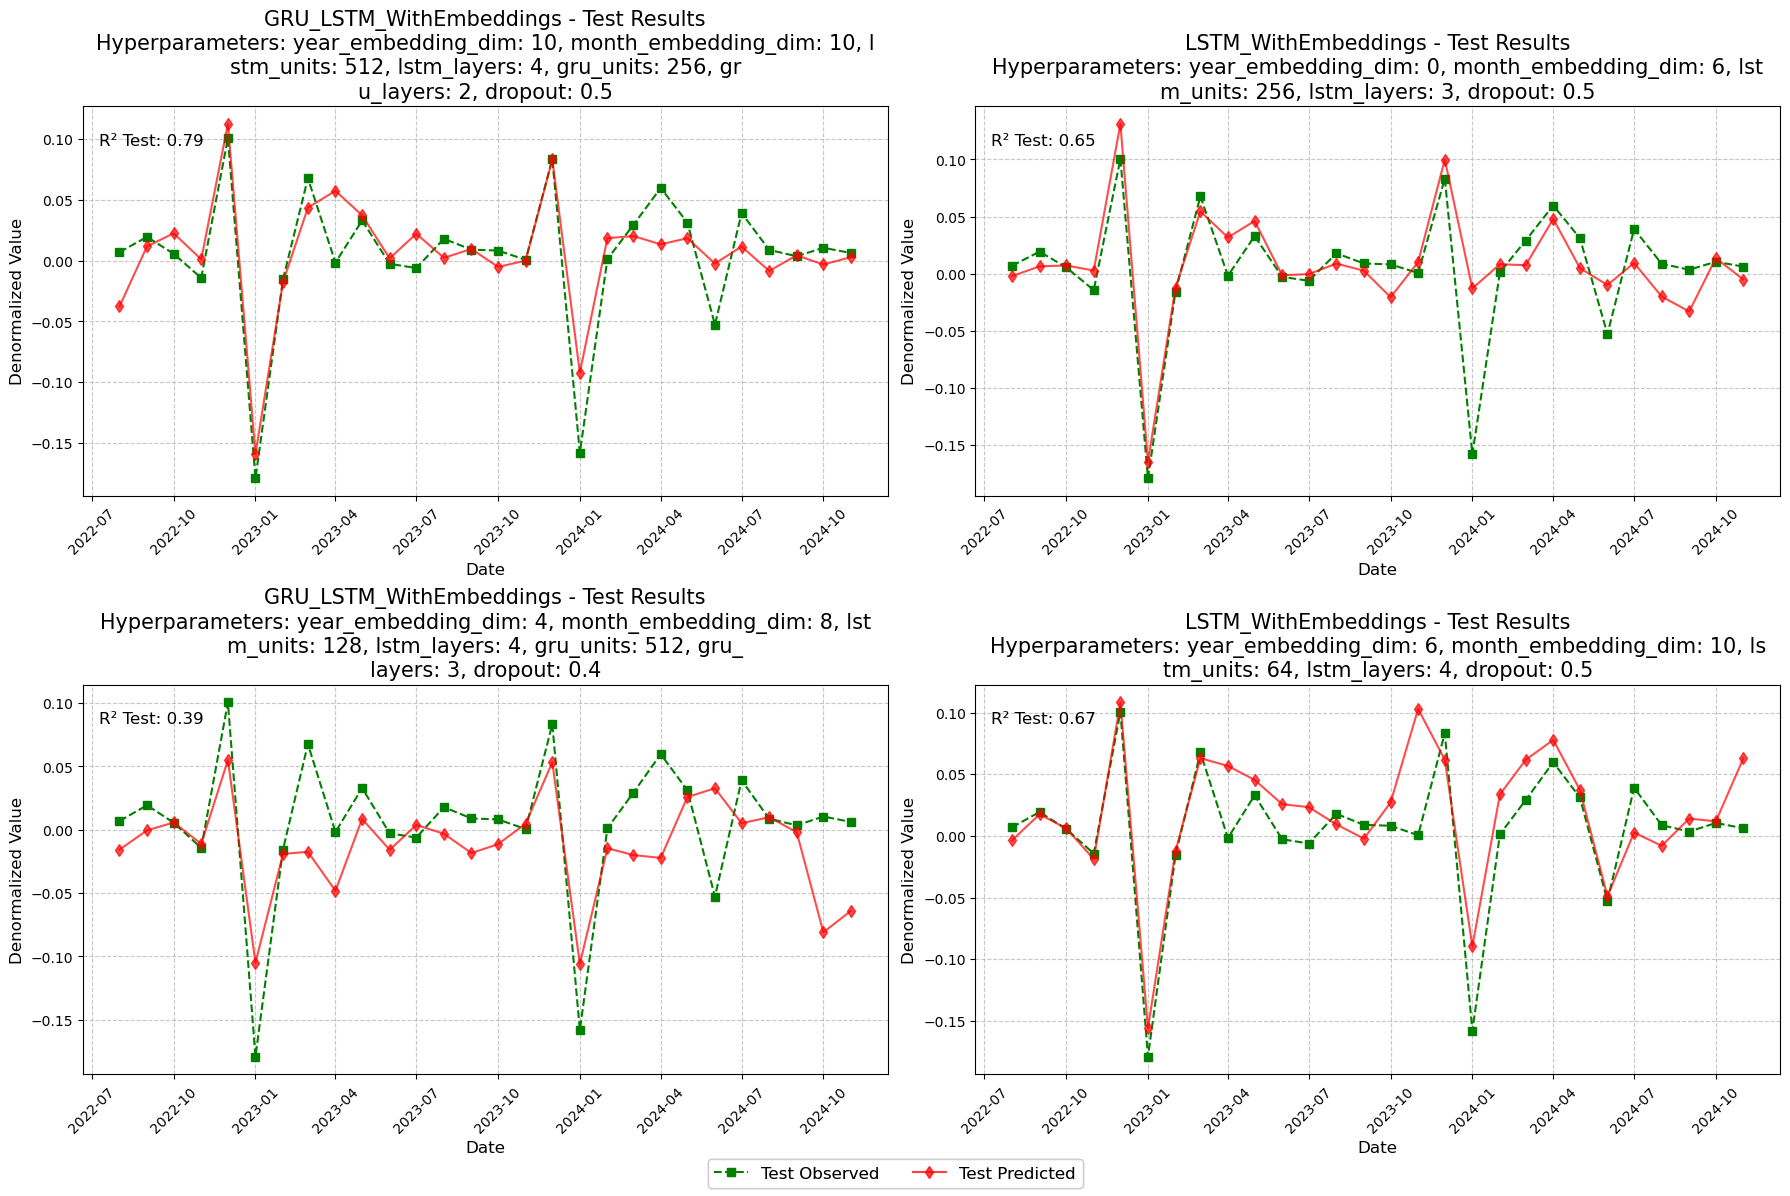

In [166]:
 
best_models_num = 4   
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i in range(best_models_num):
    model_info = final_results.iloc[i]
    model_name = model_info['model'].split(" (")[0]  # Extract the model name
    hyperparameters = eval(model_info['model'].split(" (")[1].strip(")"))

    plot_temporal_results(all_train_results_models[i], all_test_results_models[i],
                          title=model_name, hyperparameters=hyperparameters, plot_mode='test', ax=axes[i], fig=fig) 

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)   
plt.savefig('best_models.png', format='png', dpi=300)  # You can adjust the dpi for higher or lower quality
plt.show()


plt.show()


### Temporal Cross-Validation for the Top Models

In [136]:
# Lists to store all metrics and results
all_avg_metrics_models       = []
all_train_results_models     = []
all_test_results_models      = []
best_models_num = 4
# Train and evaluate the top  models
for i in range(best_models_num):
    print(f"#{i} Model")
    def set_seed(seed: int):
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    set_seed(42)

    model_info = final_results.iloc[i]
    avg_metrics, _, _ = train_and_evaluate_cv(model_info, 
                                              stationary_data, pbi_column_name,
                                              cv=True, seq_length=12, n_folds=5, 
                                              split_ratio=0.85, epochs=100, patience=15)


    all_avg_metrics_models.append({
        'model': model_info['model'].split(" (")[0],
        'hyperparameters': model_info['model'].split(" (")[1].rstrip(")"),
        'pca': model_info['pca'],
        'train_MAE': avg_metrics['MAE'],
        'test_MAE': avg_metrics['MAE'],
        'train_RMSE': avg_metrics['RMSE'],
        'test_RMSE': avg_metrics['RMSE'],
        'train_MAPE': avg_metrics['MAPE'],
        'test_MAPE': avg_metrics['MAPE'],
        'train_R2': avg_metrics['R2'],
        'test_R2': avg_metrics['R2']
    })
    
    #all_train_results_models.append(all_cv_train_results)
    #all_test_results_models.append(all_cv_test_results)


#0 Model
Model: GRU_LSTM_WithEmbeddings
Hyperparameters:
{'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 512, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.5}
PCA: 42 components | Explained Variance: 95.11%
------------------------------------------------------------
Fold 1/5 | Train end: 53, Fold size: 41, Split ratio: 0.56


Fold 1: Early stopping at epoch 49
Fold 1 metrics in test data: MAE 0.0384, RMSE 0.0480, MAPE 878.73, R² 0.08

PCA: 69 components | Explained Variance: 95.19%
------------------------------------------------------------
Fold 2/5 | Train end: 94, Fold size: 41, Split ratio: 0.70


Fold 2: Early stopping at epoch 45
Fold 2 metrics in test data: MAE 0.0414, RMSE 0.0581, MAPE 567.19, R² 0.13

PCA: 91 components | Explained Variance: 95.10%
------------------------------------------------------------
Fold 3/5 | Train end: 135, Fold size: 41, Split ratio: 0.77


Fold 3: Early stopping at epoch 31
Fold 3 metrics in test data: MAE 0.0363, RMSE 0.0497, MAPE 438.48, R² 0.23

PCA: 109 components | Explained Variance: 95.07%
------------------------------------------------------------
Fold 4/5 | Train end: 176, Fold size: 41, Split ratio: 0.81


Fold 4: Early stopping at epoch 86
Fold 4 metrics in test data: MAE 0.0438, RMSE 0.0813, MAPE 646.78, R² 0.37

PCA: 120 components | Explained Variance: 95.01%
------------------------------------------------------------
Fold 5/5 | Train end: 217, Fold size: 41, Split ratio: 0.84


Fold 5: Early stopping at epoch 33
Fold 5 metrics in test data: MAE 0.0353, RMSE 0.0539, MAPE 929.42, R² 0.12

Average CV Metrics:
  MAE: 0.0391
  RMSE: 0.0582
  MAPE: 692.1178
  R2: 0.1846



#1 Model
Model: LSTM_WithEmbeddings
Hyperparameters:
{'year_embedding_dim': 0, 'month_embedding_dim': 6, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.5}
PCA: 42 components | Explained Variance: 95.11%
------------------------------------------------------------
Fold 1/5 | Train end: 53, Fold size: 41, Split ratio: 0.56


Fold 1: Early stopping at epoch 17
Fold 1 metrics in test data: MAE 0.0402, RMSE 0.0515, MAPE 682.43, R² -0.06

PCA: 69 components | Explained Variance: 95.19%
------------------------------------------------------------
Fold 2/5 | Train end: 94, Fold size: 41, Split ratio: 0.70


Fold 2: Early stopping at epoch 41
Fold 2 metrics in test data: MAE 0.0251, RMSE 0.0359, MAPE 267.69, R² 0.67

PCA: 91 components | Explained Variance: 95.10%
------------------------------------------------------------
Fold 3/5 | Train end: 135, Fold size: 41, Split ratio: 0.77


Fold 3: Early stopping at epoch 73
Fold 3 metrics in test data: MAE 0.0183, RMSE 0.0244, MAPE 232.06, R² 0.81

PCA: 109 components | Explained Variance: 95.07%
------------------------------------------------------------
Fold 4/5 | Train end: 176, Fold size: 41, Split ratio: 0.81


Fold 4: Early stopping at epoch 25
Fold 4 metrics in test data: MAE 0.0558, RMSE 0.0990, MAPE 396.72, R² 0.07

PCA: 120 components | Explained Variance: 95.01%
------------------------------------------------------------
Fold 5/5 | Train end: 217, Fold size: 41, Split ratio: 0.84


Fold 5: Early stopping at epoch 33
Fold 5 metrics in test data: MAE 0.0415, RMSE 0.0615, MAPE 993.43, R² -0.15

Average CV Metrics:
  MAE: 0.0362
  RMSE: 0.0544
  MAPE: 514.4657
  R2: 0.2687



#2 Model
Model: GRU_LSTM_WithEmbeddings
Hyperparameters:
{'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 3, 'dropout': 0.4}
------------------------------------------------------------
Fold 1/5 | Train end: 53, Fold size: 41, Split ratio: 0.56


Fold 1: Early stopping at epoch 33
Fold 1 metrics in test data: MAE 0.0445, RMSE 0.0535, MAPE 512.59, R² -0.14

------------------------------------------------------------
Fold 2/5 | Train end: 94, Fold size: 41, Split ratio: 0.70


Fold 2: Early stopping at epoch 65
Fold 2 metrics in test data: MAE 0.0340, RMSE 0.0542, MAPE 210.06, R² 0.24

------------------------------------------------------------
Fold 3/5 | Train end: 135, Fold size: 41, Split ratio: 0.77


Fold 3: Early stopping at epoch 40
Fold 3 metrics in test data: MAE 0.0226, RMSE 0.0335, MAPE 176.99, R² 0.65

------------------------------------------------------------
Fold 4/5 | Train end: 176, Fold size: 41, Split ratio: 0.81


Fold 4: Early stopping at epoch 41
Fold 4 metrics in test data: MAE 0.0572, RMSE 0.0876, MAPE 199.07, R² 0.27



------------------------------------------------------------
Fold 5/5 | Train end: 217, Fold size: 41, Split ratio: 0.84


Fold 5: Early stopping at epoch 52
Fold 5 metrics in test data: MAE 0.0281, RMSE 0.0392, MAPE 440.28, R² 0.53

Average CV Metrics:
  MAE: 0.0373
  RMSE: 0.0536
  MAPE: 307.7978
  R2: 0.3096



#3 Model
Model: LSTM_WithEmbeddings
Hyperparameters:
{'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 64, 'lstm_layers': 4, 'dropout': 0.5}
PCA: 42 components | Explained Variance: 95.11%
------------------------------------------------------------
Fold 1/5 | Train end: 53, Fold size: 41, Split ratio: 0.56


Fold 1: Early stopping at epoch 23
Fold 1 metrics in test data: MAE 0.0366, RMSE 0.0523, MAPE 578.79, R² -0.09

PCA: 69 components | Explained Variance: 95.19%
------------------------------------------------------------
Fold 2/5 | Train end: 94, Fold size: 41, Split ratio: 0.70


Fold 2 metrics in test data: MAE 0.0219, RMSE 0.0283, MAPE 692.40, R² 0.79

PCA: 91 components | Explained Variance: 95.10%
------------------------------------------------------------
Fold 3/5 | Train end: 135, Fold size: 41, Split ratio: 0.77


Fold 3: Early stopping at epoch 96
Fold 3 metrics in test data: MAE 0.0200, RMSE 0.0270, MAPE 280.80, R² 0.77

PCA: 109 components | Explained Variance: 95.07%
------------------------------------------------------------
Fold 4/5 | Train end: 176, Fold size: 41, Split ratio: 0.81


Fold 4 metrics in test data: MAE 0.0459, RMSE 0.0827, MAPE 560.53, R² 0.35

PCA: 120 components | Explained Variance: 95.01%
------------------------------------------------------------
Fold 5/5 | Train end: 217, Fold size: 41, Split ratio: 0.84


Fold 5: Early stopping at epoch 44
Fold 5 metrics in test data: MAE 0.0372, RMSE 0.0561, MAPE 662.13, R² 0.05

Average CV Metrics:
  MAE: 0.0323
  RMSE: 0.0493
  MAPE: 554.9304
  R2: 0.3726





In [144]:
metrics_cv_best_models = pd.DataFrame(all_avg_metrics_models)
metrics_cv_best_models

,model,hyperparameters,pca,train_MAE,test_MAE,train_RMSE,test_RMSE,train_MAPE,test_MAPE,train_R2,test_R2
0,GRU_LSTM_WithEmbeddings,"{'year_embedding_dim': 10, 'month_embedding_dim': 10, 'lstm_units': 512, 'lstm_layers': 4, 'gru_units': 256, 'gru_layers': 2, 'dropout': 0.5}",True,0.039057,0.039057,0.058188,0.058188,692.117786,692.117786,0.184603,0.184603
1,LSTM_WithEmbeddings,"{'year_embedding_dim': 0, 'month_embedding_dim': 6, 'lstm_units': 256, 'lstm_layers': 3, 'dropout': 0.5}",True,0.036163,0.036163,0.054446,0.054446,514.465714,514.465714,0.268699,0.268699
2,GRU_LSTM_WithEmbeddings,"{'year_embedding_dim': 4, 'month_embedding_dim': 8, 'lstm_units': 128, 'lstm_layers': 4, 'gru_units': 512, 'gru_layers': 3, 'dropout': 0.4}",False,0.037287,0.037287,0.053601,0.053601,307.797835,307.797835,0.309611,0.309611
3,LSTM_WithEmbeddings,"{'year_embedding_dim': 6, 'month_embedding_dim': 10, 'lstm_units': 64, 'lstm_layers': 4, 'dropout': 0.5}",True,0.032320,0.032320,0.049305,0.049305,554.930382,554.930382,0.372627,0.372627
